In [45]:
# import library.
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression


def prepare_data(filename):
    # load data.
    data = []

    csvdata = open(filename,'r', encoding='utf-8')
    rdr = csv.reader(csvdata)
    for row in rdr:
        data.append(row)
    csvdata.close()

    # 설비 수와 작업 수 설정
    m = len(data[0]) # 설비 수
    n = len(data)     # 작업 수

    # Eij: 설비에 대한 작업 실행 시간
    Eij = []
    for i in range(len(data)):
        Eij.append(list(map(int,data[i])))

    # Cij: 설비에 대한 작업의 완료 시간 (작업 실행 시간과 동일)
    Cij = []
    for i in range(len(data)):
        Cij.append(list(map(int,data[i])))

    # rj: 설비 준비 시간 (준비 시간은 없음.)
    rj = []
    for i in range(m):
        rj.append(0)

    return m, n, Eij, Cij, rj

# Min-Min

In [46]:
def min_min(filename):
    MM = []

    m, n, Eij, Cij, rj = prepare_data(filename)

    # Min-Min 알고리즘
    for x in range(n):
        # mintime(최소완료시간) 집합 구하기
        mintime = []
        for i in range(len(Cij)):
            mintime.append(min(Cij[i]))

        # 구한 집합에서 min 값 구하기
        min_ptime = min(mintime)
        if min_ptime == 10000:
            break

        # 할당된 task와 machine 위치 찾기
        task_index = mintime.index(min_ptime)
        machine_index = Cij[task_index].index(min_ptime)

        # rj(설비 준비 시간) 업데이트
        rj[machine_index] = min_ptime

        # Cij = Eij + rj
        for i in range(len(Cij)):
            if Cij[i][machine_index] == 10000:
                continue
            else:
                Cij[i][machine_index] = Cij[i][machine_index] + Eij[task_index][machine_index]

        # 할당된 task를 10000로 만들기
        for i in range(len(Cij[task_index])):
            Cij[task_index][i] = 10000

        # 실행시간 및 과정
        ptime = Eij[task_index][machine_index]
        process = [task_index, machine_index, ptime]
        MM.append(ptime)
        # print(process)
    
    # 작업이 모두 할당된 설비(Rj) 상태
    # print("\n""작업(Ti)이 모두 할당된 설비(Rj) 상태 : ", rj)

    # makespan 구하기
    makespan = max(rj)
    
    return makespan, MM

# HASA

In [47]:
def hasa(filename):
    HASA = []
    
    m, n, Eij, Cij, rj = prepare_data(filename)

    # half average time(집합의 산술평균의 반) 구하기
    def average(mintime):
        return (sum(mintime) / (len(mintime) - mintime.count(0)))

    # mintime에서 half average time과 가까운 값 찾기
    def find_nearest(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return array[idx]

    def remove_values_from_list(the_list, val):
        return [value for value in the_list if value != val]

    # HASA 알고리즘
    for x in range(n):
        # mintime(최소완료시간) 집합 구하기
        mintime = []
        for i in range(len(Cij)):
            mintime.append(min(Cij[i]))

        avg_time = average(mintime)
        if sum(mintime) == 0:
            break

        h_avg_time = (avg_time/2)

        sel_min = remove_values_from_list(mintime, 0)

        avg_ptime = find_nearest(sel_min, avg_time)

        h_avg_ptime = find_nearest(sel_min, h_avg_time)
    
        # h_avg_ptime = find_nearest(sel_min, poly_list[x])
        if h_avg_ptime == 0:
            h_avg_ptime = avg_ptime
    
        # 할당된 task와 machine 위치 찾기
        task_index = mintime.index(h_avg_ptime)
        machine_index = Cij[task_index].index(h_avg_ptime)
        # print(task_index, machine_index)

        # rj(설비 준비 시간) 업데이트
        rj[machine_index] = h_avg_ptime
    
        # Cij = Eij + rj
        for i in range(len(Cij)):
            if Cij[i][machine_index] == 0:
                continue
            else:
                Cij[i][machine_index] = Cij[i][machine_index] + Eij[task_index][machine_index]

        # U = U - {Ts}
        for i in range(len(Cij[task_index])):
            Cij[task_index][i] = 0

        # print(Cij)


        # 결과 확인
        # 실행시간 및 과정
        ptime = Eij[task_index][machine_index]
        process = [task_index, machine_index, ptime]
        # print(process)
        HASA.append(ptime)

    # 작업이 모두 할당된 설비(Rj) 상태
    # print("\n""작업(Ti)이 모두 할당된 설비(Rj) 상태 : ", rj)

    # makespan 구하기
    makespan = max(rj)
    
    return makespan, HASA

# Find both ptimes (Min-Min & HASA) 

In [48]:
def get_ptimes(filename):
    mm_makespan, mm_ptimes = min_min(filename)
    hasa_makespan, hasa_ptimes = hasa(filename)
    
    ptimes_list = []
    ptimes_list.append(mm_ptimes)
    ptimes_list.append(hasa_ptimes)
    
    return ptimes_list

# Polynomial regression

In [49]:
def polynomial_regression(ptimes):
    ptimes_enum = []
    
    for i, pt in enumerate(ptimes):
        ptimes_enum.append([i, pt])
    
    x = np.array(ptimes_enum)[:,0].reshape(-1,1)
    y = np.array(ptimes_enum)[:,1].reshape(-1,1)
    
    poly_features = PolynomialFeatures(degree=2, include_bias=False)
    x_poly = poly_features.fit_transform(x)

    lin_reg = LinearRegression()
    lin_reg.fit(x_poly, y)

    intercept = lin_reg.intercept_[0]
    slope = lin_reg.coef_[0]

    return intercept, slope

# Calculate average slope & intercept of polynomial

In [50]:
def get_average_polynomial_from_ptimes(ptimes_list):
    intercept_total = 0
    slope_total = [0, 0]
    
    for ptimes in ptimes_list:
        intercept, slope = polynomial_regression(ptimes)
        intercept_total += intercept
        for i in range(len(slope_total)):
            slope_total[i] += slope[i]
        
        for i in range(len(slope_total)):
            slope_total[i] /= len(ptimes_list)

    return (intercept_total / len(ptimes_list)), slope_total

# job shop with polynomial regression

In [51]:
def polynomial_job_shop_main(filename_list):
    filename_list.sort()

    def find_nearest(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return array[idx]

    def remove_values_from_list(the_list, val):
        return [value for value in the_list if value != val]
    
    
    for filename in filename_list:
        POLY = []
        print(f"dataset: {filename}")
        ptimes_list = get_ptimes(filename)
        intercept, slope = get_average_polynomial_from_ptimes(ptimes_list)
        
        m, n, Eij, Cij, rj = prepare_data(filename)
        
        hasa_makespan, hasa_list = hasa(filename)
        minmin_makespan, minmin_list = min_min(filename)
        
        newline = '\n'
        
        print(f"Min-Min makespan: {minmin_makespan}{newline}process: {minmin_list}{newline}")
        print(f"HASA makespan: {hasa_makespan}{newline}process: {hasa_list}{newline}")
        
        poly_list = []
        
        for i in range(1, n+1):
            poly_list.append(slope[1]*i**2 + slope[0]*i + intercept)

        for x in range(n):
            mintime = []
            for i in range(len(Cij)):
                mintime.append(min(Cij[i]))

            if sum(mintime) == 0:
                break
    
            sel_min = remove_values_from_list(mintime, 0)

            nearest_ptime = find_nearest(sel_min, poly_list[x])

            task_index = mintime.index(nearest_ptime)
            machine_index = Cij[task_index].index(nearest_ptime)

            rj[machine_index] = nearest_ptime
    
            for i in range(len(Cij)):
                if Cij[i][machine_index] == 0:
                    continue
                else:
                    Cij[i][machine_index] = Cij[i][machine_index] + Eij[task_index][machine_index]

            for i in range(len(Cij[task_index])):
                Cij[task_index][i] = 0

            # 결과 확인
            # 실행시간 및 과정
            ptime = Eij[task_index][machine_index]
            process = [task_index, machine_index, ptime]
            # print(process)

            # 작업이 모두 할당된 설비(Rj) 상태
            # print("\n""작업(Ti)이 모두 할당된 설비(Rj) 상태 : ", rj)
            POLY.append(ptime)
    
        # makespan 구하기
        makespan = max(rj)
        print(f"Poly makespan: {makespan}{newline}process: {POLY}")
        print('\n\n')
        
        
        # plotting for visualization.
        hasa_plot = []
        minmin_plot = []
        
        for i, pt in enumerate(hasa_list):
            hasa_plot.append([i, pt])
            
        for i, pt in enumerate(minmin_list):
            minmin_plot.append([i, pt])

        x = np.array(hasa_plot)[:,0].reshape(-1,1)
        y1 = np.array(hasa_plot)[:,1].reshape(-1,1)
        y2 = np.array(minmin_plot)[:,1].reshape(-1,1)

        plt.rcParams["figure.figsize"] = (20,15)
        plt.plot(x, y1, 'o', label="HASA - Processing time", markersize=10)
        plt.plot(x, y2, '^', label="Min-Min - Processing time", markersize=10)
        plt.plot(x, slope[1]*x**2 + slope[0]*x + intercept, label="Polynomial")
        plt.xlabel("Assignment order", fontsize=24)
        plt.ylabel("Processing time", rotation=90, fontsize=24)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        plt.legend(loc="upper left", fontsize=24)
        plt.show()

# main
After compiling all above cells, run this cell to see the result for all datasets.

dataset: ./all_data/100x10-1.csv
Min-Min makespan: 128
process: [1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 4, 2, 4, 5, 4, 3, 3, 5, 3, 5, 5, 4, 4, 4, 5, 5, 4, 6, 8, 5, 6, 5, 6, 8, 4, 7, 6, 5, 8, 7, 13, 11, 10, 9, 8, 12, 9, 7, 9, 10, 12, 12, 12, 8, 9, 15, 13, 10, 10, 18, 13, 12, 12, 11, 14, 11, 17, 18, 21, 12, 14, 18, 16, 16, 18, 31, 26, 13, 19, 26, 19, 27, 20, 19, 19, 27, 31, 27, 43, 36, 30, 34, 37]

HASA makespan: 130
process: [5, 5, 6, 6, 6, 1, 2, 1, 1, 8, 8, 8, 2, 1, 1, 2, 2, 2, 1, 1, 5, 4, 1, 1, 12, 2, 13, 4, 2, 4, 1, 6, 5, 4, 4, 5, 2, 4, 7, 4, 3, 7, 5, 6, 4, 8, 5, 5, 10, 9, 8, 7, 5, 9, 10, 11, 9, 8, 12, 12, 9, 15, 13, 10, 10, 12, 18, 14, 12, 12, 11, 17, 11, 18, 13, 21, 16, 12, 18, 16, 14, 18, 31, 26, 13, 26, 19, 27, 23, 20, 19, 19, 31, 36, 35, 27, 30, 34, 37, 42]

Poly makespan: 129
process: [4, 4, 4, 4, 4, 3, 4, 1, 2, 1, 5, 3, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 3, 4, 4, 5, 3, 5, 5, 5, 5, 4, 8, 5, 5, 6, 6, 7, 6, 5, 8, 6, 8, 7, 13, 8, 10, 12, 9, 11, 9, 9, 7, 10, 10, 8, 

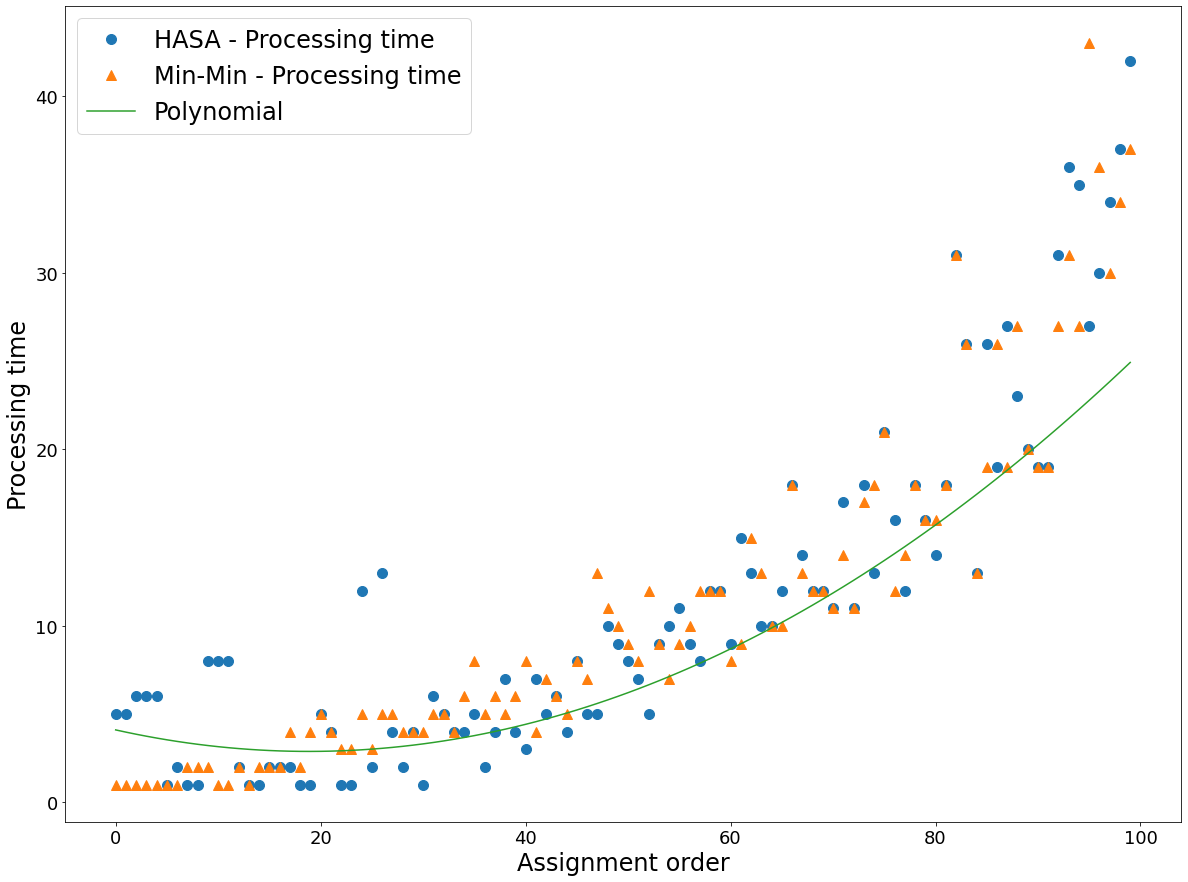

dataset: ./all_data/100x10-2.csv
Min-Min makespan: 140
process: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 1, 3, 3, 5, 3, 3, 3, 3, 5, 4, 3, 7, 4, 4, 4, 5, 3, 5, 8, 6, 8, 3, 4, 5, 8, 8, 6, 6, 8, 7, 7, 8, 8, 9, 7, 10, 10, 6, 8, 9, 11, 7, 10, 6, 11, 15, 11, 7, 16, 10, 12, 13, 13, 14, 13, 16, 11, 16, 13, 17, 19, 16, 19, 13, 21, 19, 14, 17, 17, 30, 22, 17, 23, 23, 20, 32, 21, 18, 20, 21, 52, 37, 38, 32, 35, 37, 34]

HASA makespan: 144
process: [6, 6, 6, 6, 1, 7, 7, 1, 8, 1, 8, 1, 3, 9, 1, 3, 1, 1, 3, 5, 11, 3, 1, 1, 3, 7, 5, 3, 3, 4, 3, 3, 5, 4, 3, 4, 4, 3, 5, 7, 6, 8, 8, 4, 8, 5, 8, 6, 7, 7, 8, 9, 10, 8, 6, 10, 11, 10, 15, 7, 10, 12, 13, 11, 14, 14, 16, 11, 16, 16, 13, 13, 19, 19, 13, 16, 17, 21, 14, 17, 22, 17, 19, 17, 17, 23, 32, 20, 35, 18, 23, 32, 21, 52, 35, 34, 32, 37, 37, 38]

Poly makespan: 140
process: [5, 5, 4, 4, 4, 3, 1, 3, 1, 1, 1, 5, 5, 1, 1, 1, 1, 1, 1, 6, 1, 3, 3, 3, 3, 3, 3, 3, 3, 4, 8, 6, 6, 7, 8, 3, 4, 5, 8, 6, 8, 7, 7, 7, 8, 8, 8, 9, 10, 6, 7, 8, 9, 11, 10, 10, 6, 11, 15, 

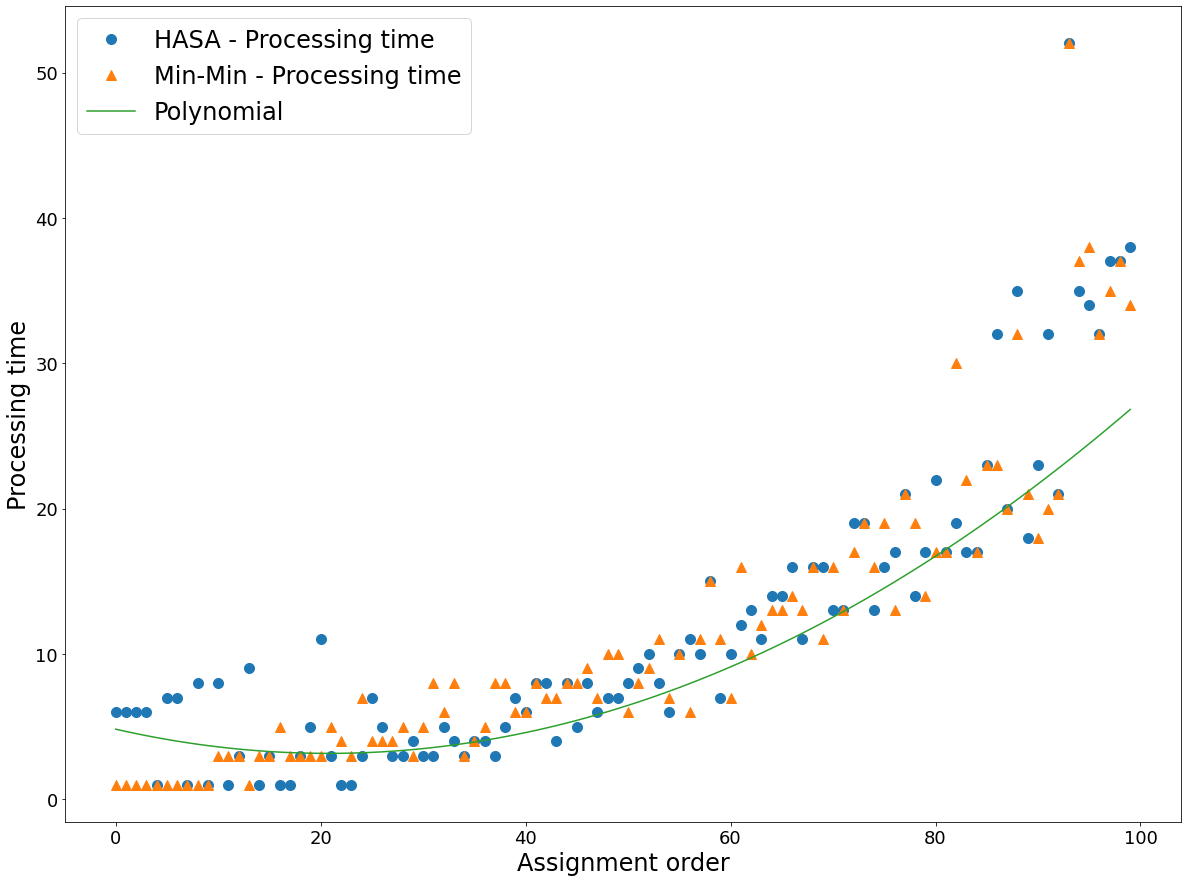

dataset: ./all_data/100x10-3.csv
Min-Min makespan: 122
process: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 2, 3, 2, 2, 3, 2, 3, 3, 2, 2, 2, 2, 2, 3, 4, 4, 2, 3, 3, 4, 4, 3, 3, 4, 5, 5, 3, 4, 4, 8, 12, 5, 8, 4, 9, 8, 10, 6, 5, 4, 7, 9, 12, 9, 7, 9, 7, 11, 14, 7, 14, 8, 7, 10, 13, 14, 12, 18, 8, 14, 16, 13, 11, 19, 15, 13, 18, 15, 13, 20, 22, 19, 14, 23, 16, 22, 26, 22, 29, 21, 33, 37, 38, 34, 43, 37, 46]

HASA makespan: 128
process: [5, 5, 5, 6, 1, 5, 6, 7, 2, 1, 2, 1, 2, 2, 8, 1, 9, 4, 3, 3, 1, 2, 2, 2, 1, 3, 12, 1, 2, 2, 1, 2, 4, 3, 1, 4, 2, 3, 2, 4, 4, 8, 1, 4, 3, 3, 4, 5, 3, 8, 7, 4, 7, 9, 7, 12, 12, 9, 14, 9, 8, 7, 7, 10, 9, 12, 13, 8, 8, 14, 16, 11, 14, 18, 14, 13, 13, 20, 18, 13, 19, 15, 19, 15, 14, 22, 23, 16, 22, 21, 26, 22, 29, 33, 37, 43, 38, 34, 46, 41]

Poly makespan: 119
process: [5, 5, 5, 4, 4, 4, 4, 4, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 3, 1, 2, 2, 3, 2, 4, 2, 2, 2, 2, 3, 3, 2, 3, 2, 4, 5, 3, 3, 8, 8, 4, 12, 9, 3, 10, 6, 7, 4, 8, 5, 9, 12, 9, 7, 7, 7, 9, 14, 11, 14, 

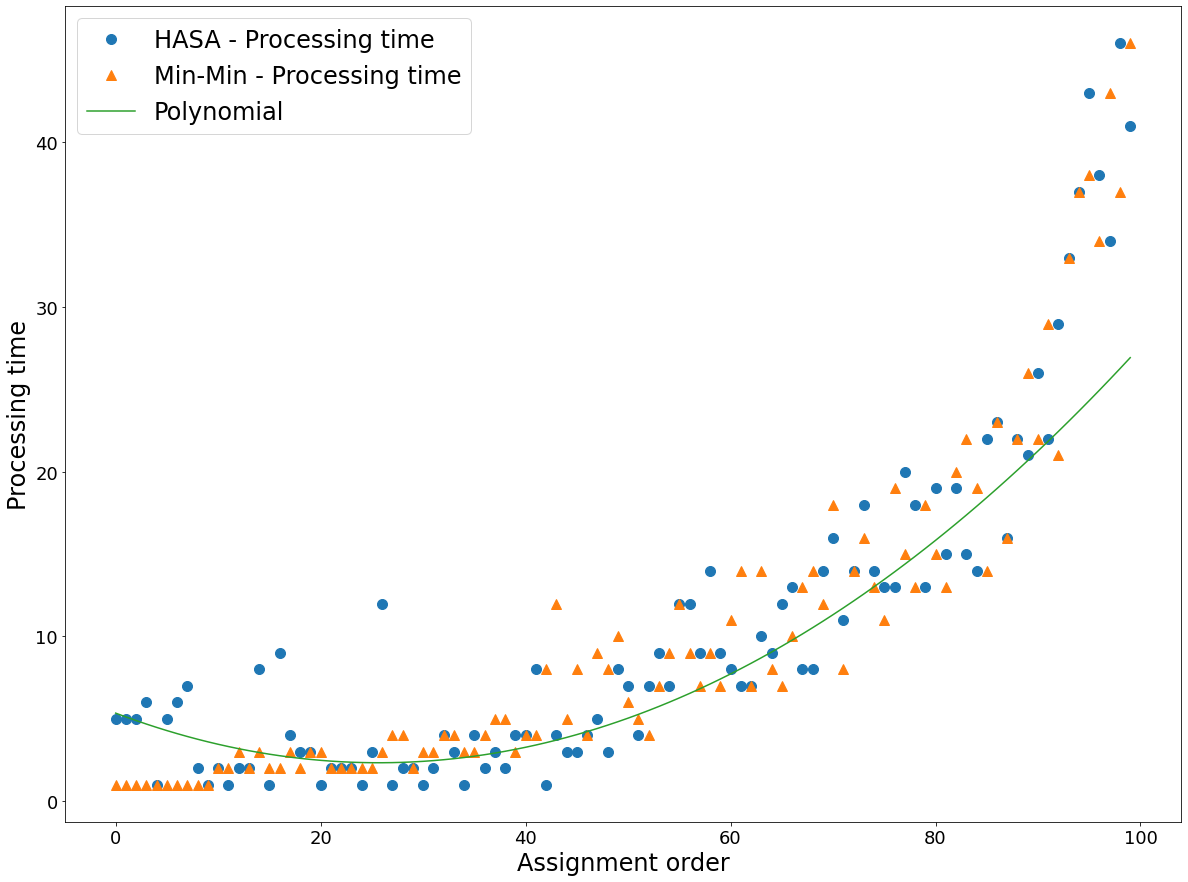

dataset: ./all_data/100x10-4.csv
Min-Min makespan: 116
process: [1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 3, 3, 4, 3, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 4, 5, 5, 6, 6, 4, 6, 5, 8, 6, 6, 5, 6, 7, 5, 5, 7, 7, 6, 6, 7, 6, 5, 11, 8, 6, 9, 6, 8, 13, 13, 9, 8, 7, 7, 9, 8, 14, 11, 9, 9, 13, 9, 14, 12, 12, 12, 9, 14, 15, 16, 14, 21, 13, 12, 19, 16, 14, 20, 16, 24, 23, 17, 23, 29, 18, 15, 27, 18, 27, 32, 27, 35, 43]

HASA makespan: 124
process: [5, 5, 5, 6, 6, 6, 7, 1, 7, 7, 1, 1, 1, 3, 2, 3, 3, 1, 3, 1, 1, 2, 10, 1, 4, 1, 2, 3, 3, 3, 3, 3, 5, 4, 6, 5, 4, 6, 8, 6, 4, 7, 6, 5, 6, 6, 5, 13, 7, 7, 5, 11, 6, 7, 9, 9, 8, 8, 8, 7, 13, 13, 9, 8, 12, 11, 9, 14, 9, 9, 14, 14, 12, 12, 9, 14, 13, 15, 16, 21, 12, 16, 14, 19, 16, 20, 24, 23, 17, 23, 15, 18, 29, 27, 18, 20, 32, 40, 27, 47]

Poly makespan: 127
process: [4, 4, 4, 4, 3, 1, 3, 3, 3, 3, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 3, 2, 3, 3, 4, 3, 3, 5, 5, 5, 3, 6, 7, 8, 5, 6, 6, 5, 6, 6, 5, 7, 6, 6, 7, 5, 6, 7, 11, 13, 13, 8, 5, 6, 6, 8, 9, 9, 7, 8, 7, 9, 8, 14, 9, 13,

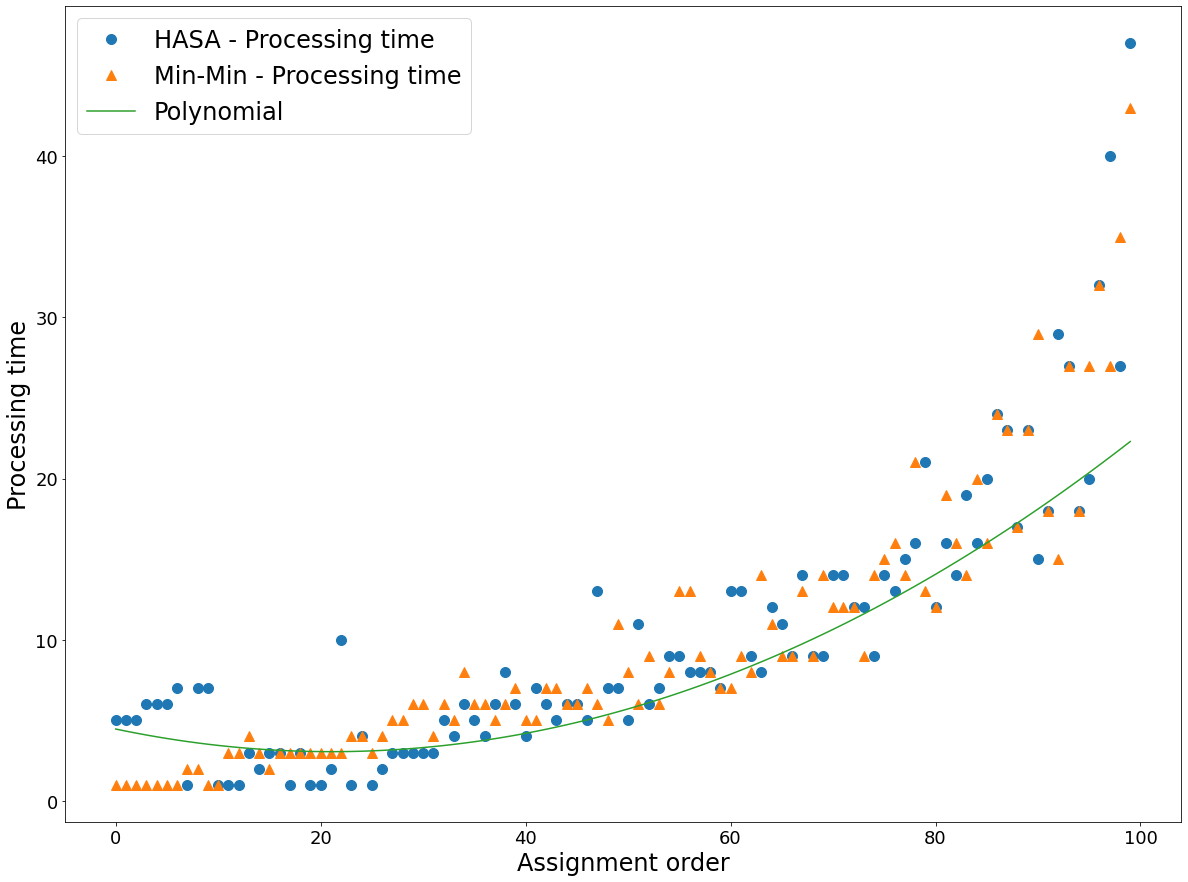

dataset: ./all_data/100x10-5.csv
Min-Min makespan: 129
process: [1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 3, 2, 3, 3, 3, 2, 2, 2, 4, 2, 3, 3, 2, 2, 3, 4, 4, 3, 5, 5, 3, 4, 4, 4, 4, 4, 5, 4, 4, 6, 6, 7, 6, 7, 7, 4, 5, 6, 8, 7, 8, 5, 8, 6, 9, 8, 12, 11, 11, 8, 11, 11, 9, 13, 12, 16, 13, 9, 11, 15, 11, 15, 13, 13, 11, 14, 16, 20, 13, 17, 19, 14, 14, 13, 17, 20, 17, 20, 19, 14, 16, 15, 37, 18, 18, 29, 40, 28, 38, 53]

HASA makespan: 132
process: [5, 5, 5, 5, 1, 1, 6, 6, 2, 7, 7, 1, 2, 1, 2, 2, 3, 9, 4, 1, 3, 10, 1, 2, 2, 2, 3, 2, 3, 3, 3, 4, 4, 2, 6, 6, 4, 4, 6, 4, 4, 4, 4, 4, 4, 6, 7, 4, 8, 9, 7, 6, 8, 5, 8, 11, 8, 8, 11, 11, 12, 12, 13, 11, 9, 9, 16, 15, 11, 15, 13, 13, 11, 13, 11, 12, 20, 16, 17, 14, 17, 13, 14, 18, 17, 14, 19, 20, 20, 15, 16, 37, 19, 18, 29, 18, 28, 38, 46, 53]

Poly makespan: 129
process: [4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 3, 2, 3, 3, 2, 2, 2, 2, 5, 5, 3, 3, 2, 2, 3, 4, 5, 3, 4, 6, 6, 7, 6, 7, 7, 4, 5, 6, 8, 7, 8, 5, 8, 6, 9, 8, 12, 11, 11, 8, 11, 11, 9

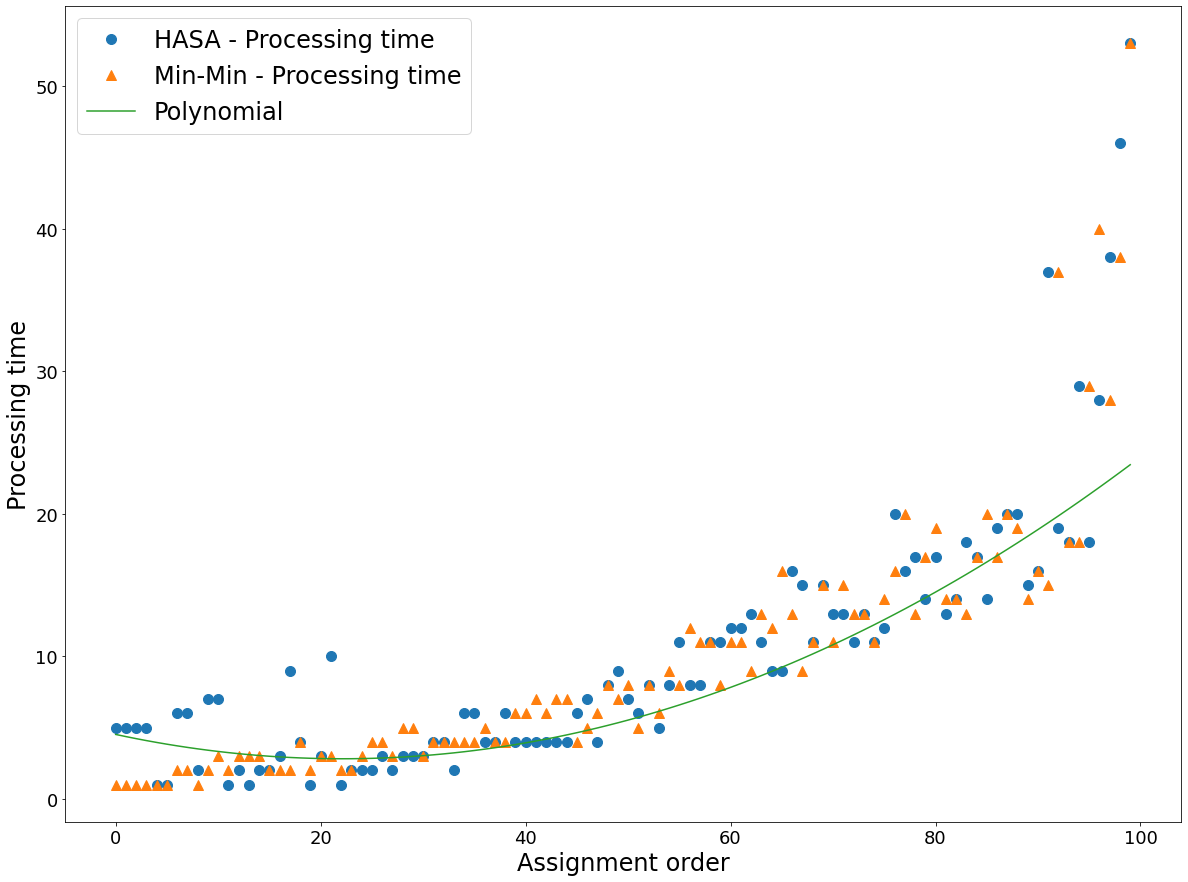

dataset: ./all_data/200x10-1.csv
Min-Min makespan: 218
process: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 3, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 3, 2, 2, 3, 2, 3, 4, 5, 3, 2, 2, 3, 3, 4, 5, 3, 3, 4, 3, 4, 3, 5, 4, 3, 4, 3, 4, 4, 5, 4, 6, 3, 4, 3, 4, 5, 6, 4, 5, 3, 5, 4, 4, 7, 4, 4, 5, 4, 4, 4, 7, 6, 8, 4, 5, 5, 4, 7, 5, 7, 5, 4, 5, 7, 9, 6, 8, 8, 10, 8, 7, 6, 7, 9, 8, 11, 9, 9, 8, 8, 12, 9, 12, 8, 11, 9, 11, 9, 9, 9, 11, 12, 9, 9, 16, 13, 10, 10, 12, 12, 10, 12, 13, 9, 11, 11, 13, 10, 12, 12, 16, 13, 16, 12, 14, 11, 20, 15, 16, 16, 13, 16, 13, 17, 18, 19, 17, 20, 16, 18, 18, 14, 25, 18, 19, 21, 19, 21, 19, 23, 18, 23, 22, 19, 32, 25, 24, 24, 28, 20, 33, 25, 47, 48, 27, 24, 35, 42, 36, 26, 32]

HASA makespan: 226
process: [5, 5, 5, 5, 5, 6, 1, 1, 1, 1, 6, 7, 1, 2, 1, 1, 7, 1, 2, 1, 8, 2, 1, 3, 1, 2, 2, 3, 2, 1, 1, 2, 1, 1, 1, 1, 4, 1, 1, 1, 2, 2, 2, 1, 1, 2, 3, 2, 4, 3, 2, 2, 2, 5, 2, 2, 3, 3, 4, 2, 3, 5, 3, 3, 4, 3, 3, 5, 4, 4, 4, 4, 4, 3, 5, 3, 7, 

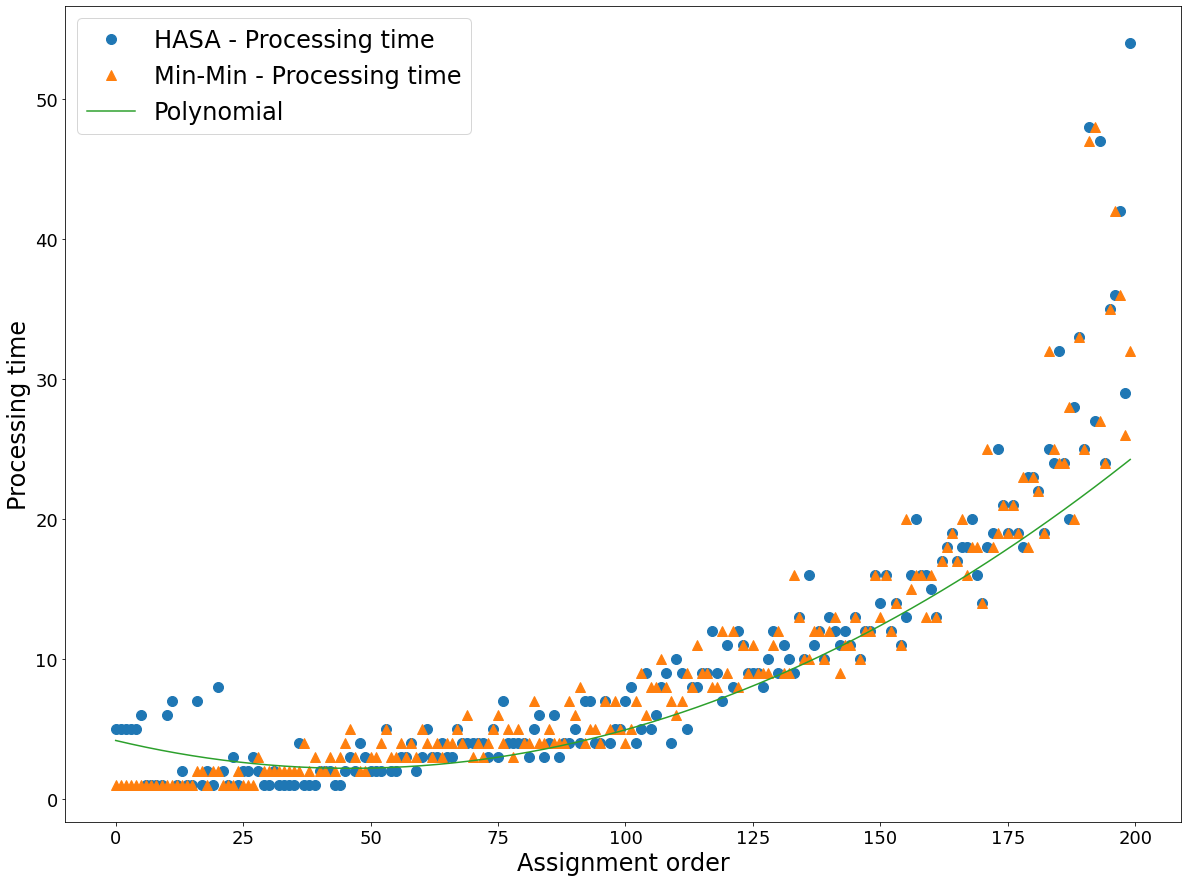

dataset: ./all_data/200x10-2.csv
Min-Min makespan: 247
process: [1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 3, 2, 3, 3, 2, 2, 2, 4, 2, 2, 3, 2, 2, 4, 2, 4, 3, 2, 2, 3, 3, 5, 4, 3, 2, 3, 5, 3, 2, 3, 5, 5, 3, 5, 6, 4, 4, 4, 6, 5, 4, 6, 4, 5, 8, 5, 8, 5, 6, 8, 7, 5, 5, 6, 9, 8, 6, 8, 6, 10, 7, 9, 7, 6, 7, 8, 7, 8, 10, 8, 9, 8, 11, 8, 8, 10, 7, 8, 8, 11, 8, 9, 8, 11, 9, 10, 9, 10, 15, 9, 10, 12, 8, 9, 11, 10, 10, 11, 9, 9, 11, 12, 10, 17, 10, 10, 12, 12, 11, 10, 10, 13, 10, 13, 11, 12, 10, 13, 17, 13, 14, 13, 13, 12, 11, 16, 14, 13, 17, 17, 12, 17, 19, 15, 17, 17, 22, 17, 19, 17, 19, 16, 19, 21, 21, 19, 34, 22, 18, 20, 21, 19, 22, 19, 23, 24, 20, 21, 27, 19, 28, 43, 24, 37, 40, 41, 41, 33, 34, 46, 43, 81]

HASA makespan: 252
process: [5, 5, 6, 6, 6, 1, 2, 7, 7, 7, 8, 1, 8, 1, 1, 2, 2, 3, 2, 2, 1, 1, 1, 1, 1, 1, 5, 4, 1, 2, 1, 1, 1, 2, 2, 2, 3, 1, 1, 2, 3, 1, 2, 2, 2, 2, 3, 2, 2, 4, 3, 2, 2, 4, 3, 3, 2, 5, 2, 4, 2, 3, 2, 5, 2, 3, 3, 5, 5, 3, 4, 5, 4,

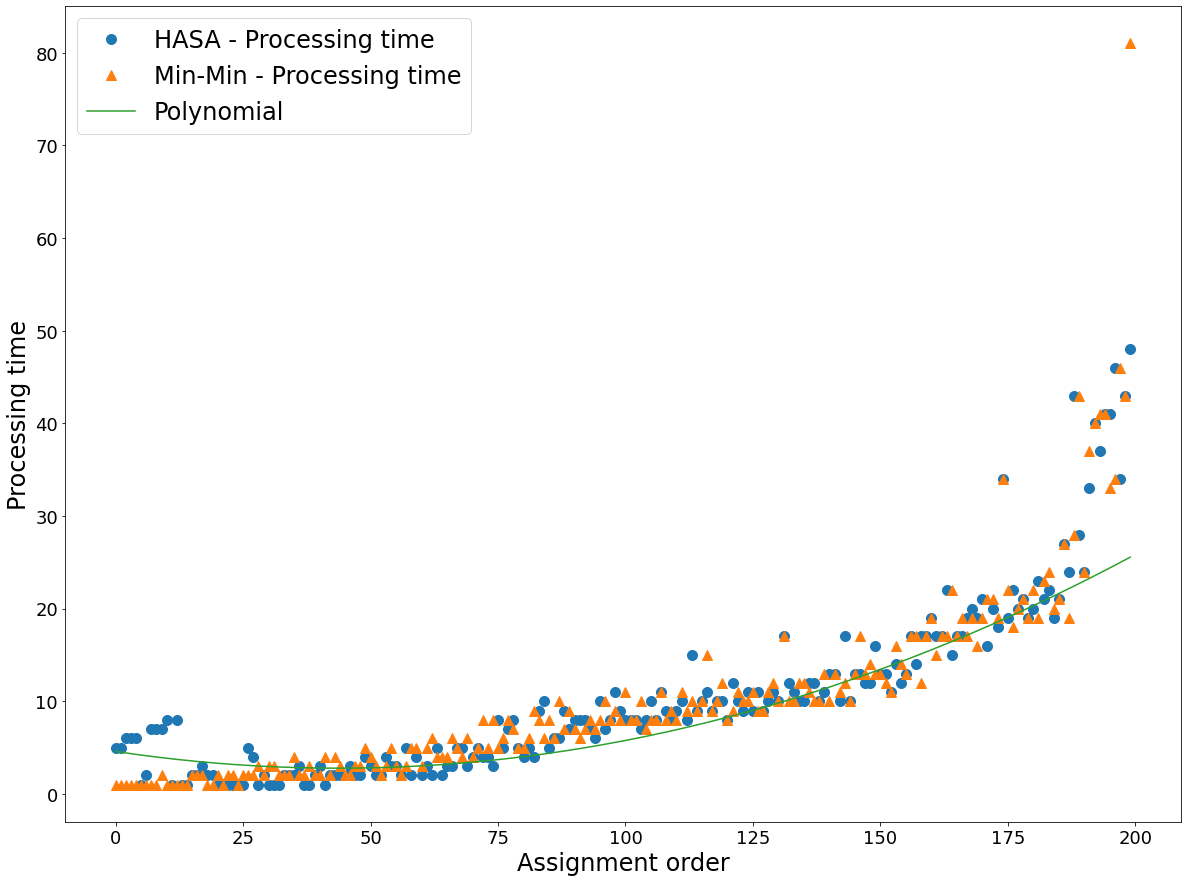

dataset: ./all_data/200x10-3.csv
Min-Min makespan: 226
process: [1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 3, 3, 2, 2, 4, 2, 2, 3, 3, 2, 2, 3, 4, 3, 3, 4, 2, 2, 4, 4, 3, 3, 3, 3, 3, 4, 4, 5, 5, 3, 3, 4, 5, 5, 4, 4, 4, 4, 5, 4, 6, 6, 4, 5, 5, 4, 7, 7, 5, 5, 6, 6, 5, 6, 7, 5, 5, 8, 6, 6, 5, 6, 11, 6, 7, 7, 8, 8, 7, 10, 8, 8, 7, 9, 10, 11, 8, 9, 10, 9, 8, 9, 10, 10, 8, 12, 10, 14, 9, 9, 11, 10, 9, 15, 12, 13, 11, 9, 12, 11, 11, 9, 18, 13, 10, 12, 17, 10, 11, 15, 15, 15, 11, 13, 13, 12, 14, 20, 19, 17, 16, 12, 16, 15, 13, 14, 19, 22, 20, 18, 20, 19, 15, 19, 14, 15, 19, 15, 16, 18, 20, 21, 23, 23, 22, 24, 20, 19, 25, 26, 25, 24, 31, 33, 31, 23, 40, 29, 32, 31, 34, 59]

HASA makespan: 228
process: [5, 5, 5, 5, 1, 1, 6, 1, 1, 6, 6, 1, 7, 1, 7, 2, 2, 2, 1, 1, 1, 8, 3, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 4, 1, 2, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 3, 2, 2, 2, 1, 2, 2, 3, 2, 4, 3, 3, 3, 4, 2, 3, 3, 4, 4, 3, 3, 3, 4, 4, 4, 4, 6

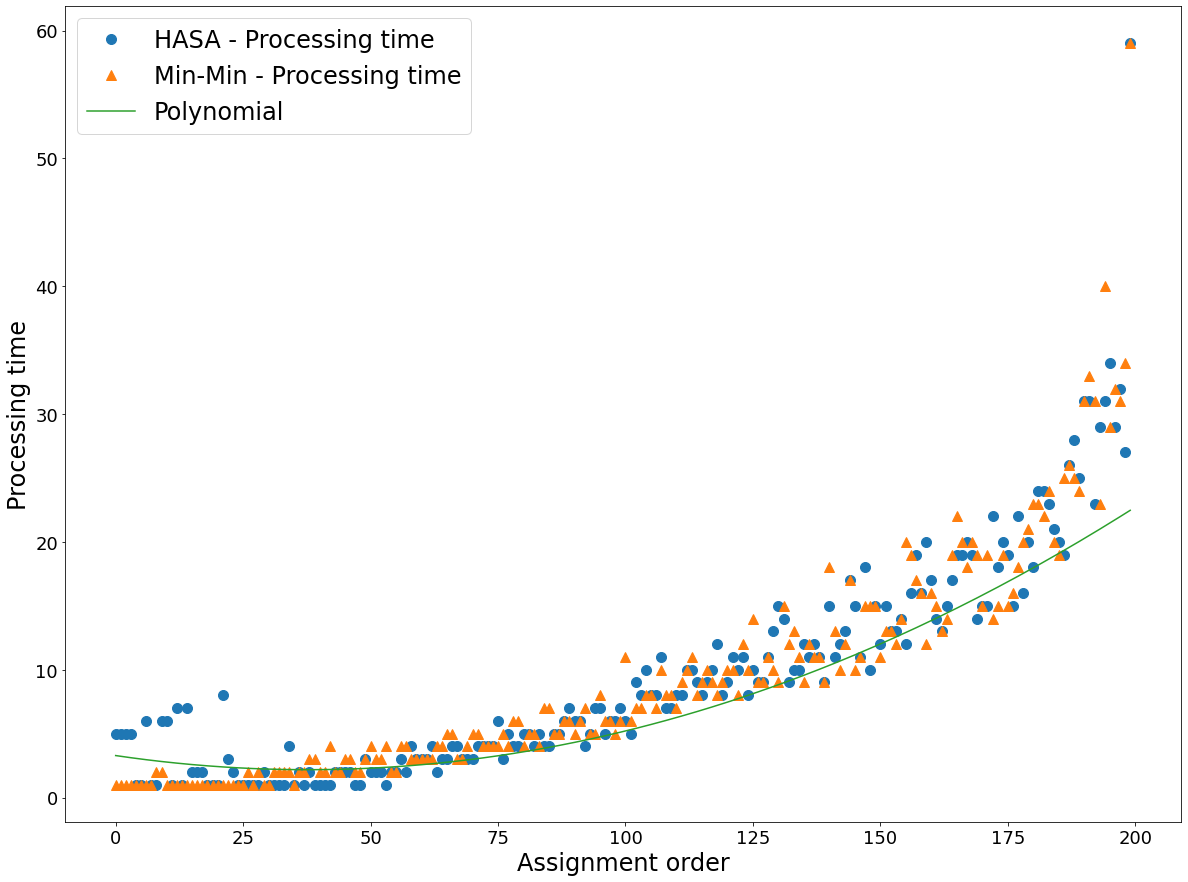

dataset: ./all_data/200x10-4.csv
Min-Min makespan: 226
process: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 3, 2, 1, 2, 3, 2, 2, 3, 3, 4, 2, 2, 4, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 4, 3, 4, 4, 3, 3, 3, 5, 3, 4, 3, 3, 3, 5, 4, 6, 4, 6, 4, 5, 4, 3, 4, 4, 5, 4, 5, 5, 5, 5, 5, 6, 9, 4, 6, 5, 5, 6, 5, 6, 6, 5, 7, 5, 7, 6, 9, 6, 7, 7, 8, 6, 8, 9, 7, 9, 7, 7, 7, 8, 12, 9, 9, 7, 10, 7, 9, 9, 9, 8, 9, 8, 10, 8, 12, 11, 11, 10, 12, 8, 10, 14, 10, 9, 13, 11, 10, 9, 12, 10, 13, 10, 13, 15, 10, 10, 13, 13, 12, 10, 15, 14, 11, 12, 15, 13, 14, 18, 13, 13, 15, 17, 12, 15, 13, 16, 14, 14, 13, 21, 25, 15, 19, 17, 23, 15, 17, 15, 18, 16, 15, 20, 20, 25, 18, 21, 28, 27, 19, 20, 20, 30, 23, 25, 29, 34, 30, 33, 32, 28, 38, 40]

HASA makespan: 221
process: [5, 5, 5, 5, 6, 1, 6, 1, 6, 7, 1, 2, 1, 1, 1, 7, 1, 8, 2, 1, 1, 2, 4, 2, 1, 2, 3, 2, 3, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 3, 2, 3, 3, 3, 3, 4, 2, 2, 3, 3, 2, 3, 3, 4, 3, 4, 3, 4, 3, 5, 3, 3, 3, 4, 3, 3, 5, 4, 6, 3, 4, 5, 6,

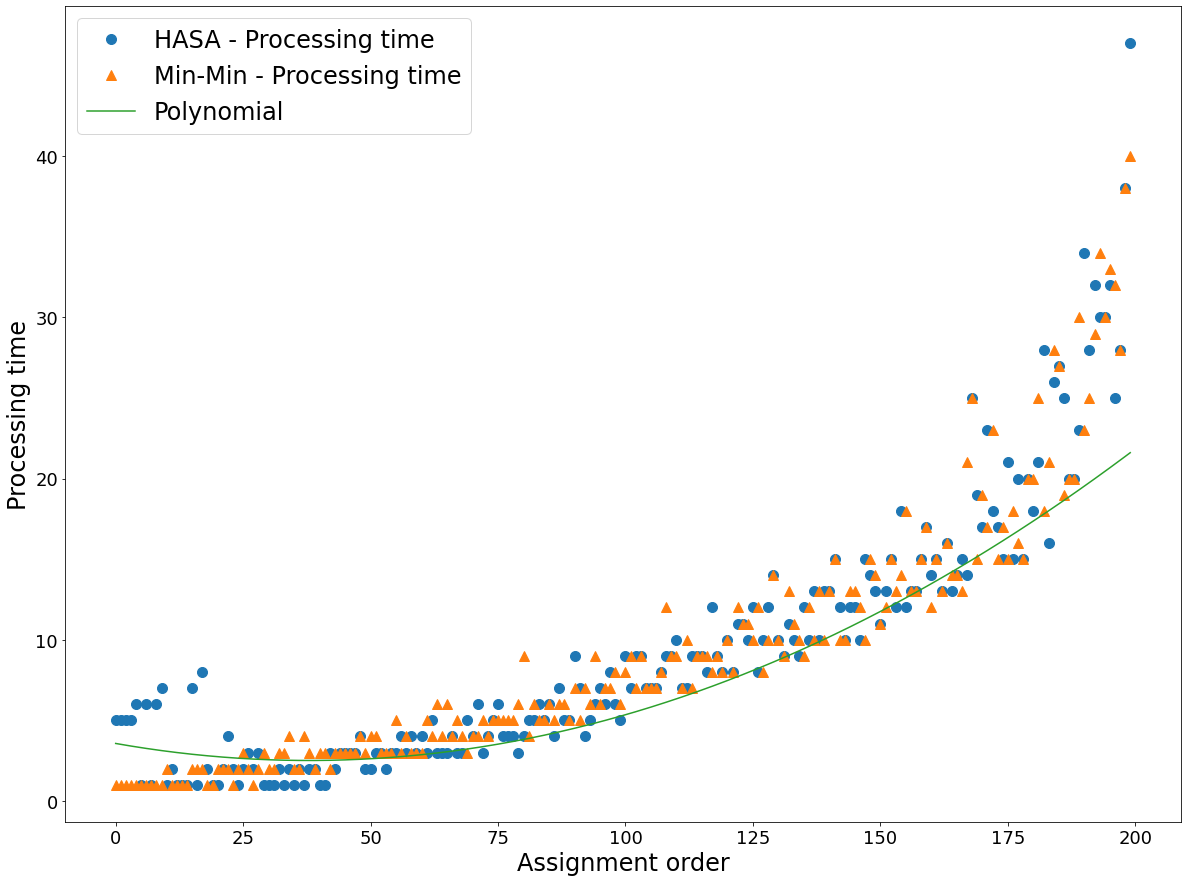

dataset: ./all_data/200x10-5.csv
Min-Min makespan: 231
process: [1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 3, 2, 3, 3, 3, 3, 3, 2, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 3, 5, 3, 4, 3, 4, 5, 3, 4, 4, 5, 5, 4, 4, 6, 6, 5, 4, 5, 4, 4, 5, 6, 5, 4, 4, 7, 6, 6, 6, 6, 5, 7, 7, 5, 9, 7, 7, 7, 7, 6, 5, 6, 7, 8, 5, 7, 7, 7, 8, 9, 8, 7, 8, 6, 7, 7, 11, 9, 8, 10, 9, 6, 10, 9, 8, 7, 9, 11, 11, 14, 10, 12, 11, 7, 12, 11, 10, 11, 13, 8, 12, 13, 15, 13, 15, 15, 13, 9, 13, 13, 14, 10, 17, 14, 18, 16, 17, 17, 14, 11, 17, 26, 17, 18, 19, 17, 15, 18, 19, 13, 20, 19, 22, 18, 20, 18, 25, 29, 24, 27, 24, 22, 24, 26, 29, 34, 29, 29, 29, 31, 27, 27, 37, 31, 31, 42, 38, 42, 43, 34, 55]

HASA makespan: 235
process: [5, 5, 6, 6, 1, 6, 6, 7, 1, 7, 7, 1, 8, 2, 2, 3, 3, 1, 2, 4, 2, 1, 1, 2, 1, 3, 1, 4, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2, 3, 2, 2, 1, 2, 2, 2, 2, 3, 2, 3, 3, 2, 3, 3, 3, 4, 4, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 5, 5, 3, 3, 4, 6, 4, 5, 4, 

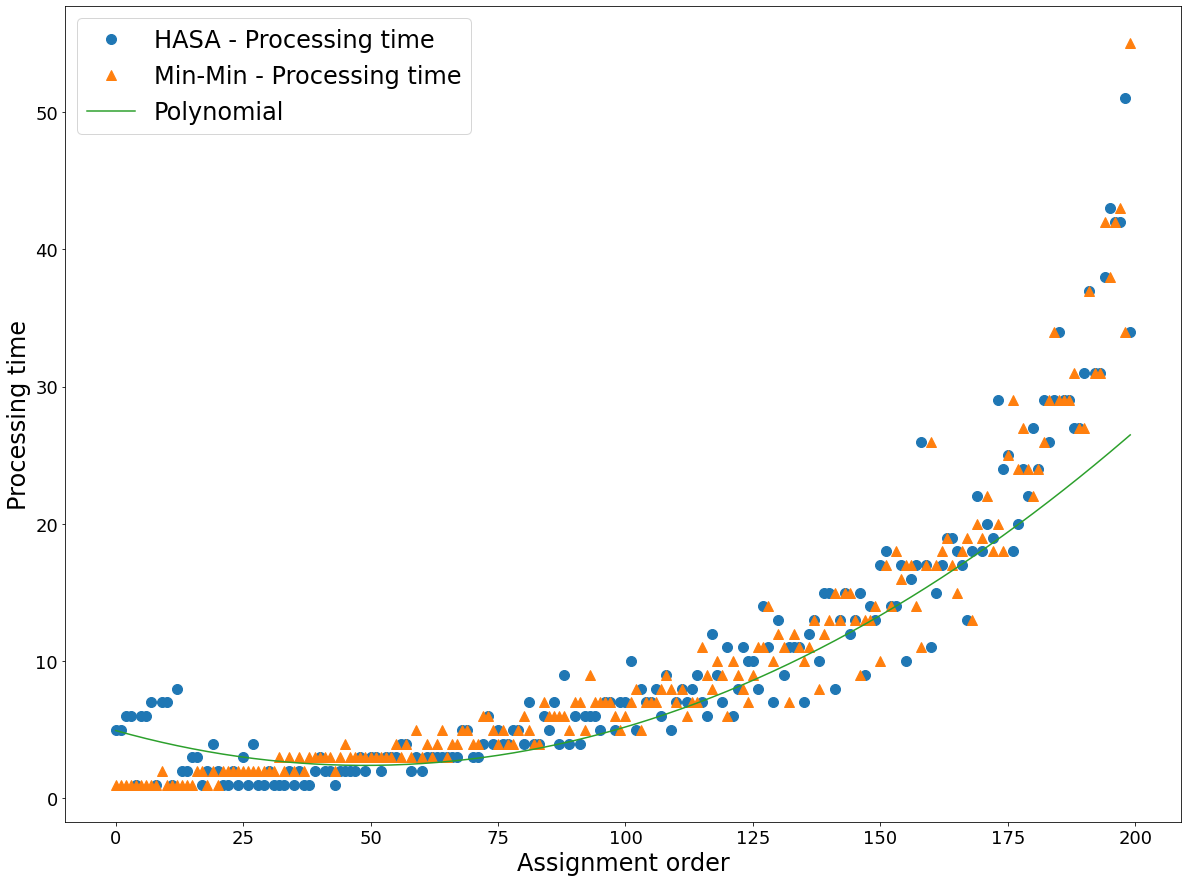

dataset: ./all_data/2x50-1.csv
Min-Min makespan: 909
process: [1, 2, 3, 4, 8, 4, 5, 10, 9, 11, 10, 14, 15, 18, 19, 21, 20, 22, 20, 22, 22, 24, 23, 28, 28, 30, 29, 33, 34, 37, 37, 40, 43, 45, 58, 46, 65, 52, 68, 53, 56, 69, 67, 75, 73, 77, 78, 81, 80, 91]

HASA makespan: 909
process: [18, 3, 22, 8, 9, 2, 1, 4, 10, 4, 5, 11, 10, 14, 15, 21, 19, 22, 20, 22, 20, 24, 23, 28, 28, 30, 29, 33, 34, 37, 37, 40, 43, 45, 58, 46, 65, 52, 68, 53, 56, 69, 67, 75, 73, 77, 78, 81, 80, 91]

Poly makespan: 909
process: [5, 1, 2, 8, 3, 4, 4, 10, 9, 11, 10, 14, 15, 18, 19, 21, 20, 22, 20, 22, 22, 24, 23, 28, 28, 30, 29, 33, 34, 37, 37, 40, 43, 45, 58, 46, 65, 52, 68, 53, 56, 69, 67, 75, 73, 77, 78, 81, 80, 91]





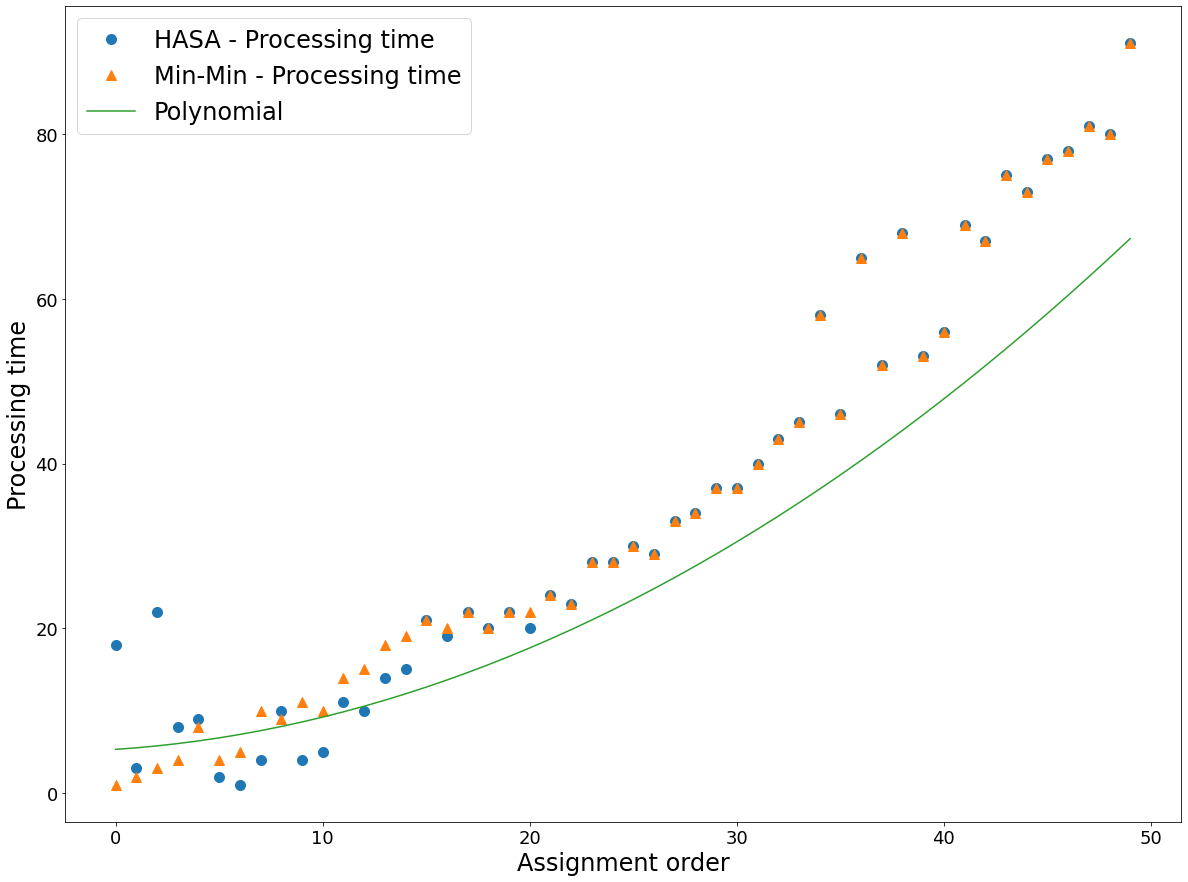

dataset: ./all_data/2x50-2.csv
Min-Min makespan: 967
process: [1, 3, 2, 3, 3, 6, 9, 7, 7, 18, 8, 14, 23, 20, 24, 21, 25, 31, 25, 34, 25, 28, 38, 28, 40, 29, 41, 33, 38, 52, 38, 54, 41, 55, 46, 46, 57, 48, 57, 51, 74, 54, 77, 73, 80, 77, 80, 82, 84, 100]

HASA makespan: 967
process: [18, 3, 21, 9, 14, 1, 2, 3, 3, 6, 7, 23, 7, 8, 24, 20, 25, 31, 25, 34, 25, 28, 38, 28, 40, 29, 41, 33, 38, 52, 38, 54, 41, 55, 46, 46, 57, 48, 57, 51, 74, 54, 77, 73, 80, 77, 80, 82, 84, 100]

Poly makespan: 967
process: [6, 1, 9, 2, 3, 3, 3, 7, 7, 18, 8, 14, 23, 20, 24, 21, 25, 31, 25, 34, 25, 28, 38, 28, 40, 29, 41, 33, 38, 52, 38, 54, 41, 55, 46, 46, 57, 48, 57, 51, 74, 54, 77, 73, 80, 77, 80, 82, 84, 100]





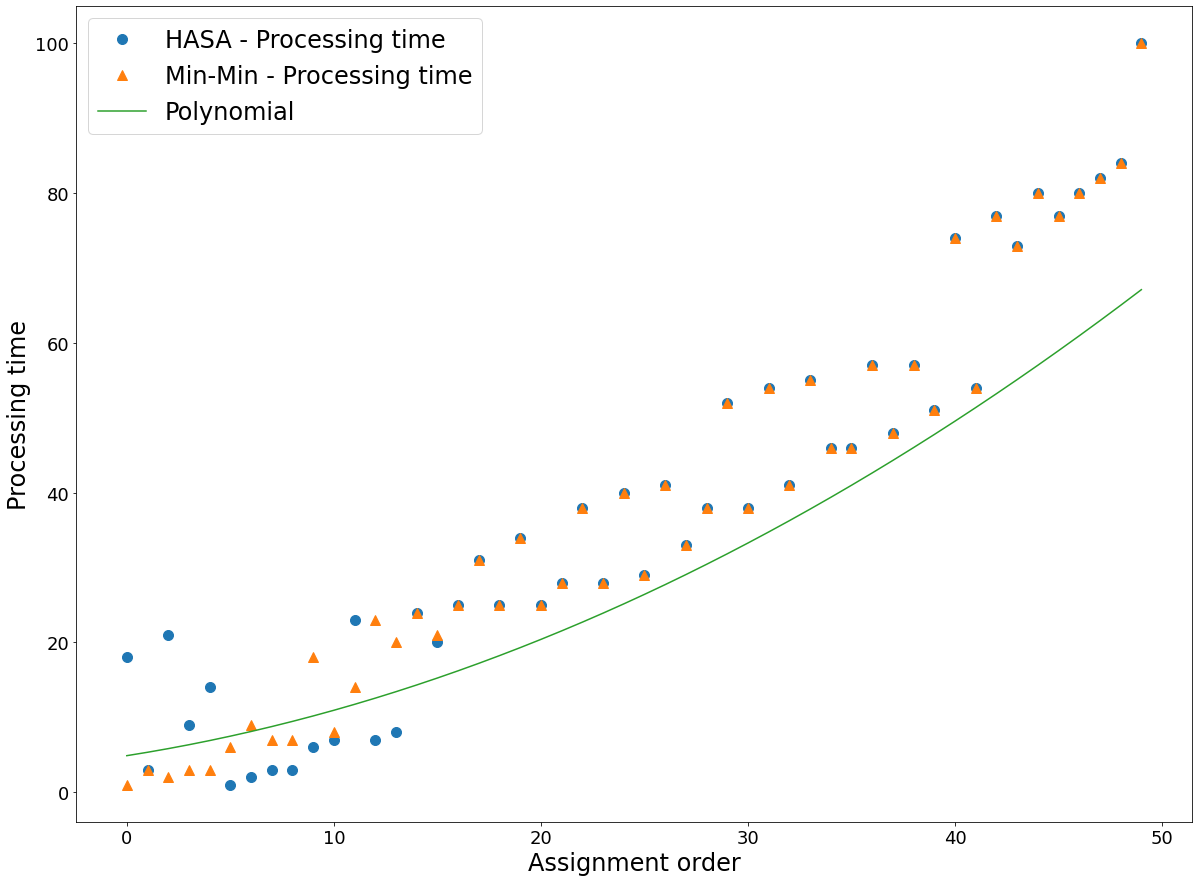

dataset: ./all_data/2x50-3.csv
Min-Min makespan: 977
process: [1, 2, 4, 5, 4, 6, 7, 8, 8, 10, 17, 17, 21, 22, 23, 24, 25, 25, 28, 29, 34, 34, 34, 37, 35, 38, 37, 38, 39, 39, 41, 46, 47, 48, 47, 52, 50, 55, 55, 60, 57, 60, 65, 66, 65, 74, 80, 85, 83, 96]

HASA makespan: 977
process: [17, 22, 6, 4, 4, 21, 1, 2, 8, 5, 7, 10, 8, 17, 23, 24, 25, 25, 28, 29, 34, 34, 34, 37, 35, 38, 37, 38, 39, 39, 41, 46, 47, 48, 47, 52, 50, 55, 55, 60, 57, 60, 65, 66, 65, 74, 80, 85, 83, 96]

Poly makespan: 977
process: [6, 7, 1, 4, 2, 4, 5, 8, 8, 10, 17, 17, 21, 22, 23, 24, 25, 25, 28, 29, 34, 34, 34, 37, 35, 38, 37, 38, 39, 39, 41, 46, 47, 48, 47, 52, 50, 55, 55, 60, 57, 60, 65, 66, 65, 74, 80, 85, 83, 96]





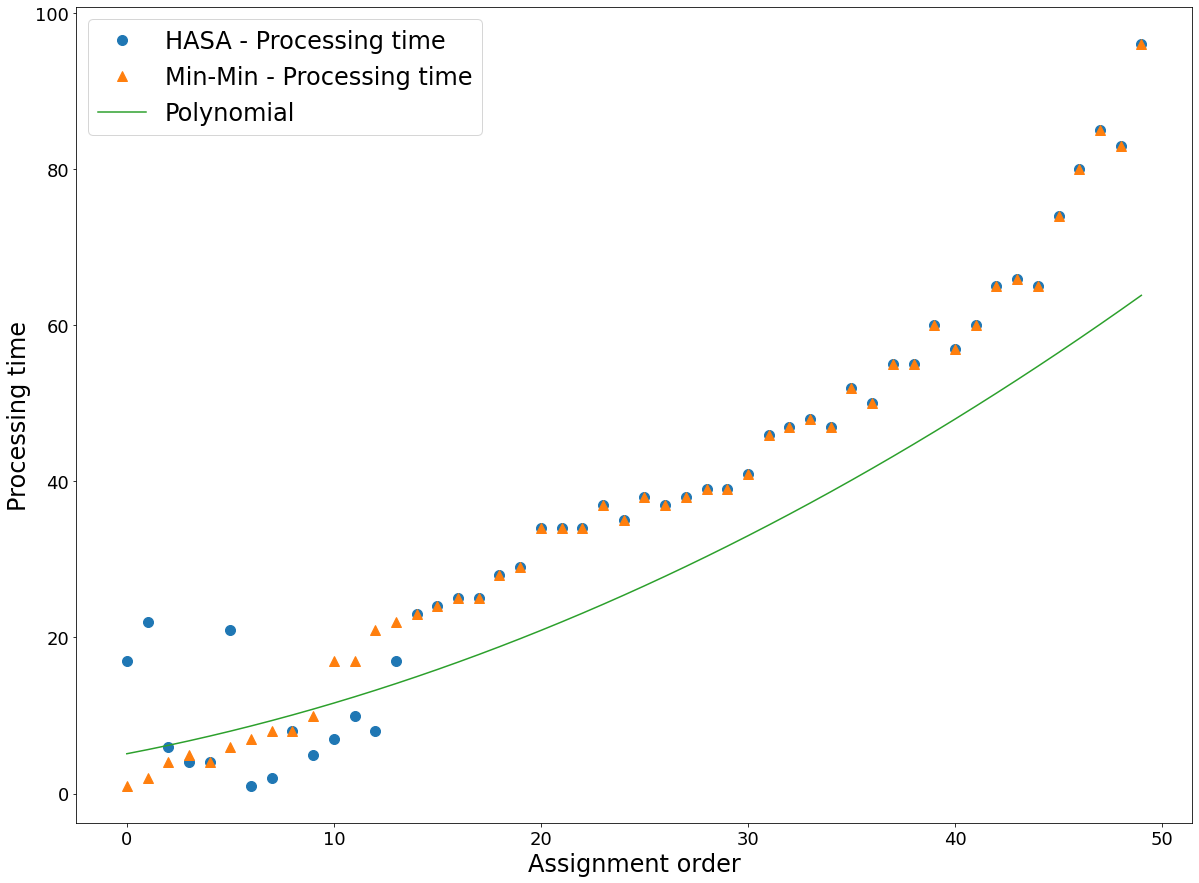

dataset: ./all_data/2x50-4.csv
Min-Min makespan: 986
process: [2, 4, 3, 5, 6, 11, 7, 11, 11, 13, 13, 14, 17, 17, 19, 19, 20, 22, 21, 22, 28, 35, 34, 36, 35, 38, 35, 41, 54, 41, 55, 44, 56, 51, 55, 57, 56, 58, 56, 60, 68, 61, 63, 75, 74, 75, 76, 90, 96, 91]

HASA makespan: 1011
process: [19, 5, 25, 7, 4, 11, 3, 2, 6, 11, 11, 13, 17, 14, 20, 17, 21, 19, 22, 28, 22, 34, 35, 35, 36, 35, 38, 54, 41, 41, 55, 44, 56, 51, 57, 55, 58, 56, 60, 56, 61, 68, 63, 75, 74, 75, 76, 90, 96, 91]

Poly makespan: 986
process: [5, 3, 2, 4, 6, 11, 7, 11, 11, 13, 13, 14, 17, 17, 19, 19, 20, 22, 21, 22, 28, 35, 34, 36, 35, 38, 35, 41, 54, 41, 55, 44, 56, 51, 55, 57, 56, 58, 56, 60, 68, 61, 63, 75, 74, 75, 76, 90, 96, 91]





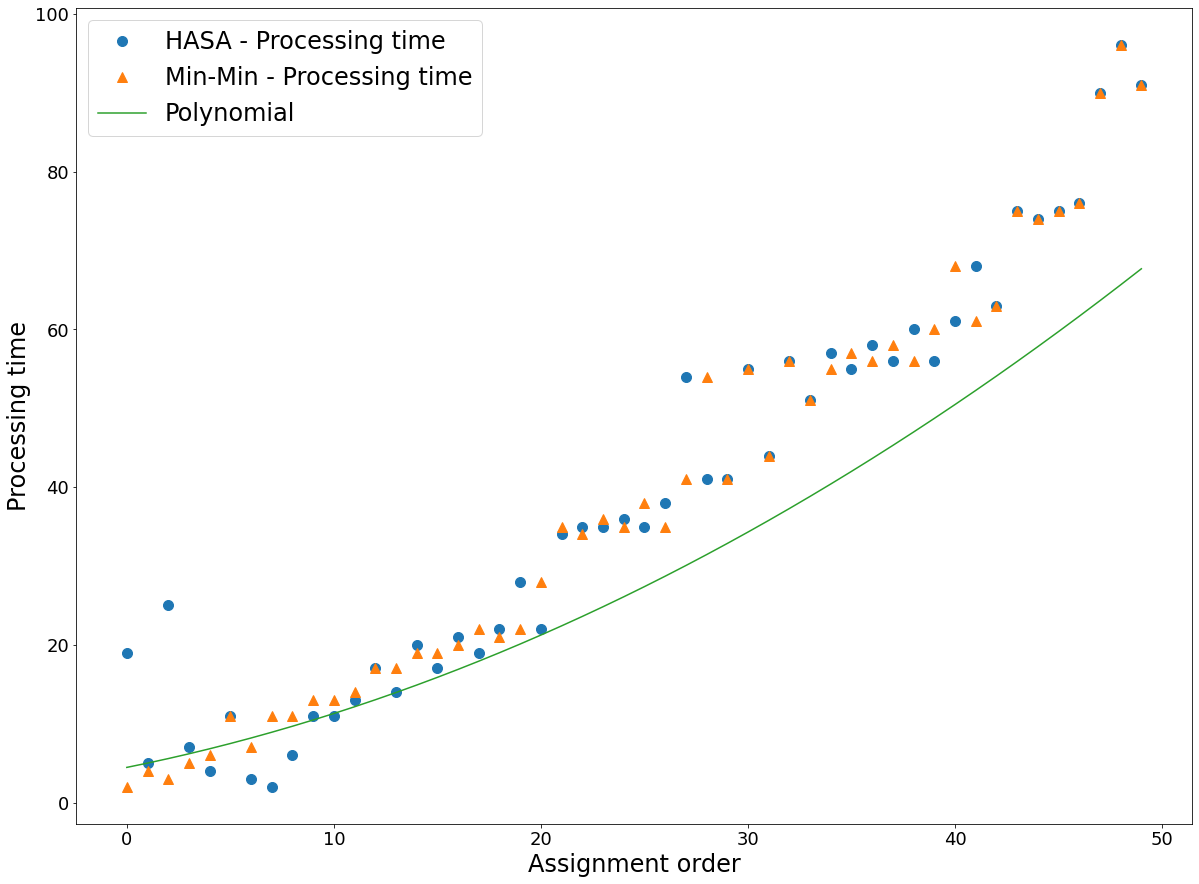

dataset: ./all_data/2x50-5.csv
Min-Min makespan: 895
process: [1, 2, 2, 6, 3, 4, 5, 10, 6, 11, 7, 7, 8, 17, 13, 24, 15, 17, 26, 17, 18, 33, 19, 33, 23, 26, 36, 33, 37, 37, 39, 39, 50, 39, 51, 45, 49, 68, 50, 69, 50, 74, 57, 67, 75, 71, 87, 72, 90, 94]

HASA makespan: 898
process: [17, 19, 8, 2, 2, 11, 6, 1, 5, 3, 6, 10, 7, 7, 7, 24, 13, 15, 26, 17, 33, 17, 18, 33, 23, 26, 36, 33, 37, 37, 39, 39, 50, 39, 51, 45, 61, 50, 50, 68, 57, 69, 67, 74, 71, 75, 72, 87, 94, 90]

Poly makespan: 895
process: [5, 6, 2, 1, 2, 3, 4, 10, 6, 11, 7, 7, 8, 17, 13, 24, 15, 17, 26, 17, 18, 33, 19, 33, 23, 26, 36, 33, 37, 37, 39, 39, 50, 39, 51, 45, 49, 68, 50, 69, 50, 74, 57, 67, 75, 71, 87, 72, 90, 94]





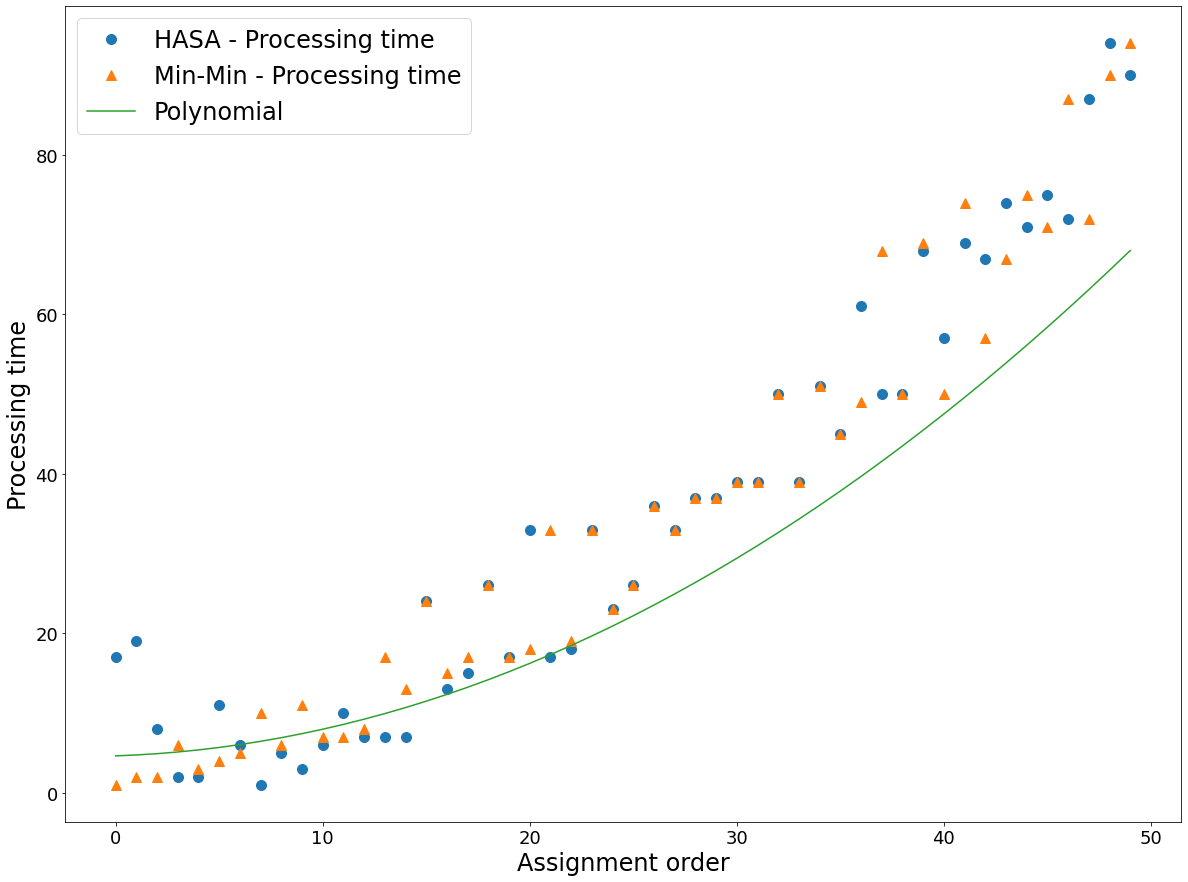

dataset: ./all_data/400x10-1.csv
Min-Min makespan: 451
process: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 3, 3, 3, 2, 3, 2, 2, 3, 3, 2, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 5, 4, 3, 3, 4, 3, 3, 4, 4, 4, 4, 4, 5, 5, 4, 4, 5, 5, 4, 4, 4, 4, 4, 4, 5, 6, 5, 4, 4, 4, 5, 4, 4, 4, 6, 5, 4, 5, 4, 4, 5, 6, 5, 4, 4, 4, 5, 5, 5, 6, 5, 5, 6, 6, 5, 5, 5, 5, 6, 6, 6, 5, 7, 5, 6, 6, 5, 7, 6, 6, 6, 7, 6, 7, 6, 8, 7, 6, 7, 6, 7, 7, 6, 7, 8, 7, 6, 8, 6, 8, 7, 6, 8, 7, 7, 7, 8, 7, 8, 7, 6, 9, 8, 8, 7, 8, 8, 8, 7, 9, 8, 7, 10, 9, 8, 8, 9, 7, 8, 8, 10, 9, 9, 9, 10, 9, 9, 8, 12, 8, 12, 10, 9, 10, 9, 10, 9, 10, 10, 12, 9, 10, 12, 9, 10, 9, 10, 12, 12, 12, 9, 12, 10, 11, 10, 11, 15, 13, 12, 9, 12, 11, 11, 12, 12, 12, 11, 12, 15, 14, 12, 11, 11, 12, 13, 13, 12, 14, 13, 15, 12, 12, 12, 17, 13, 12, 14, 14, 13, 1

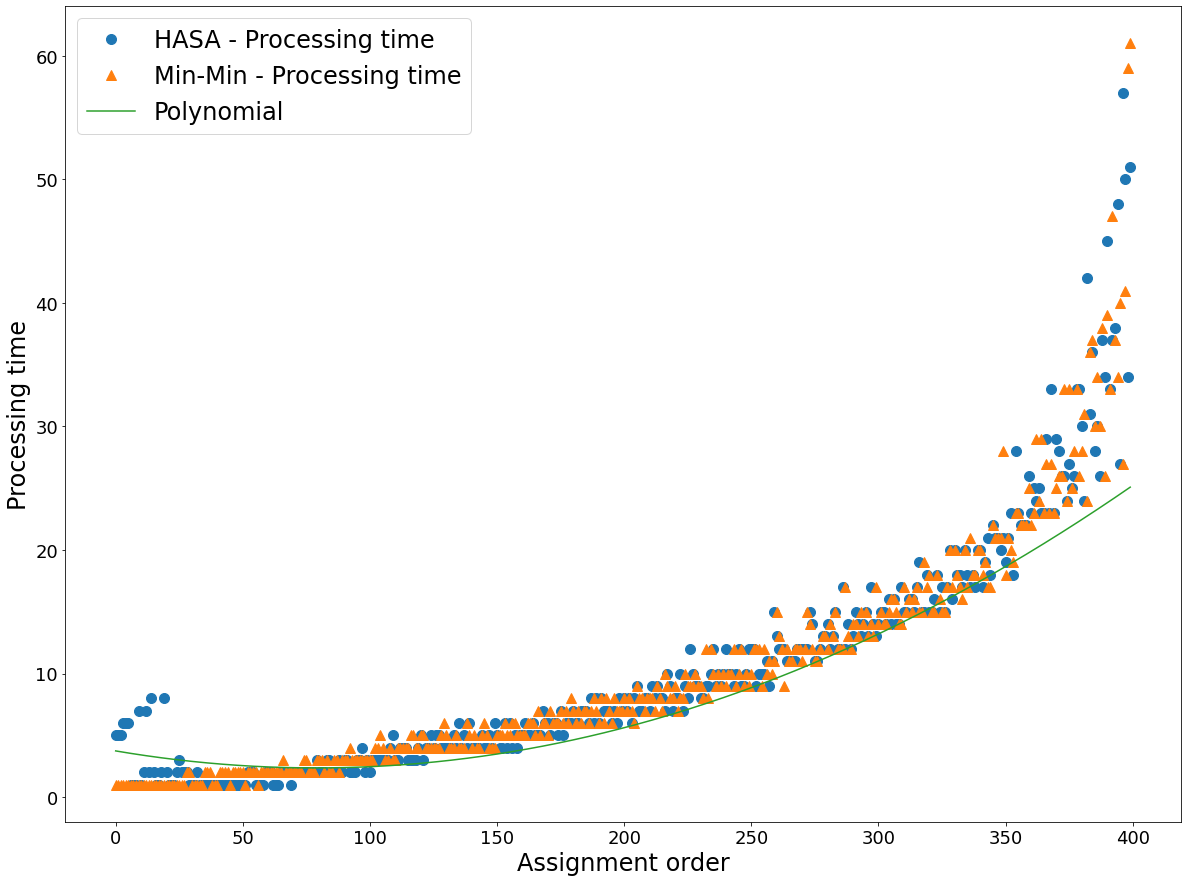

dataset: ./all_data/400x10-2.csv
Min-Min makespan: 416
process: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 3, 3, 2, 2, 2, 2, 3, 2, 2, 2, 3, 3, 3, 2, 3, 2, 2, 2, 4, 3, 2, 2, 3, 3, 3, 3, 3, 4, 2, 3, 3, 4, 3, 3, 3, 2, 3, 3, 4, 3, 2, 4, 3, 3, 3, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 5, 3, 4, 4, 4, 5, 4, 3, 4, 5, 4, 5, 5, 6, 4, 3, 5, 5, 4, 5, 6, 3, 5, 4, 6, 6, 3, 5, 5, 6, 5, 5, 5, 6, 4, 6, 5, 5, 7, 6, 6, 4, 6, 6, 7, 6, 5, 6, 4, 7, 6, 6, 6, 6, 5, 5, 6, 7, 6, 6, 7, 6, 8, 7, 5, 7, 6, 7, 6, 6, 6, 8, 7, 7, 7, 8, 7, 9, 8, 7, 6, 7, 7, 8, 8, 7, 9, 8, 7, 8, 10, 7, 8, 7, 9, 8, 7, 9, 8, 9, 8, 11, 9, 8, 8, 9, 8, 9, 10, 11, 10, 8, 8, 9, 11, 9, 10, 12, 10, 9, 10, 11, 10, 11, 12, 10, 10, 10, 10, 13, 10, 10, 12, 12, 13, 11, 14, 10, 11, 10, 11, 14, 13, 12, 11, 11, 13, 10, 11, 12, 16, 15, 13, 14, 11, 11, 13, 13, 13, 12, 1

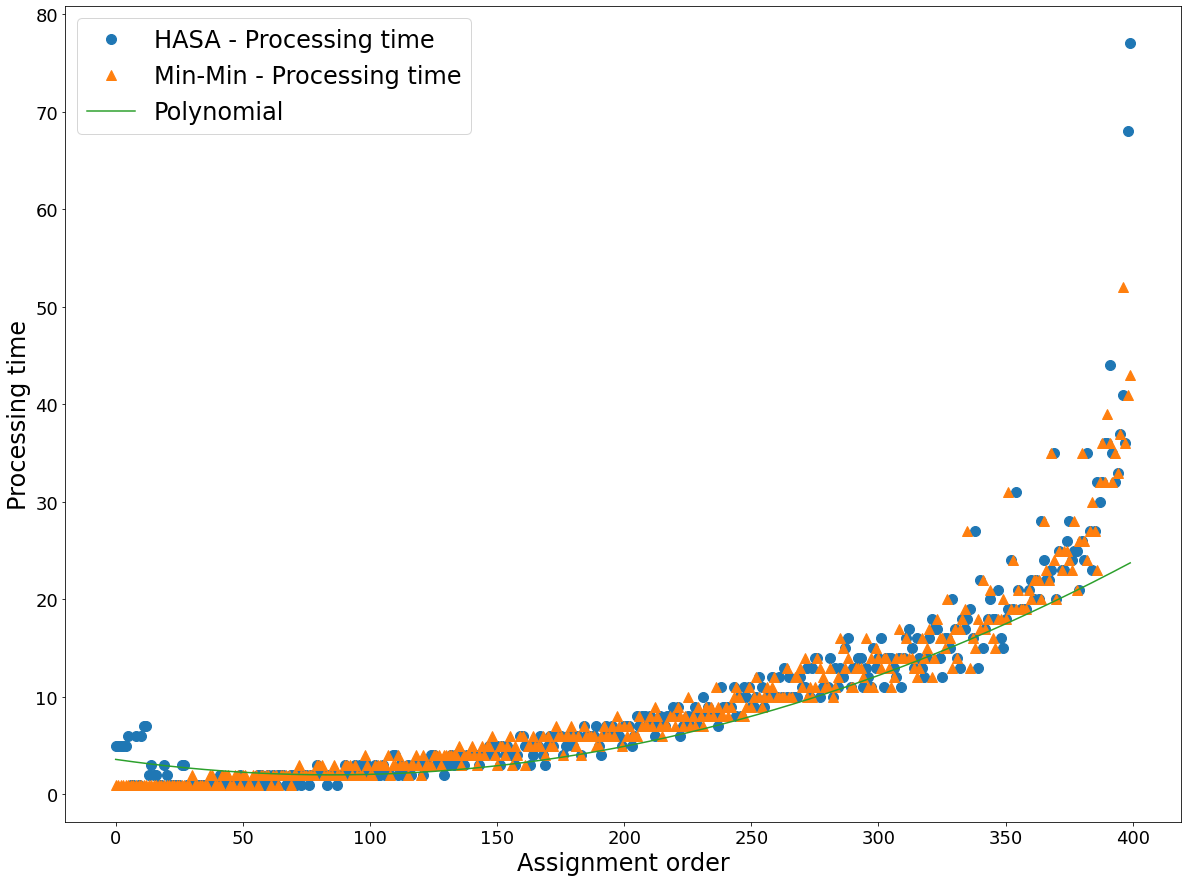

dataset: ./all_data/400x10-3.csv
Min-Min makespan: 421
process: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 3, 3, 3, 2, 3, 3, 2, 2, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 4, 3, 3, 4, 3, 3, 4, 3, 3, 3, 3, 3, 4, 4, 4, 4, 3, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 5, 4, 4, 5, 5, 5, 5, 4, 4, 5, 4, 5, 5, 4, 6, 4, 5, 6, 5, 5, 5, 4, 5, 5, 5, 6, 6, 6, 6, 5, 5, 4, 5, 6, 6, 4, 6, 6, 6, 6, 7, 6, 5, 6, 6, 5, 7, 6, 7, 5, 7, 8, 7, 6, 7, 7, 5, 6, 7, 7, 7, 7, 8, 6, 6, 7, 9, 8, 8, 8, 7, 6, 8, 6, 8, 10, 9, 9, 8, 6, 8, 8, 6, 9, 9, 7, 7, 8, 8, 9, 10, 10, 11, 10, 10, 7, 7, 8, 10, 9, 10, 11, 8, 12, 8, 10, 10, 8, 9, 8, 11, 12, 11, 8, 11, 12, 10, 9, 9, 8, 9, 12, 11, 13, 10, 11, 10, 12, 8, 14, 9, 12, 13, 11, 13, 12, 11, 12, 12, 9, 14, 11, 13, 9, 13, 12, 13, 13, 14, 16, 15, 11, 12, 1

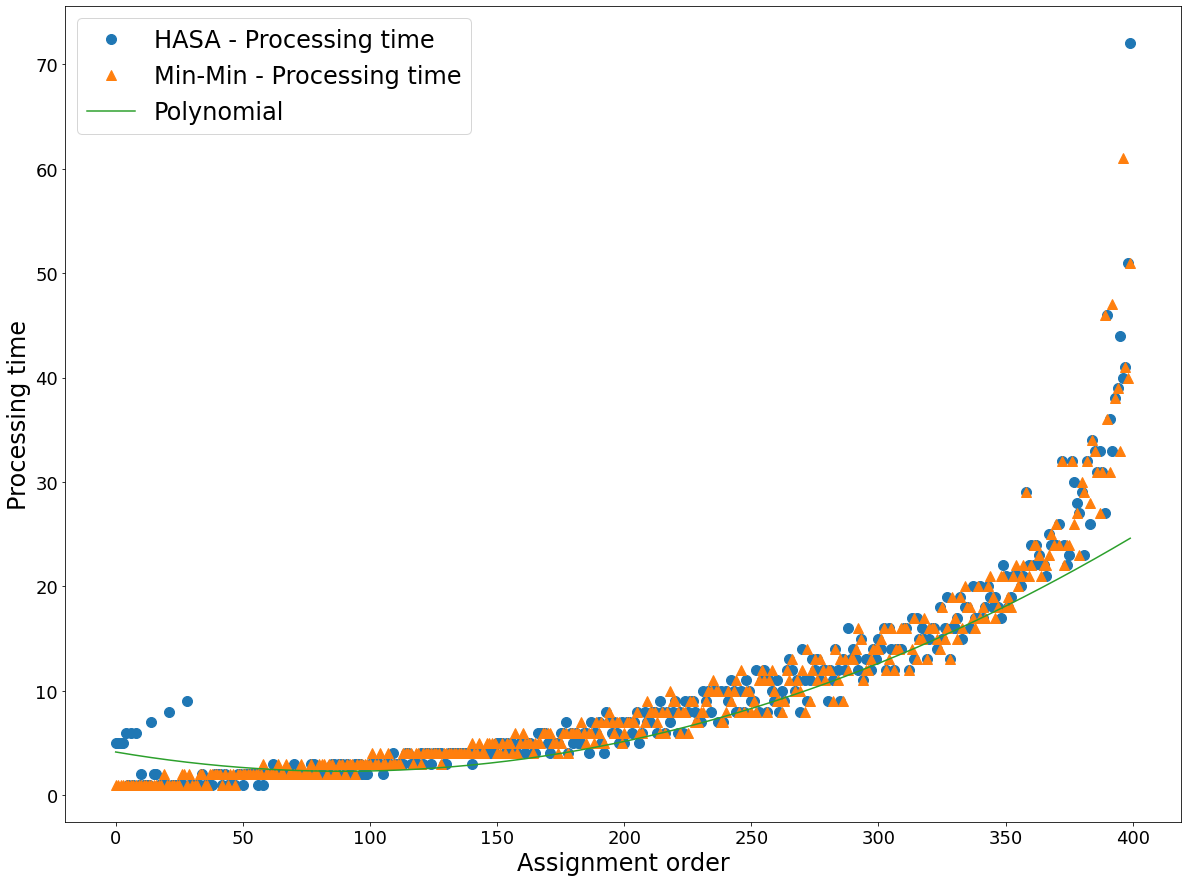

dataset: ./all_data/400x10-4.csv
Min-Min makespan: 435
process: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 3, 2, 2, 3, 2, 3, 2, 3, 3, 3, 3, 2, 4, 3, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 4, 3, 2, 4, 4, 3, 3, 3, 4, 3, 4, 3, 4, 3, 4, 4, 4, 5, 4, 3, 4, 4, 3, 4, 4, 4, 4, 4, 5, 3, 4, 6, 5, 4, 4, 3, 4, 6, 5, 4, 5, 5, 5, 4, 4, 6, 4, 5, 5, 6, 6, 4, 5, 5, 5, 5, 7, 5, 5, 6, 6, 5, 6, 5, 6, 7, 5, 5, 6, 5, 6, 7, 7, 10, 7, 5, 7, 5, 6, 6, 6, 5, 8, 7, 5, 8, 10, 6, 7, 8, 6, 7, 6, 7, 8, 6, 8, 6, 7, 8, 6, 10, 9, 8, 7, 9, 6, 7, 8, 7, 8, 9, 7, 10, 6, 9, 7, 9, 8, 8, 8, 7, 7, 10, 7, 9, 10, 9, 10, 8, 7, 8, 7, 8, 10, 9, 11, 7, 8, 7, 10, 10, 9, 10, 8, 10, 8, 10, 9, 11, 12, 11, 10, 8, 10, 8, 10, 11, 11, 10, 11, 12, 12, 9, 9, 11, 10, 13, 11, 11, 12, 9, 10, 12, 13, 10, 12, 9, 11, 10, 12, 13, 13, 11, 13, 12, 14, 10, 10, 11, 12, 13, 11, 15, 10, 15, 14, 14, 11, 12, 12, 12

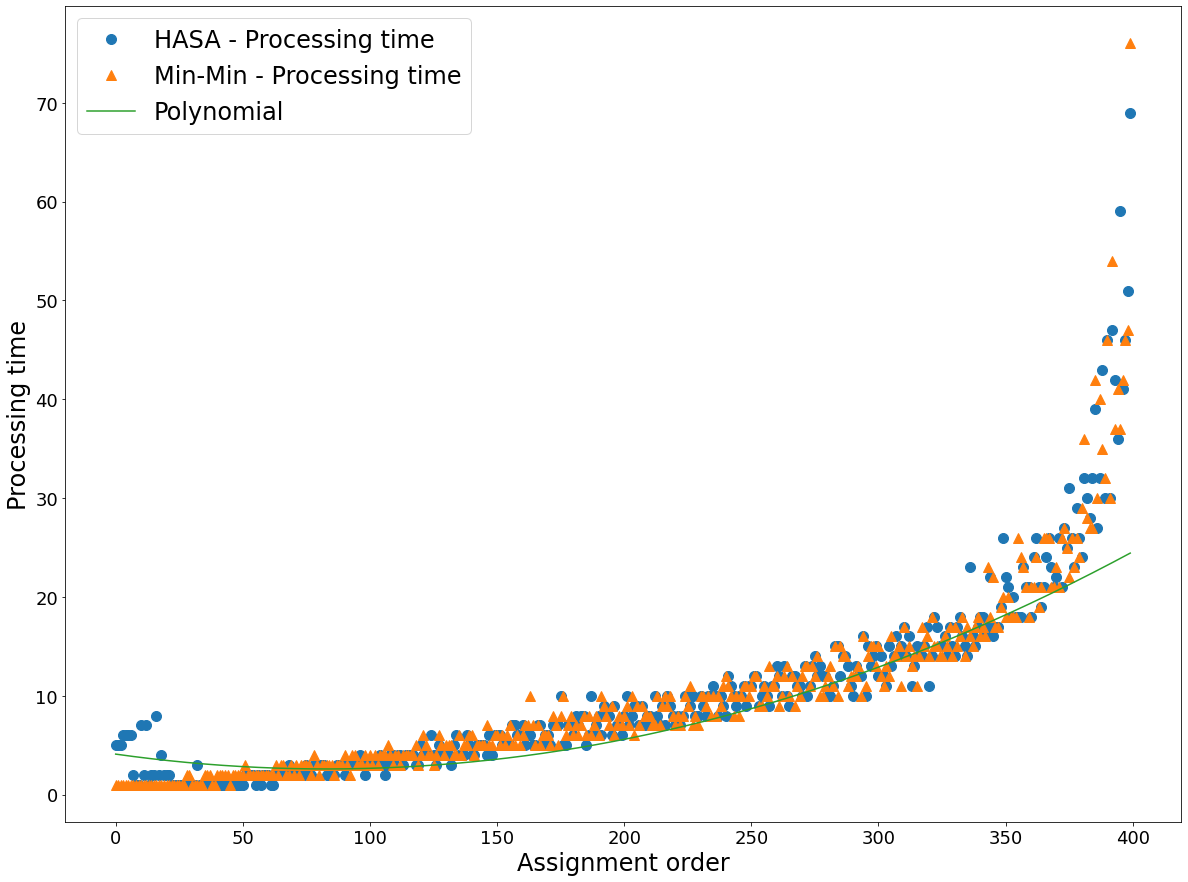

dataset: ./all_data/400x10-5.csv
Min-Min makespan: 420
process: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 4, 2, 3, 3, 2, 2, 2, 3, 3, 3, 3, 2, 2, 3, 3, 3, 4, 3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 4, 5, 4, 4, 3, 3, 4, 3, 3, 3, 4, 3, 3, 5, 4, 3, 5, 4, 4, 3, 5, 4, 4, 4, 4, 4, 5, 4, 5, 4, 4, 5, 5, 4, 5, 5, 5, 4, 5, 5, 5, 7, 5, 6, 5, 5, 5, 6, 6, 5, 6, 5, 6, 5, 7, 5, 6, 6, 6, 5, 7, 6, 7, 6, 5, 8, 6, 6, 6, 6, 6, 6, 6, 7, 8, 6, 8, 7, 6, 6, 6, 6, 6, 7, 7, 9, 7, 7, 8, 6, 8, 7, 7, 7, 7, 7, 7, 9, 7, 8, 7, 9, 9, 8, 8, 7, 9, 8, 8, 9, 8, 9, 8, 10, 8, 10, 8, 9, 9, 9, 9, 8, 8, 10, 12, 9, 10, 10, 9, 9, 8, 10, 9, 11, 9, 12, 10, 9, 9, 10, 10, 10, 9, 11, 9, 10, 9, 11, 10, 10, 10, 11, 13, 10, 10, 10, 13, 11, 11, 11, 10, 11, 13, 10, 12, 10, 12, 14, 12, 11, 13, 11, 13, 10, 12, 15, 11, 12, 11, 13, 14, 14, 11, 13, 12, 12, 11, 12, 16, 14

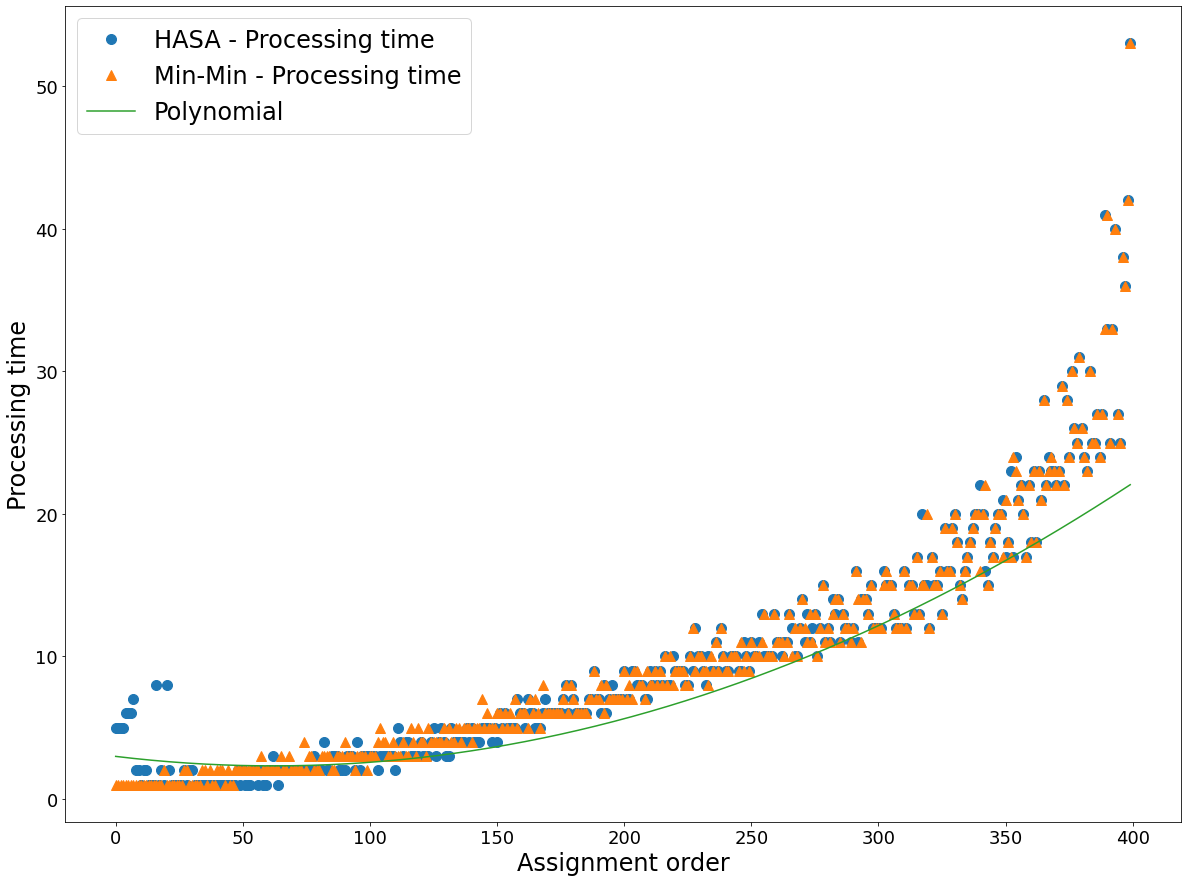

dataset: ./all_data/4x50-1.csv
Min-Min makespan: 307
process: [1, 1, 3, 3, 4, 4, 6, 6, 4, 11, 6, 6, 15, 8, 7, 14, 11, 15, 15, 13, 21, 18, 19, 14, 22, 19, 23, 20, 24, 26, 21, 29, 30, 26, 29, 34, 31, 34, 31, 35, 33, 40, 42, 46, 41, 42, 48, 53, 75, 62]

HASA makespan: 307
process: [11, 14, 15, 1, 15, 4, 3, 7, 3, 6, 1, 6, 4, 11, 4, 6, 6, 15, 8, 13, 21, 18, 19, 14, 22, 19, 23, 20, 24, 26, 21, 29, 30, 26, 29, 34, 31, 34, 31, 35, 33, 40, 42, 46, 41, 42, 48, 53, 75, 62]

Poly makespan: 307
process: [6, 6, 6, 1, 4, 1, 3, 3, 4, 11, 6, 4, 15, 8, 7, 14, 11, 15, 15, 13, 21, 18, 19, 14, 22, 19, 23, 20, 24, 26, 21, 29, 30, 26, 29, 34, 31, 34, 31, 35, 33, 40, 42, 46, 41, 42, 48, 53, 75, 62]





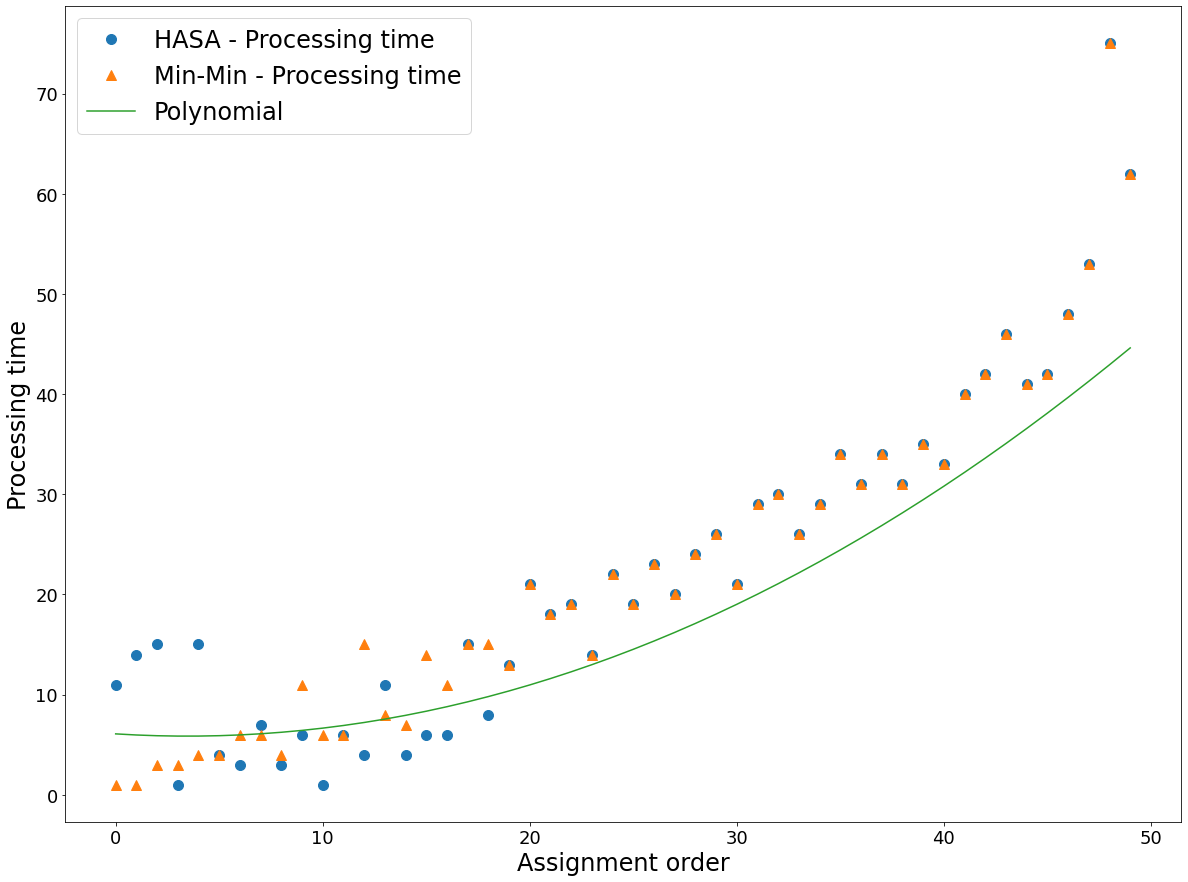

dataset: ./all_data/4x50-2.csv
Min-Min makespan: 283
process: [1, 1, 2, 2, 3, 5, 6, 8, 7, 9, 8, 8, 10, 10, 9, 14, 10, 10, 11, 11, 14, 12, 15, 16, 16, 15, 17, 19, 19, 22, 18, 24, 21, 19, 32, 25, 22, 32, 32, 22, 33, 34, 27, 44, 50, 43, 42, 45, 54, 89]

HASA makespan: 283
process: [10, 11, 1, 1, 2, 14, 15, 3, 5, 6, 8, 1, 7, 9, 8, 10, 8, 10, 11, 14, 9, 10, 15, 16, 16, 12, 17, 17, 23, 22, 18, 21, 24, 19, 32, 32, 22, 25, 32, 22, 33, 34, 27, 44, 43, 50, 42, 45, 54, 89]

Poly makespan: 283
process: [7, 8, 6, 1, 5, 2, 1, 3, 2, 9, 8, 8, 10, 10, 9, 14, 10, 10, 11, 11, 14, 12, 15, 16, 16, 15, 17, 19, 19, 22, 18, 24, 21, 19, 32, 25, 22, 32, 32, 22, 33, 34, 27, 44, 50, 43, 42, 45, 54, 89]





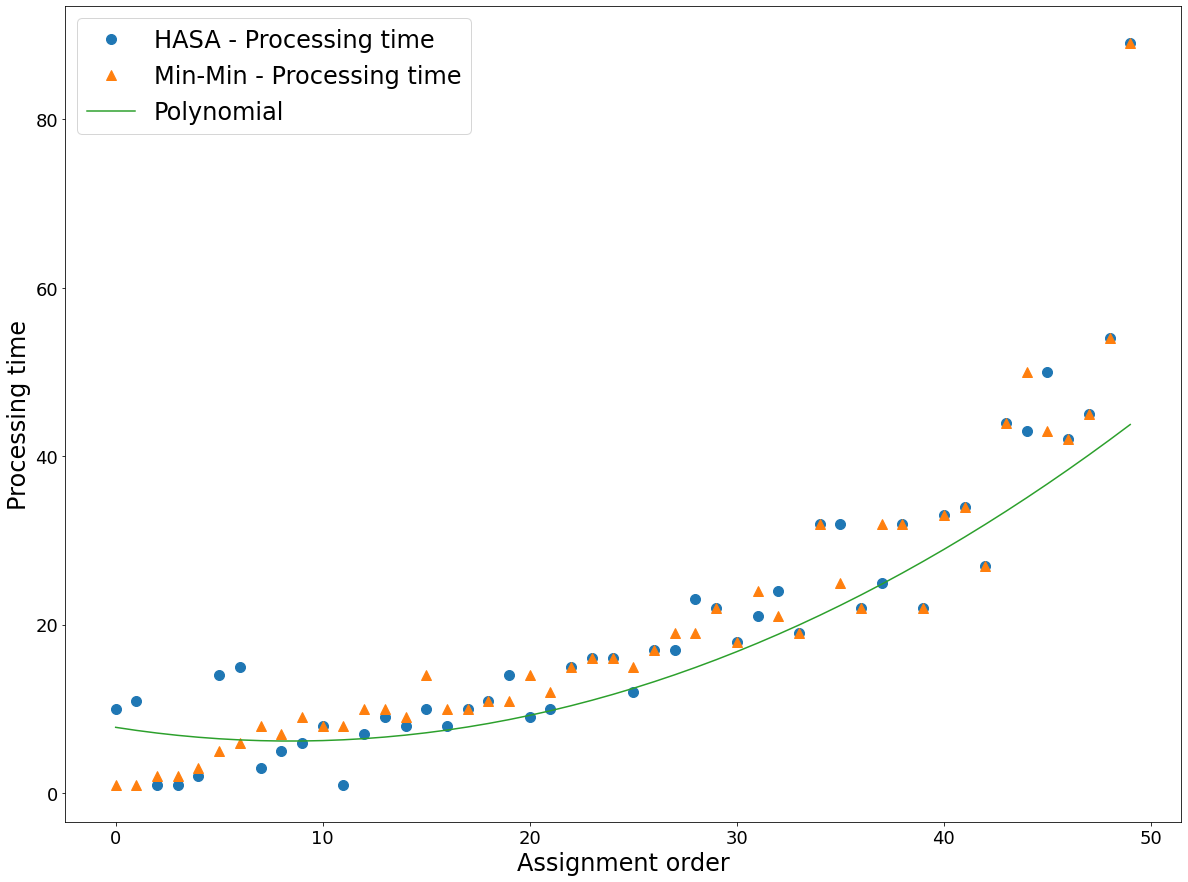

dataset: ./all_data/4x50-3.csv
Min-Min makespan: 289
process: [1, 2, 3, 3, 2, 5, 3, 3, 5, 4, 4, 7, 5, 4, 9, 6, 5, 11, 8, 10, 11, 11, 12, 11, 15, 14, 12, 19, 12, 21, 20, 14, 22, 23, 26, 19, 25, 32, 33, 34, 32, 36, 34, 37, 38, 44, 68, 45, 44, 76]

HASA makespan: 289
process: [9, 10, 11, 12, 4, 4, 2, 3, 1, 3, 11, 5, 5, 3, 4, 5, 3, 7, 5, 4, 6, 11, 11, 8, 15, 12, 14, 19, 12, 21, 20, 14, 22, 23, 19, 26, 25, 32, 33, 34, 32, 36, 34, 37, 38, 68, 44, 45, 44, 76]

Poly makespan: 289
process: [7, 6, 5, 4, 1, 2, 3, 2, 3, 3, 3, 5, 5, 4, 9, 5, 4, 11, 8, 10, 11, 11, 12, 11, 15, 14, 12, 19, 12, 21, 20, 14, 22, 23, 26, 19, 25, 32, 33, 34, 32, 36, 34, 37, 38, 44, 68, 45, 44, 76]





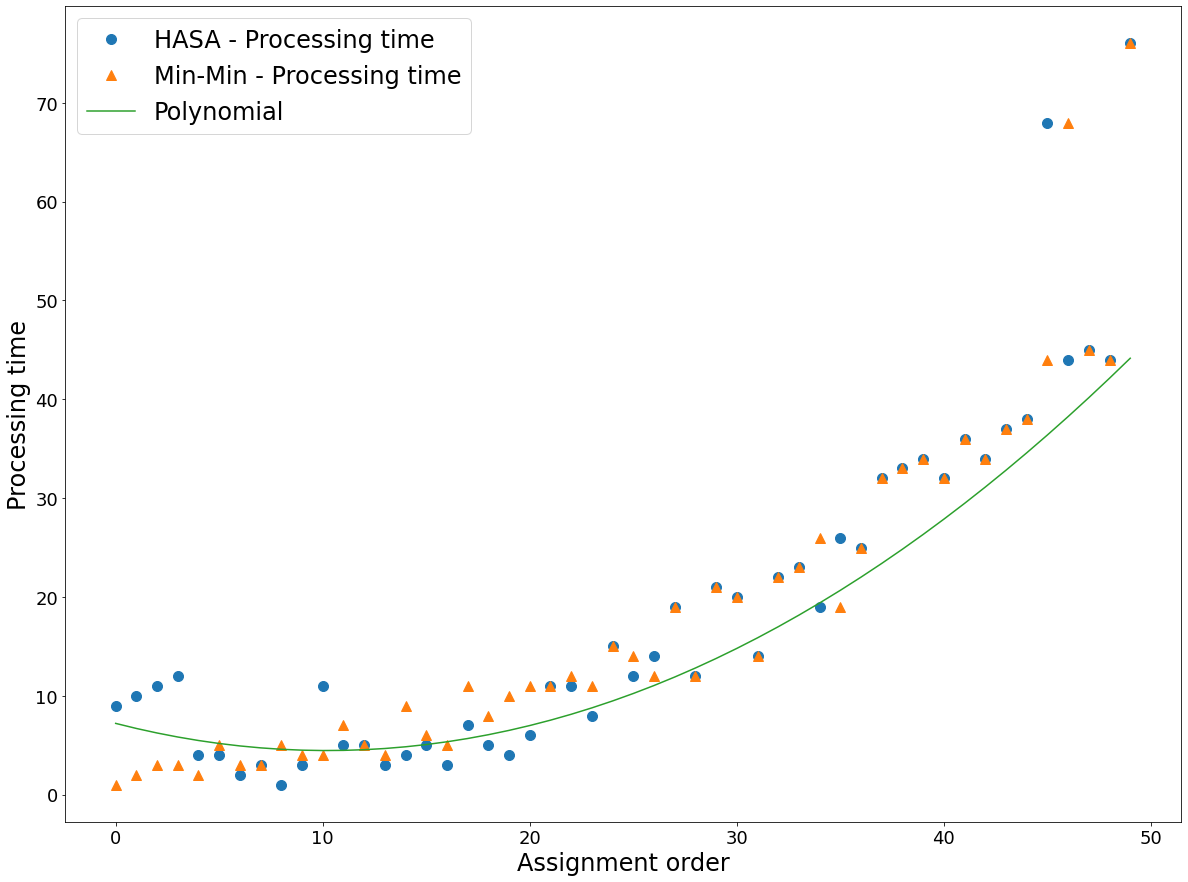

dataset: ./all_data/4x50-4.csv
Min-Min makespan: 269
process: [1, 1, 1, 1, 1, 2, 2, 4, 3, 3, 3, 5, 3, 7, 4, 10, 7, 8, 6, 7, 8, 12, 16, 16, 9, 15, 17, 17, 14, 22, 15, 20, 25, 19, 28, 26, 28, 25, 29, 28, 35, 36, 36, 46, 47, 43, 60, 49, 60, 88]

HASA makespan: 266
process: [9, 10, 2, 12, 2, 14, 7, 4, 1, 4, 7, 3, 1, 1, 5, 3, 3, 16, 1, 6, 7, 3, 8, 8, 15, 17, 16, 14, 17, 22, 15, 25, 20, 19, 28, 28, 25, 26, 29, 28, 35, 36, 36, 46, 37, 56, 43, 60, 60, 90]

Poly makespan: 269
process: [7, 6, 5, 1, 3, 2, 1, 1, 1, 4, 1, 2, 3, 3, 10, 7, 3, 4, 8, 7, 8, 12, 16, 16, 9, 15, 17, 17, 14, 22, 15, 20, 25, 19, 28, 26, 28, 25, 29, 28, 35, 36, 36, 46, 47, 43, 60, 49, 60, 88]





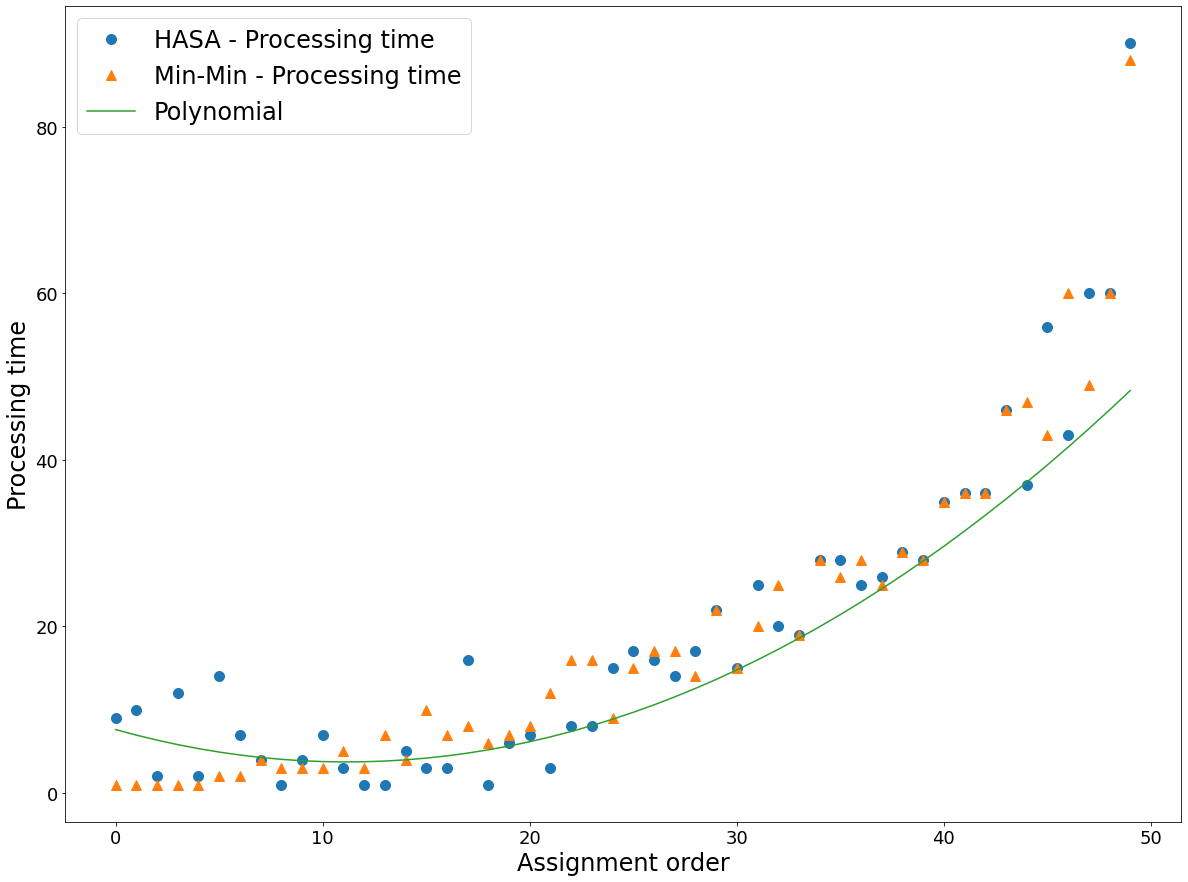

dataset: ./all_data/4x50-5.csv
Min-Min makespan: 339
process: [1, 1, 1, 2, 2, 2, 2, 3, 5, 8, 3, 8, 6, 5, 6, 6, 10, 6, 8, 11, 23, 10, 12, 12, 12, 12, 25, 18, 18, 15, 15, 24, 29, 22, 34, 35, 46, 45, 47, 46, 49, 82, 47, 55, 57, 53, 86, 57, 65, 68]

HASA makespan: 360
process: [12, 1, 13, 1, 2, 2, 12, 6, 2, 5, 2, 23, 1, 3, 6, 11, 3, 8, 6, 5, 8, 6, 8, 12, 10, 14, 23, 18, 15, 24, 25, 15, 21, 22, 34, 45, 46, 35, 46, 49, 47, 82, 57, 55, 47, 86, 65, 57, 53, 68]

Poly makespan: 339
process: [5, 5, 1, 2, 1, 1, 2, 2, 2, 8, 8, 3, 6, 3, 6, 6, 10, 6, 8, 11, 23, 10, 12, 12, 12, 12, 25, 18, 18, 15, 15, 24, 29, 22, 34, 35, 46, 45, 47, 46, 49, 82, 47, 55, 57, 53, 86, 57, 65, 68]





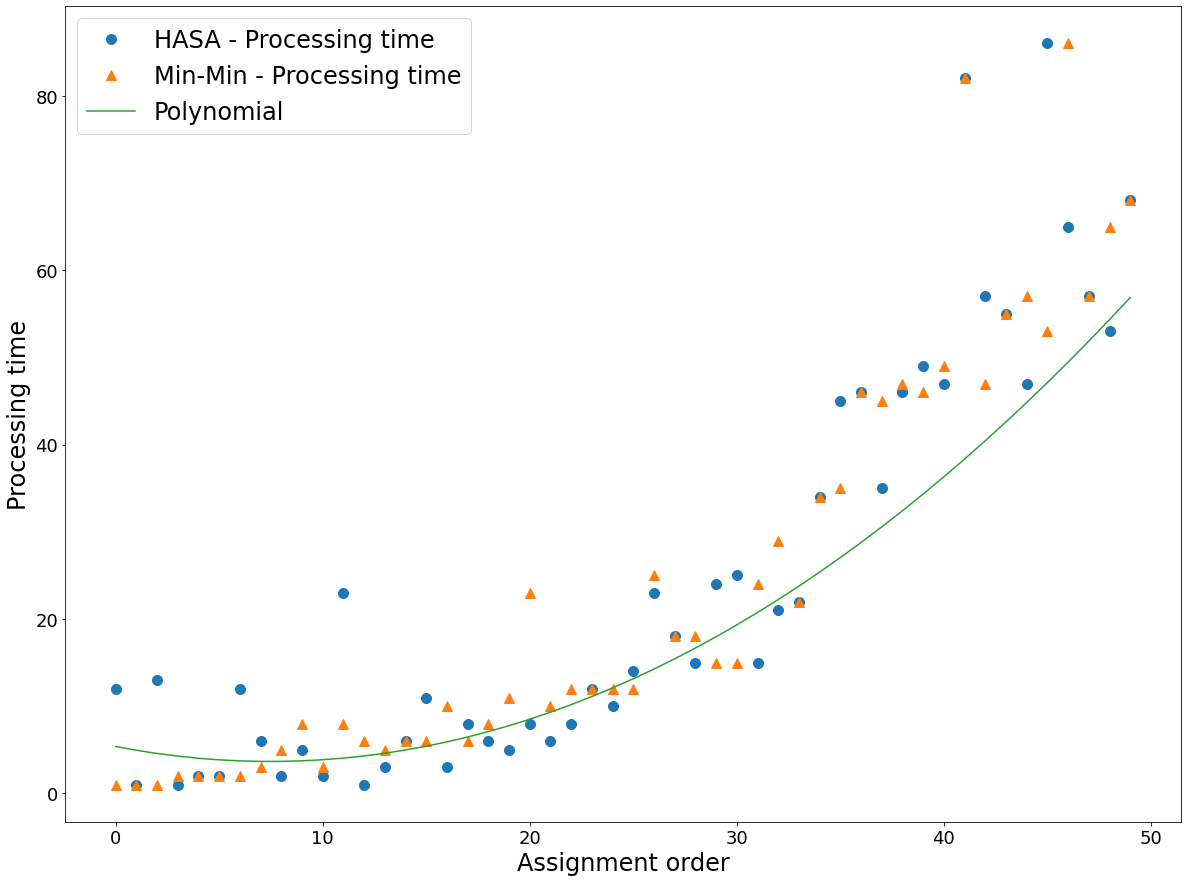

dataset: ./all_data/5x20-1.csv
Min-Min makespan: 139
process: [1, 2, 2, 5, 7, 9, 7, 8, 19, 11, 27, 25, 20, 40, 30, 29, 46, 48, 41, 41]

HASA makespan: 110
process: [11, 2, 9, 8, 18, 8, 23, 4, 7, 27, 19, 7, 29, 20, 43, 36, 40, 39, 60, 46]

Poly makespan: 115
process: [5, 7, 4, 2, 2, 7, 14, 8, 11, 27, 25, 19, 20, 40, 30, 43, 48, 39, 41, 46]





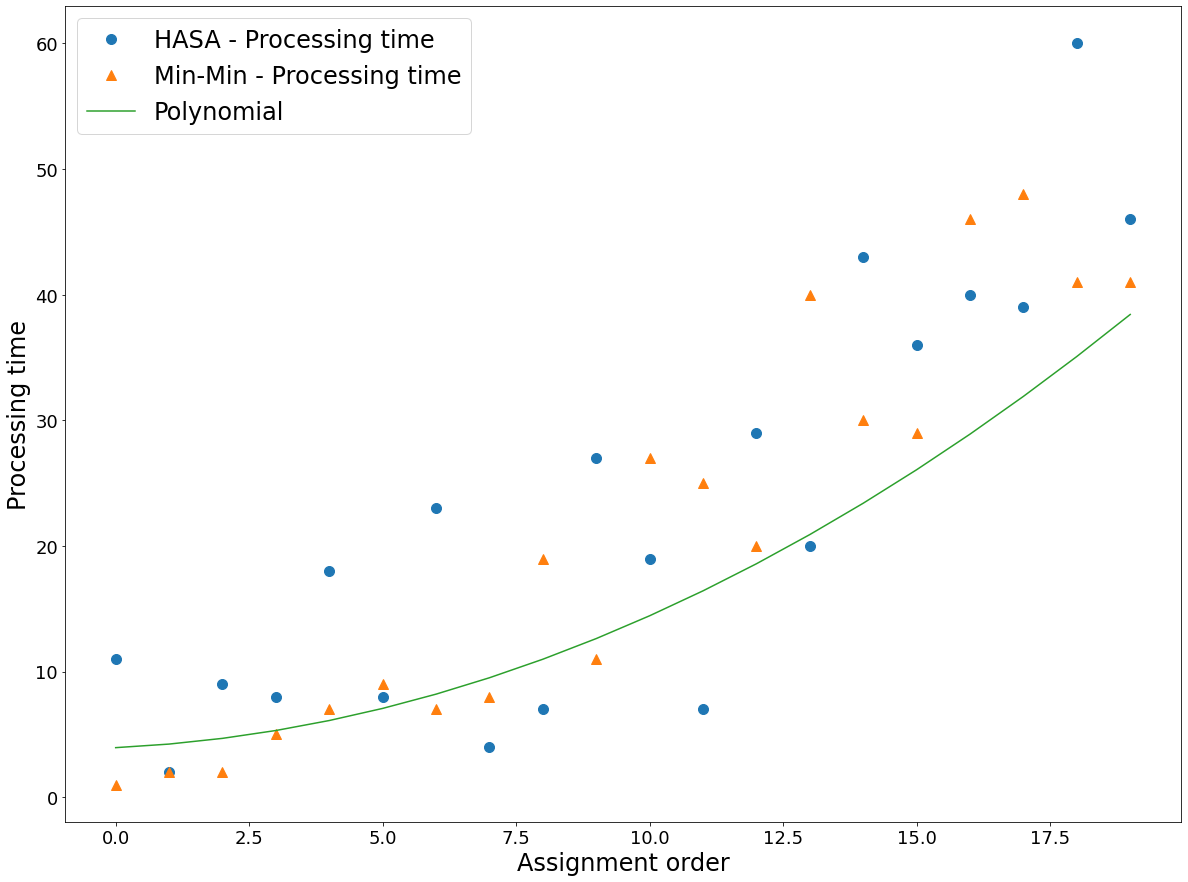

dataset: ./all_data/5x20-2.csv
Min-Min makespan: 103
process: [1, 1, 3, 4, 6, 9, 13, 13, 12, 12, 20, 16, 12, 28, 20, 26, 36, 55, 33, 49]

HASA makespan: 103
process: [9, 1, 12, 13, 13, 1, 3, 20, 12, 4, 6, 16, 12, 28, 20, 26, 36, 55, 33, 49]

Poly makespan: 98
process: [6, 4, 1, 3, 1, 12, 13, 13, 12, 12, 20, 12, 22, 20, 26, 31, 29, 55, 29, 49]





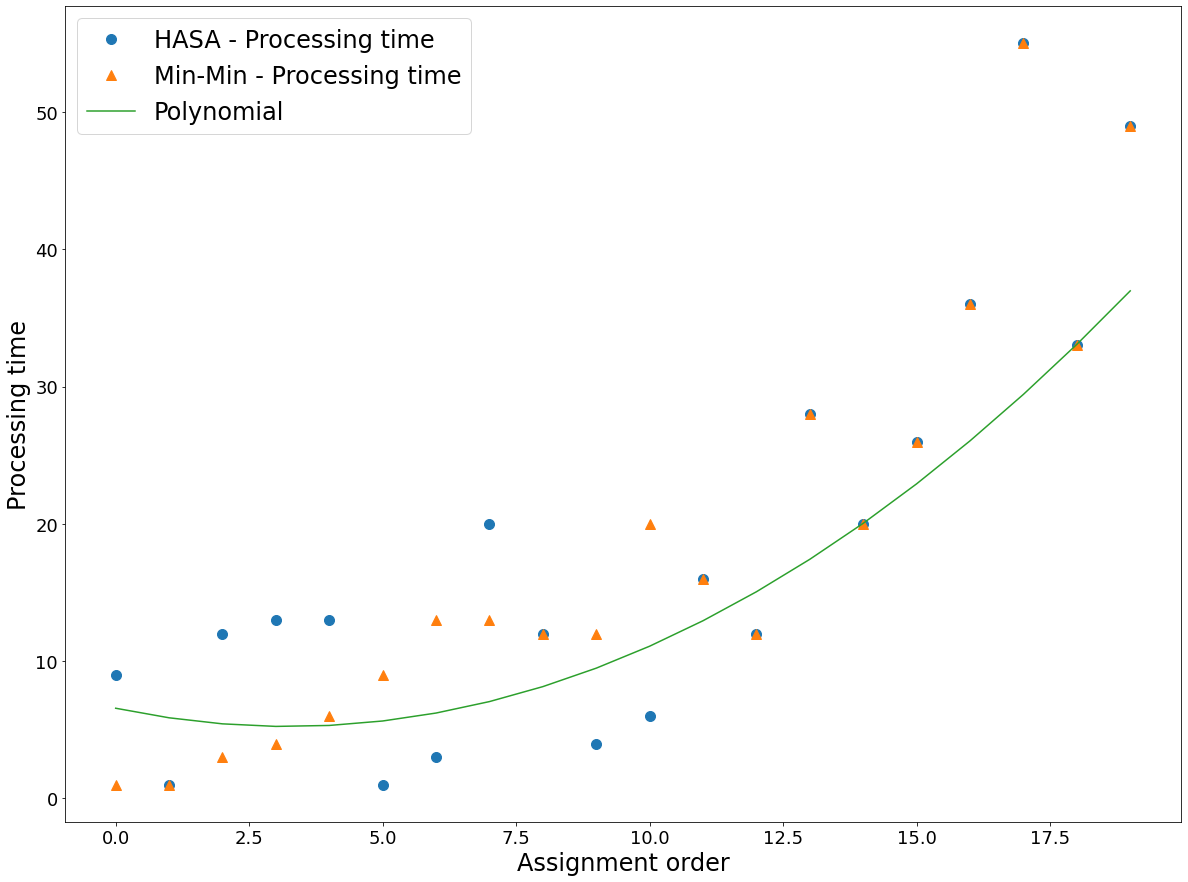

dataset: ./all_data/5x20-3.csv
Min-Min makespan: 136
process: [1, 2, 4, 5, 5, 5, 4, 4, 10, 14, 18, 20, 30, 19, 21, 52, 44, 37, 51, 97]

HASA makespan: 131
process: [10, 14, 5, 1, 8, 4, 2, 20, 5, 30, 6, 18, 4, 19, 21, 52, 44, 37, 51, 97]

Poly makespan: 136
process: [10, 5, 5, 4, 4, 1, 2, 4, 5, 14, 18, 20, 30, 19, 21, 52, 44, 37, 51, 97]





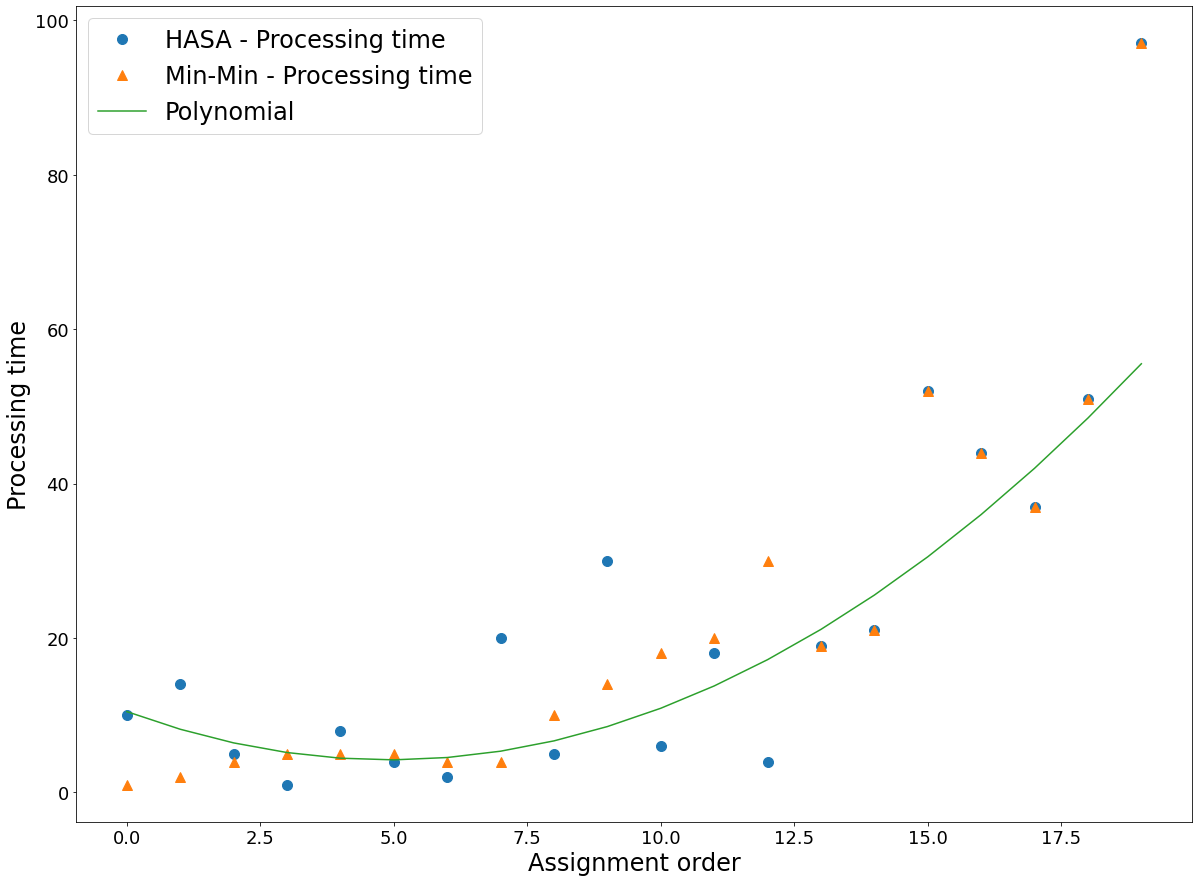

dataset: ./all_data/5x20-4.csv
Min-Min makespan: 86
process: [2, 4, 4, 7, 7, 6, 13, 11, 9, 13, 12, 10, 18, 18, 16, 16, 13, 19, 34, 50]

HASA makespan: 86
process: [7, 7, 2, 9, 11, 13, 4, 4, 6, 13, 12, 10, 18, 18, 16, 16, 13, 19, 34, 50]

Poly makespan: 86
process: [7, 7, 6, 4, 2, 4, 13, 11, 9, 13, 12, 10, 18, 18, 16, 16, 13, 19, 34, 50]





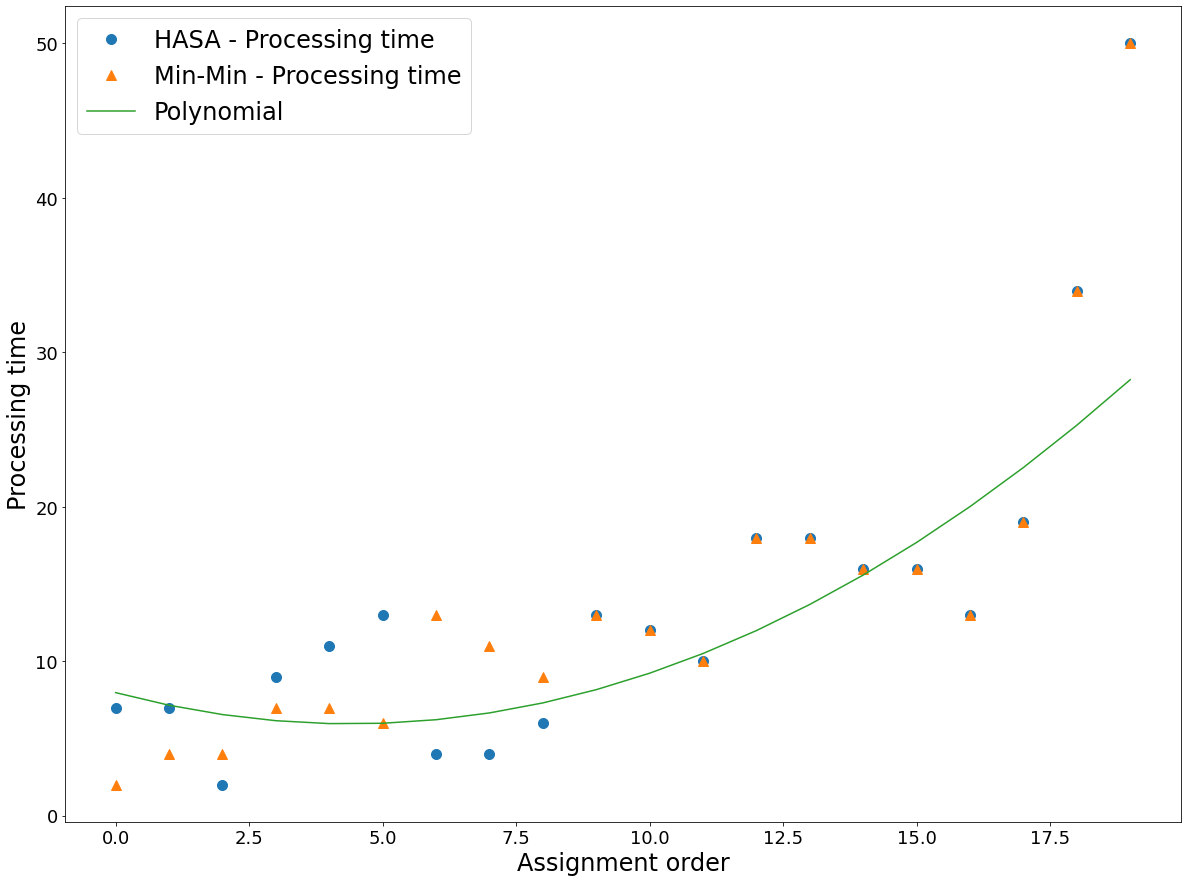

dataset: ./all_data/5x20-5.csv
Min-Min makespan: 95
process: [1, 2, 2, 2, 2, 2, 2, 3, 9, 10, 6, 9, 19, 17, 25, 45, 46, 37, 45, 59]

HASA makespan: 88
process: [9, 9, 2, 1, 2, 3, 18, 3, 19, 6, 9, 4, 2, 25, 36, 17, 37, 50, 45, 46]

Poly makespan: 95
process: [6, 2, 2, 2, 2, 1, 2, 9, 2, 10, 3, 9, 19, 17, 25, 45, 46, 37, 45, 59]





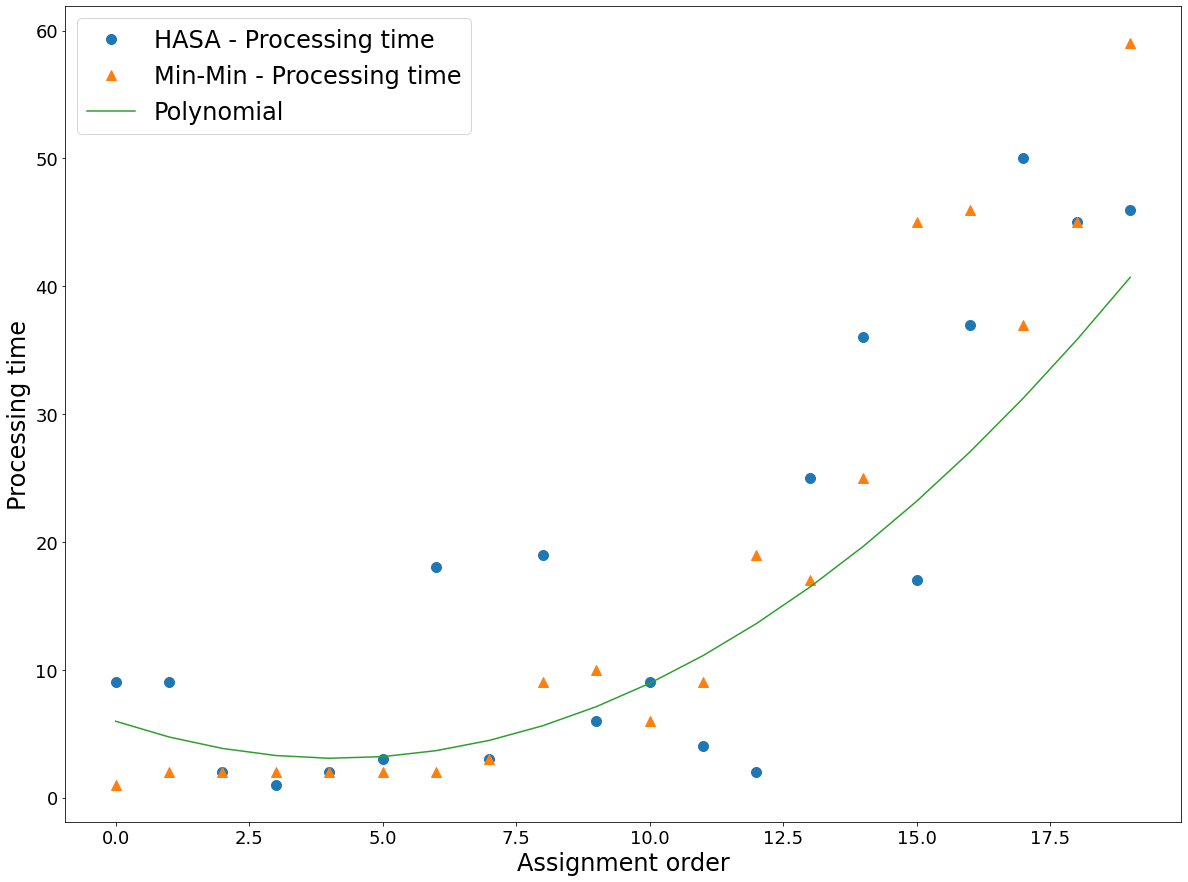

dataset: ./all_data/5x40-1.csv
Min-Min makespan: 144
process: [1, 1, 1, 2, 2, 3, 1, 2, 3, 3, 3, 6, 5, 4, 5, 5, 7, 5, 13, 7, 7, 14, 19, 13, 15, 18, 20, 23, 15, 17, 17, 34, 19, 18, 38, 46, 41, 56, 51, 57]

HASA makespan: 144
process: [7, 2, 7, 3, 1, 3, 1, 1, 13, 14, 4, 3, 2, 5, 2, 19, 1, 5, 3, 7, 5, 6, 5, 13, 15, 18, 20, 23, 15, 17, 17, 34, 19, 18, 38, 46, 41, 56, 51, 57]

Poly makespan: 144
process: [6, 5, 5, 4, 1, 1, 2, 1, 6, 3, 1, 2, 3, 2, 3, 3, 7, 5, 5, 13, 7, 19, 15, 14, 13, 18, 17, 23, 15, 20, 19, 17, 34, 18, 38, 46, 41, 56, 51, 57]





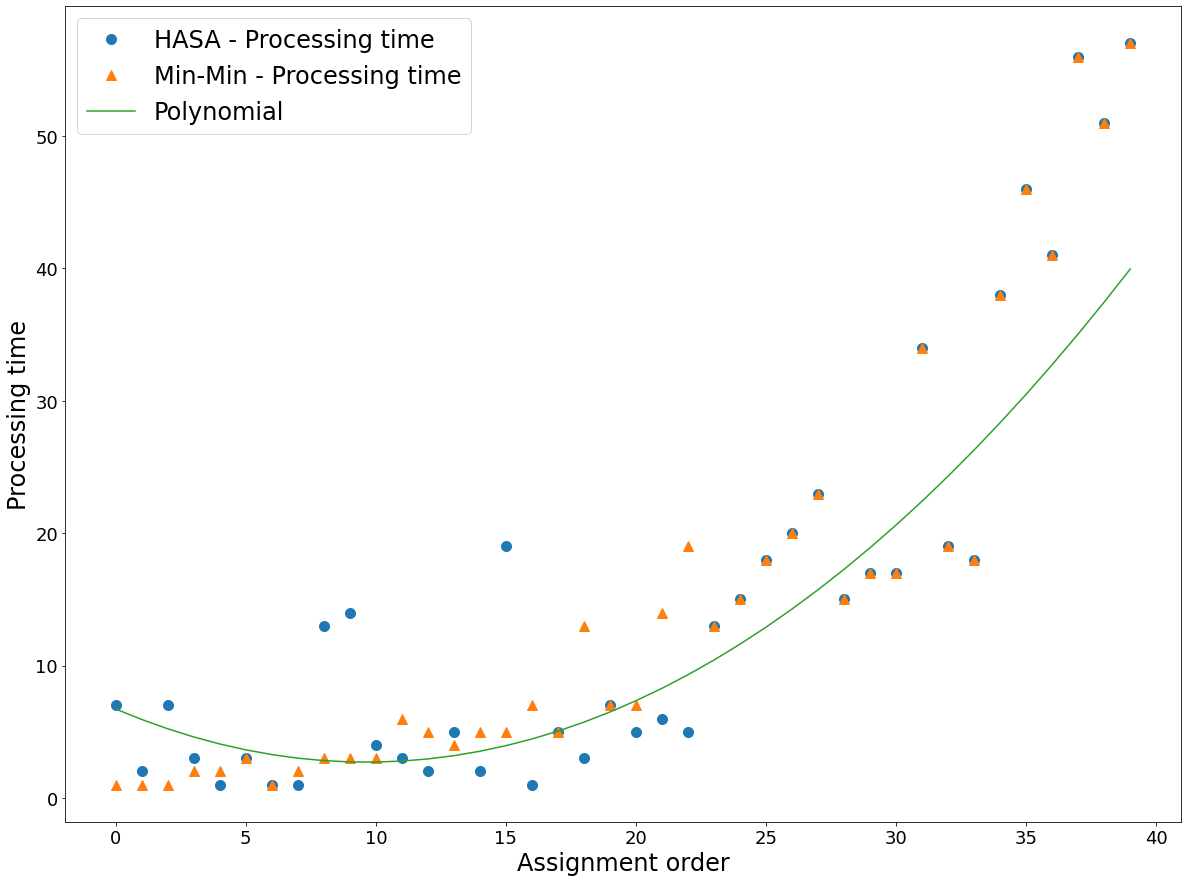

dataset: ./all_data/5x40-2.csv
Min-Min makespan: 160
process: [1, 1, 1, 3, 4, 4, 6, 3, 6, 4, 4, 4, 7, 7, 4, 12, 5, 8, 8, 6, 11, 11, 17, 11, 16, 13, 14, 15, 17, 23, 18, 28, 26, 33, 39, 43, 54, 33, 77, 54]

HASA makespan: 158
process: [8, 8, 7, 11, 4, 12, 6, 1, 7, 4, 1, 4, 1, 3, 6, 4, 4, 3, 11, 4, 9, 5, 17, 6, 16, 13, 14, 15, 17, 23, 18, 28, 26, 33, 43, 39, 54, 33, 77, 54]

Poly makespan: 160
process: [8, 8, 7, 6, 6, 1, 1, 1, 3, 4, 4, 6, 3, 4, 4, 12, 4, 4, 7, 11, 5, 11, 17, 11, 16, 13, 14, 15, 17, 23, 18, 28, 26, 33, 39, 43, 54, 33, 77, 54]





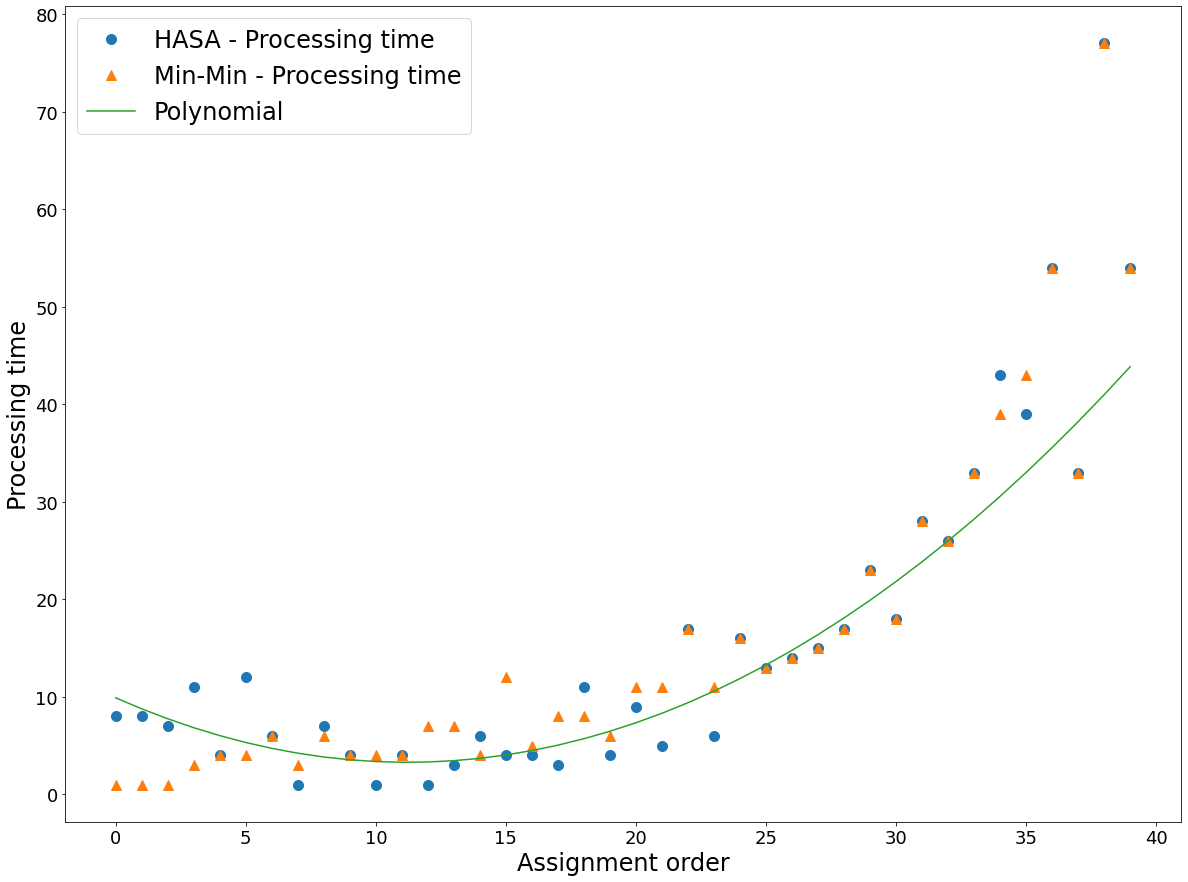

dataset: ./all_data/5x40-3.csv
Min-Min makespan: 192
process: [2, 2, 2, 5, 3, 6, 5, 4, 8, 9, 5, 8, 6, 16, 17, 10, 8, 16, 11, 18, 18, 21, 21, 22, 22, 26, 41, 22, 27, 37, 31, 41, 38, 43, 42, 39, 72, 61, 44, 48]

HASA makespan: 192
process: [10, 11, 2, 5, 3, 16, 17, 16, 4, 6, 5, 8, 2, 9, 5, 2, 6, 8, 8, 18, 18, 21, 21, 22, 22, 26, 41, 22, 27, 37, 31, 41, 38, 43, 42, 39, 72, 61, 44, 48]

Poly makespan: 192
process: [5, 5, 5, 6, 2, 8, 2, 3, 2, 9, 4, 8, 6, 16, 17, 10, 8, 16, 11, 18, 18, 21, 21, 22, 22, 26, 41, 22, 27, 37, 31, 41, 38, 43, 42, 39, 72, 61, 44, 48]





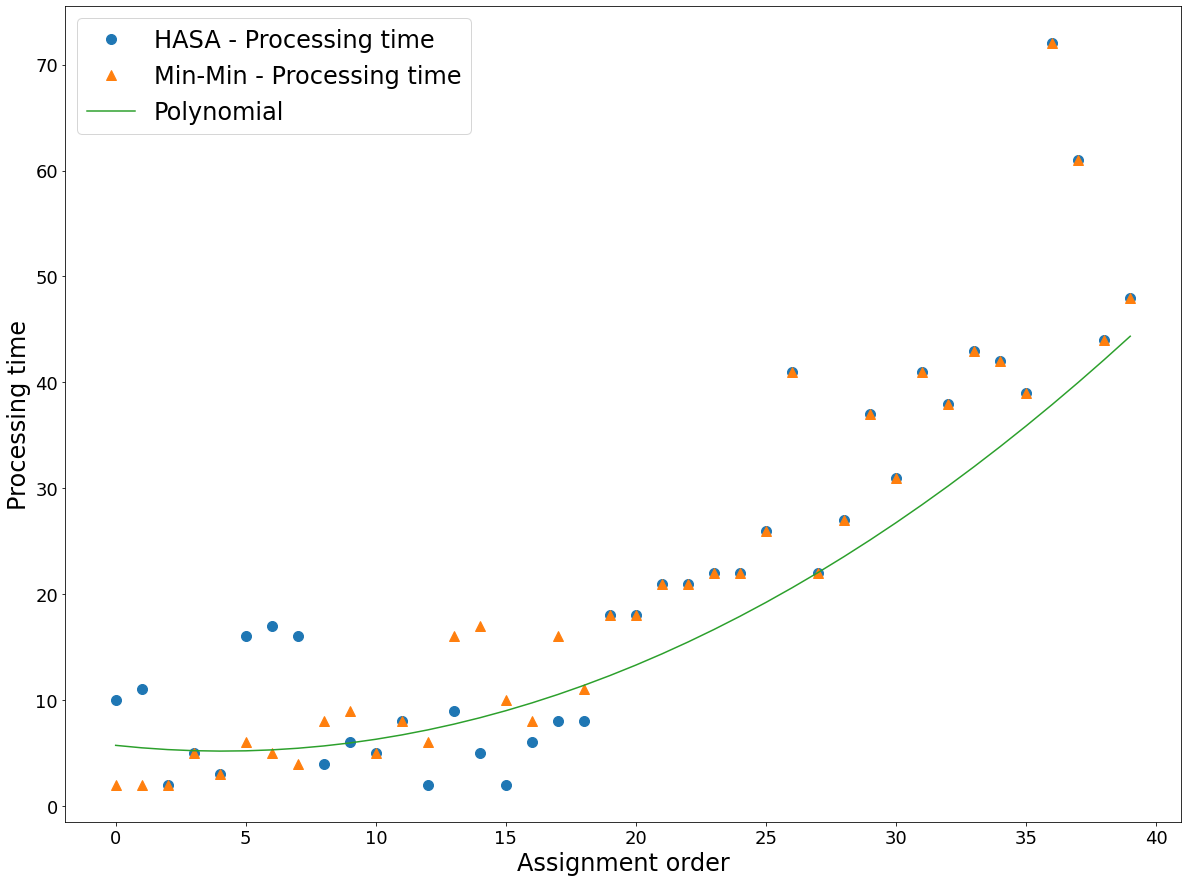

dataset: ./all_data/5x40-4.csv
Min-Min makespan: 179
process: [1, 1, 1, 2, 1, 6, 5, 6, 7, 10, 7, 7, 8, 14, 7, 8, 12, 7, 14, 10, 15, 13, 22, 11, 19, 19, 18, 22, 29, 26, 19, 22, 24, 30, 27, 39, 44, 46, 40, 62]

HASA makespan: 179
process: [8, 2, 10, 13, 1, 14, 1, 14, 6, 1, 1, 5, 6, 7, 7, 12, 7, 8, 10, 7, 15, 15, 11, 19, 18, 19, 22, 22, 19, 26, 22, 29, 24, 31, 27, 39, 44, 53, 40, 62]

Poly makespan: 179
process: [7, 6, 6, 5, 1, 1, 2, 1, 1, 10, 7, 7, 8, 14, 7, 8, 12, 7, 14, 10, 15, 13, 22, 11, 19, 19, 18, 22, 29, 26, 19, 22, 24, 30, 27, 39, 44, 46, 40, 62]





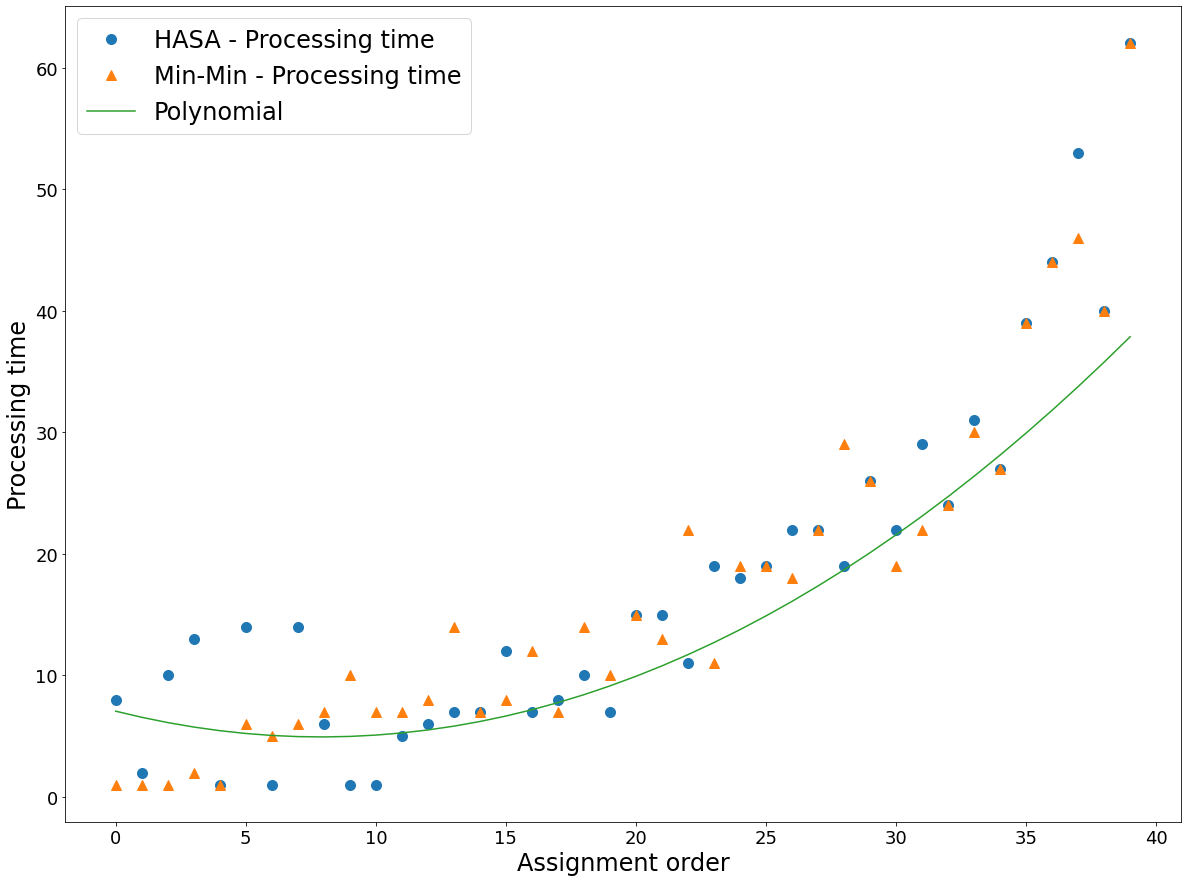

dataset: ./all_data/5x40-5.csv
Min-Min makespan: 168
process: [1, 1, 2, 2, 1, 3, 3, 5, 6, 6, 6, 6, 13, 8, 9, 12, 12, 8, 11, 11, 21, 15, 17, 16, 17, 21, 19, 30, 20, 19, 26, 26, 31, 23, 54, 41, 34, 28, 51, 40]

HASA makespan: 168
process: [8, 9, 10, 2, 12, 13, 3, 3, 5, 1, 8, 6, 6, 6, 6, 1, 1, 11, 11, 12, 21, 17, 16, 15, 21, 19, 30, 17, 20, 19, 28, 26, 31, 23, 41, 34, 28, 54, 51, 40]

Poly makespan: 168
process: [5, 6, 3, 2, 6, 1, 1, 1, 2, 3, 6, 6, 13, 8, 9, 12, 12, 8, 11, 11, 21, 15, 17, 16, 17, 21, 19, 30, 20, 19, 26, 26, 31, 23, 54, 41, 34, 28, 51, 40]





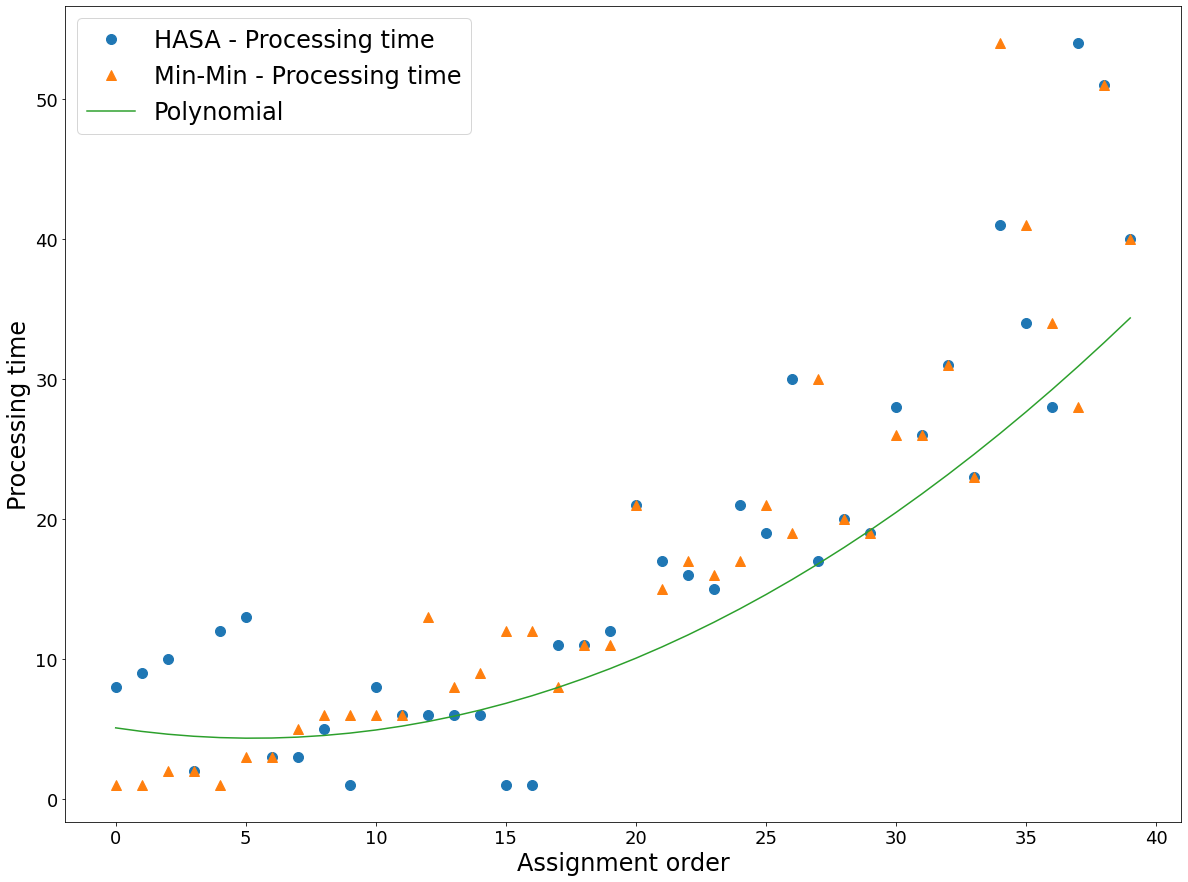

dataset: ./all_data/5x80-1.csv
Min-Min makespan: 279
process: [1, 1, 1, 2, 1, 3, 2, 3, 3, 3, 4, 3, 3, 6, 4, 4, 3, 5, 4, 6, 7, 5, 6, 6, 6, 8, 8, 11, 8, 7, 8, 8, 7, 8, 11, 9, 9, 9, 9, 14, 14, 13, 11, 10, 14, 17, 13, 19, 16, 18, 15, 22, 18, 25, 17, 27, 19, 23, 19, 25, 23, 24, 27, 22, 28, 23, 27, 29, 24, 28, 27, 27, 29, 37, 29, 37, 45, 40, 61, 59]

HASA makespan: 276
process: [7, 8, 9, 10, 3, 1, 3, 12, 6, 2, 3, 1, 3, 4, 1, 3, 3, 6, 3, 5, 1, 4, 6, 3, 6, 4, 5, 8, 11, 6, 6, 8, 8, 7, 8, 11, 8, 7, 9, 9, 9, 10, 17, 11, 14, 13, 16, 13, 18, 22, 19, 15, 18, 23, 17, 27, 25, 19, 19, 23, 27, 24, 25, 22, 23, 27, 29, 28, 24, 27, 27, 29, 28, 37, 37, 29, 35, 44, 55, 59]

Poly makespan: 279
process: [5, 5, 4, 4, 1, 1, 6, 1, 2, 1, 3, 3, 2, 3, 4, 3, 3, 3, 4, 6, 7, 3, 6, 6, 6, 8, 8, 11, 8, 7, 8, 8, 7, 8, 11, 9, 9, 9, 9, 14, 14, 13, 11, 10, 14, 17, 13, 19, 16, 18, 15, 22, 18, 25, 17, 27, 19, 23, 19, 25, 23, 24, 27, 22, 28, 23, 27, 29, 24, 28, 27, 27, 29, 37, 29, 37, 45, 40, 61, 59]





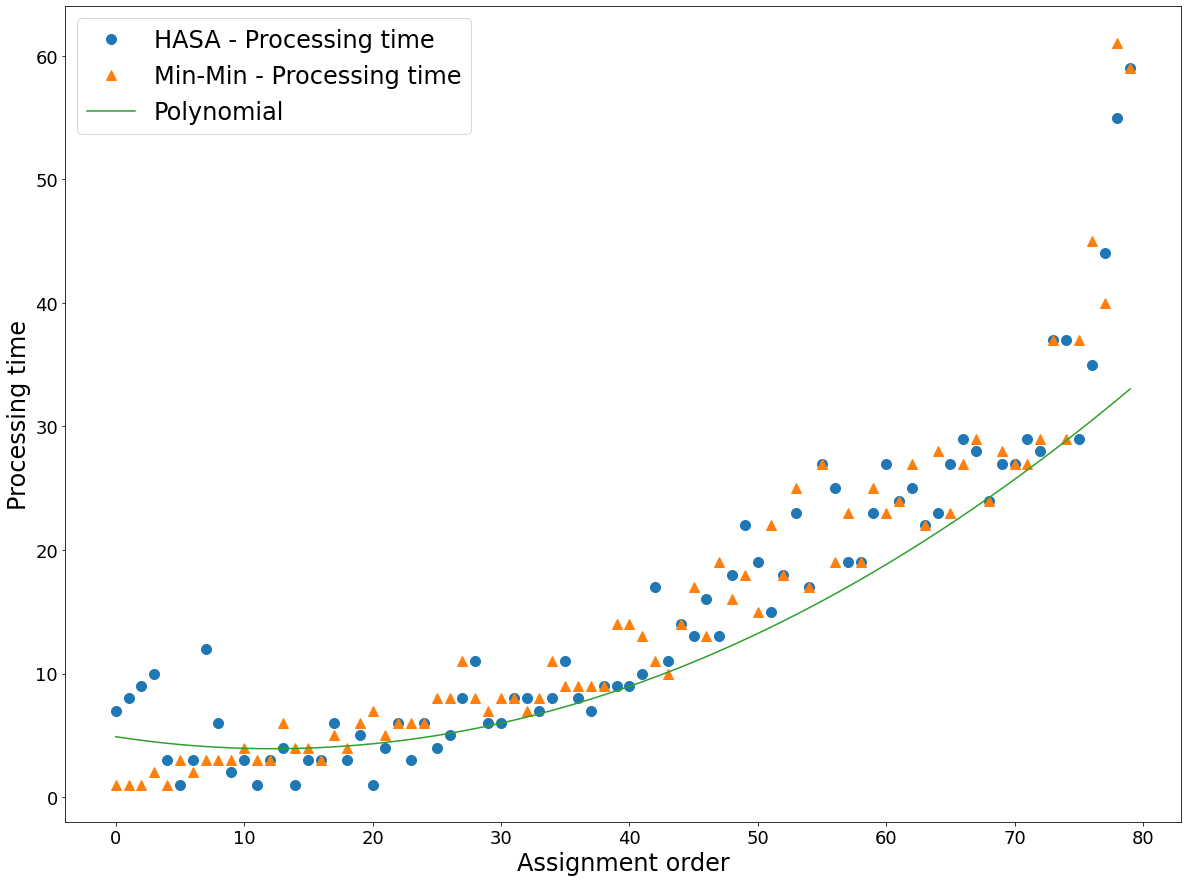

dataset: ./all_data/5x80-2.csv
Min-Min makespan: 320
process: [1, 1, 2, 2, 1, 1, 2, 4, 4, 4, 5, 3, 5, 4, 5, 6, 7, 5, 5, 6, 5, 9, 6, 9, 5, 7, 8, 10, 7, 9, 7, 13, 10, 10, 11, 11, 11, 12, 16, 13, 19, 13, 15, 15, 20, 14, 26, 16, 19, 16, 22, 18, 17, 21, 33, 23, 25, 18, 24, 24, 20, 37, 27, 25, 21, 29, 30, 27, 25, 29, 51, 33, 36, 31, 57, 57, 43, 45, 61, 77]

HASA makespan: 334
process: [9, 9, 10, 11, 4, 13, 5, 2, 4, 1, 2, 7, 1, 5, 2, 1, 5, 1, 4, 3, 5, 4, 5, 6, 5, 10, 6, 6, 9, 5, 7, 10, 8, 7, 11, 7, 11, 16, 13, 13, 19, 12, 14, 15, 20, 15, 26, 16, 19, 16, 22, 17, 21, 18, 33, 23, 18, 24, 25, 20, 24, 37, 25, 21, 30, 29, 25, 25, 39, 29, 49, 35, 45, 31, 51, 43, 57, 53, 57, 100]

Poly makespan: 320
process: [7, 6, 1, 5, 5, 5, 1, 2, 2, 1, 1, 2, 4, 4, 4, 3, 7, 4, 5, 6, 5, 9, 5, 9, 5, 6, 8, 10, 7, 9, 7, 13, 10, 10, 11, 11, 11, 12, 16, 13, 19, 13, 15, 15, 20, 14, 26, 16, 19, 16, 22, 18, 17, 21, 33, 23, 25, 18, 24, 24, 20, 37, 27, 25, 21, 29, 30, 27, 25, 29, 51, 33, 36, 31, 57, 57, 43, 45, 61, 77]





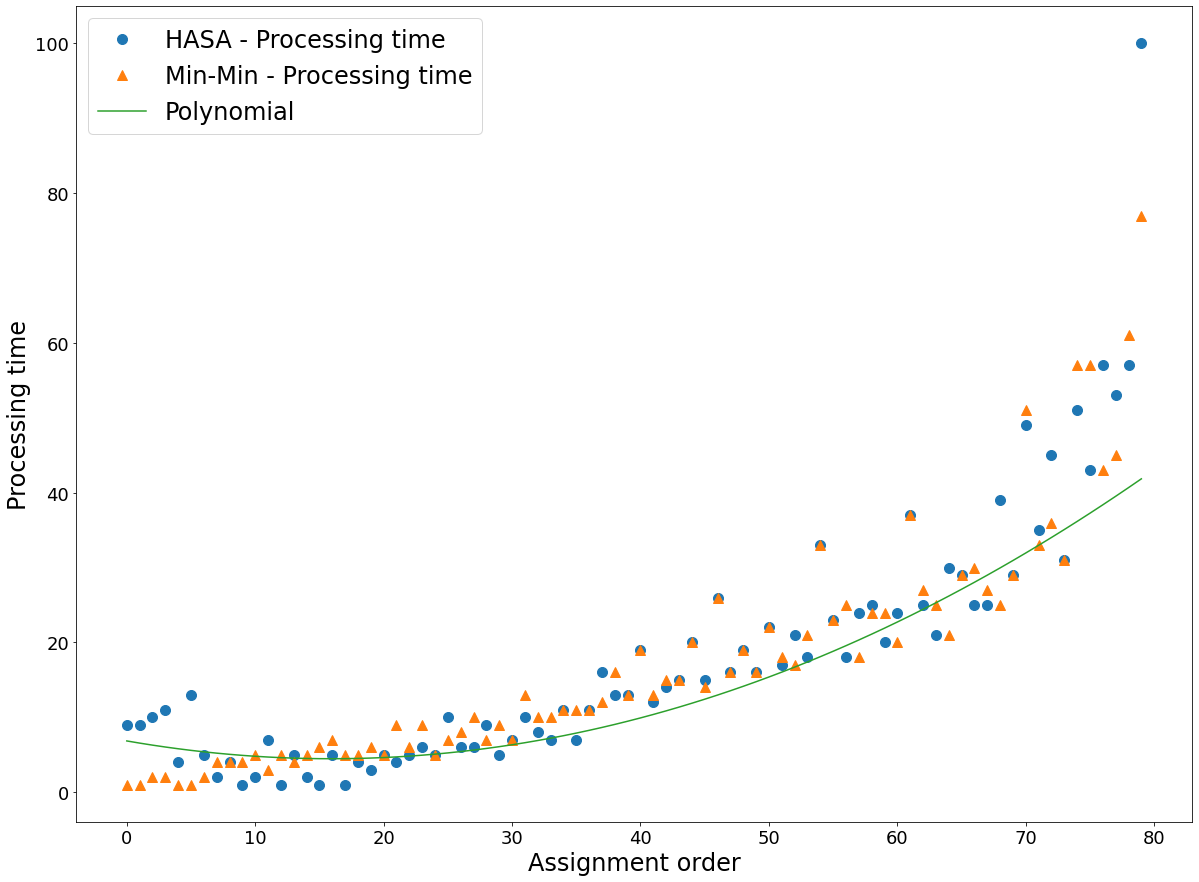

dataset: ./all_data/5x80-3.csv
Min-Min makespan: 309
process: [1, 1, 1, 2, 1, 3, 3, 3, 3, 4, 4, 4, 3, 5, 4, 4, 11, 10, 5, 5, 6, 6, 6, 8, 10, 12, 6, 8, 8, 10, 8, 8, 14, 9, 11, 10, 11, 11, 16, 13, 15, 13, 11, 17, 16, 14, 12, 16, 16, 18, 15, 15, 16, 15, 16, 21, 21, 28, 24, 24, 21, 32, 31, 26, 28, 29, 35, 28, 30, 36, 42, 35, 31, 32, 31, 47, 71, 63, 37, 94]

HASA makespan: 309
process: [8, 9, 10, 1, 3, 2, 1, 12, 1, 13, 4, 4, 3, 4, 4, 3, 1, 5, 3, 3, 5, 4, 10, 11, 6, 5, 6, 8, 10, 6, 8, 14, 6, 8, 11, 8, 11, 11, 16, 10, 15, 13, 11, 17, 16, 14, 12, 16, 16, 18, 15, 15, 16, 15, 16, 21, 21, 28, 24, 24, 21, 32, 31, 26, 28, 29, 35, 28, 30, 36, 42, 35, 31, 32, 31, 47, 71, 63, 37, 94]

Poly makespan: 306
process: [8, 6, 7, 1, 4, 1, 1, 3, 1, 2, 4, 3, 3, 4, 11, 4, 3, 10, 4, 5, 5, 5, 6, 10, 6, 12, 6, 8, 8, 10, 8, 14, 8, 10, 11, 9, 11, 13, 16, 11, 15, 13, 11, 16, 17, 14, 16, 12, 16, 18, 15, 16, 15, 16, 21, 21, 15, 28, 24, 21, 24, 32, 31, 26, 29, 28, 35, 28, 36, 30, 42, 35, 31, 32, 31, 47, 71, 37, 63, 94]



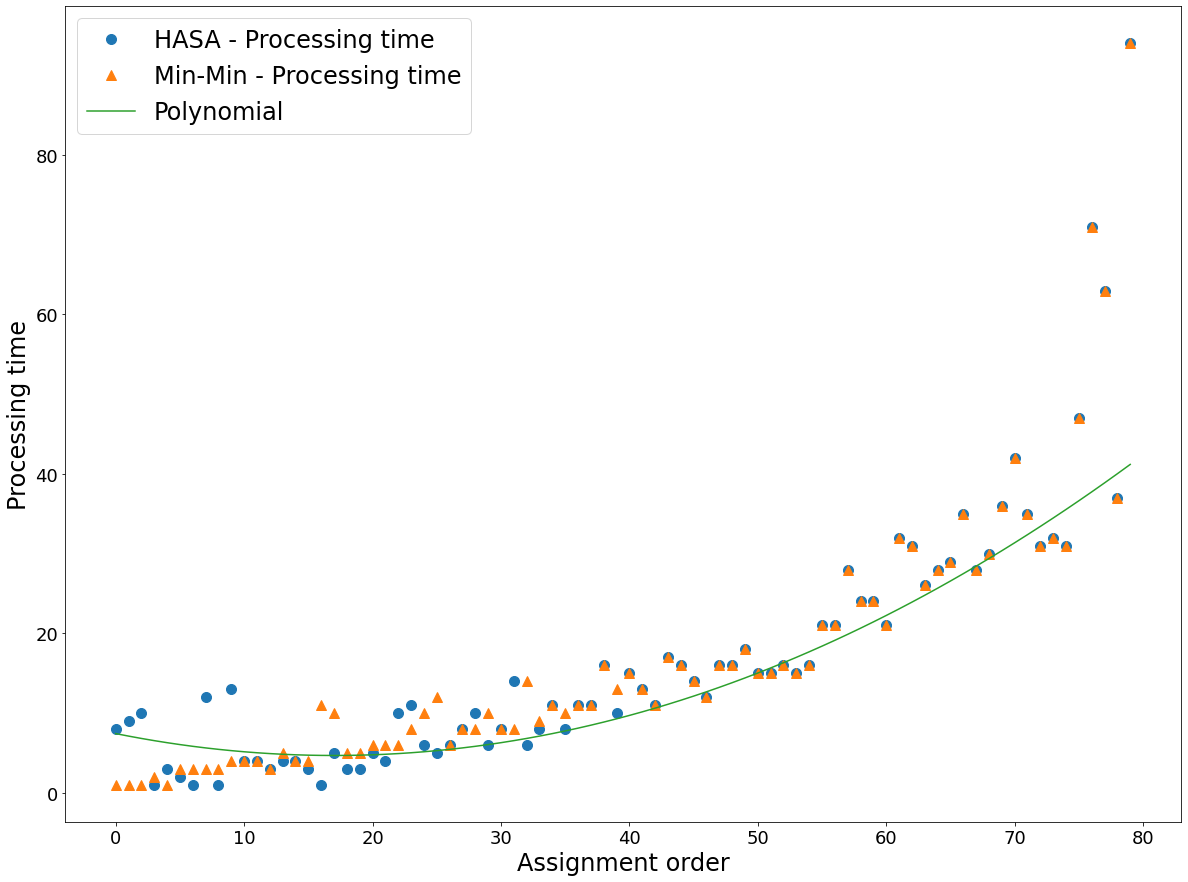

dataset: ./all_data/5x80-4.csv
Min-Min makespan: 335
process: [1, 1, 3, 3, 3, 5, 6, 3, 3, 5, 3, 4, 6, 7, 4, 5, 8, 6, 4, 5, 9, 7, 6, 8, 5, 6, 8, 11, 10, 8, 18, 12, 8, 13, 14, 10, 14, 19, 16, 17, 16, 15, 19, 17, 21, 18, 19, 26, 19, 22, 29, 22, 22, 31, 26, 30, 26, 27, 34, 27, 31, 32, 28, 27, 36, 28, 36, 44, 28, 37, 31, 38, 32, 49, 41, 44, 58, 48, 61, 56]

HASA makespan: 330
process: [10, 10, 11, 1, 12, 3, 5, 3, 1, 5, 17, 3, 5, 4, 3, 3, 6, 6, 3, 4, 8, 4, 6, 7, 5, 8, 5, 7, 9, 6, 14, 8, 13, 8, 8, 18, 14, 17, 16, 16, 15, 19, 17, 21, 18, 19, 19, 26, 22, 29, 19, 22, 31, 22, 26, 30, 27, 26, 34, 27, 28, 32, 31, 27, 36, 28, 44, 28, 36, 31, 37, 32, 38, 49, 41, 58, 48, 44, 56, 61]

Poly makespan: 335
process: [5, 5, 5, 4, 1, 6, 1, 3, 3, 3, 6, 3, 3, 7, 3, 4, 8, 6, 4, 5, 9, 7, 6, 8, 5, 6, 8, 11, 10, 8, 18, 12, 8, 13, 14, 10, 14, 19, 16, 17, 16, 15, 19, 17, 21, 18, 19, 26, 19, 22, 29, 22, 22, 31, 26, 30, 26, 27, 34, 27, 31, 32, 28, 27, 36, 28, 36, 44, 28, 37, 31, 38, 32, 49, 41, 44, 58, 48, 61, 56]





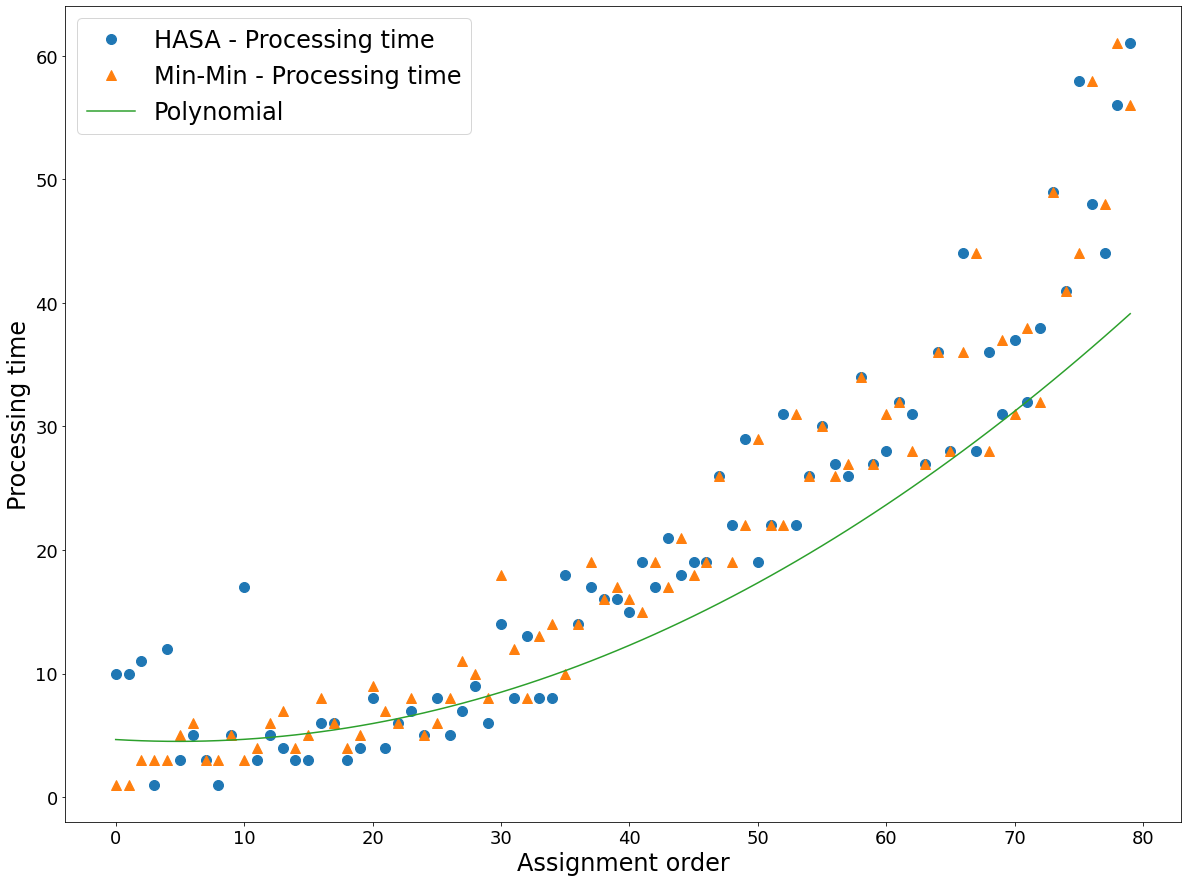

dataset: ./all_data/5x80-5.csv
Min-Min makespan: 302
process: [1, 1, 2, 2, 1, 1, 1, 2, 2, 4, 4, 3, 4, 3, 4, 5, 7, 4, 4, 4, 5, 5, 7, 5, 11, 6, 6, 5, 7, 6, 6, 8, 8, 11, 7, 8, 8, 11, 10, 13, 12, 10, 14, 19, 15, 17, 10, 18, 12, 16, 20, 25, 12, 24, 19, 13, 22, 27, 20, 16, 27, 24, 18, 25, 34, 20, 33, 34, 27, 35, 28, 36, 34, 43, 31, 61, 49, 70, 60, 89]

HASA makespan: 315
process: [8, 8, 9, 2, 11, 2, 1, 12, 4, 3, 7, 4, 2, 4, 1, 1, 1, 2, 4, 1, 4, 3, 7, 4, 5, 5, 4, 5, 5, 6, 7, 11, 6, 5, 6, 6, 10, 7, 11, 8, 17, 10, 14, 15, 10, 20, 25, 18, 10, 15, 12, 22, 20, 16, 26, 13, 20, 16, 24, 24, 27, 18, 25, 27, 33, 20, 34, 27, 34, 28, 34, 35, 36, 31, 49, 43, 70, 61, 60, 83]

Poly makespan: 280
process: [7, 7, 7, 6, 5, 2, 1, 1, 1, 2, 1, 1, 2, 2, 4, 4, 4, 3, 3, 5, 4, 4, 4, 11, 5, 4, 5, 7, 5, 6, 6, 8, 11, 8, 6, 8, 8, 10, 11, 13, 12, 14, 10, 15, 17, 10, 18, 25, 12, 15, 20, 12, 16, 24, 26, 13, 22, 20, 16, 27, 27, 24, 18, 25, 33, 20, 34, 34, 27, 28, 36, 35, 34, 43, 31, 49, 61, 70, 66, 65]





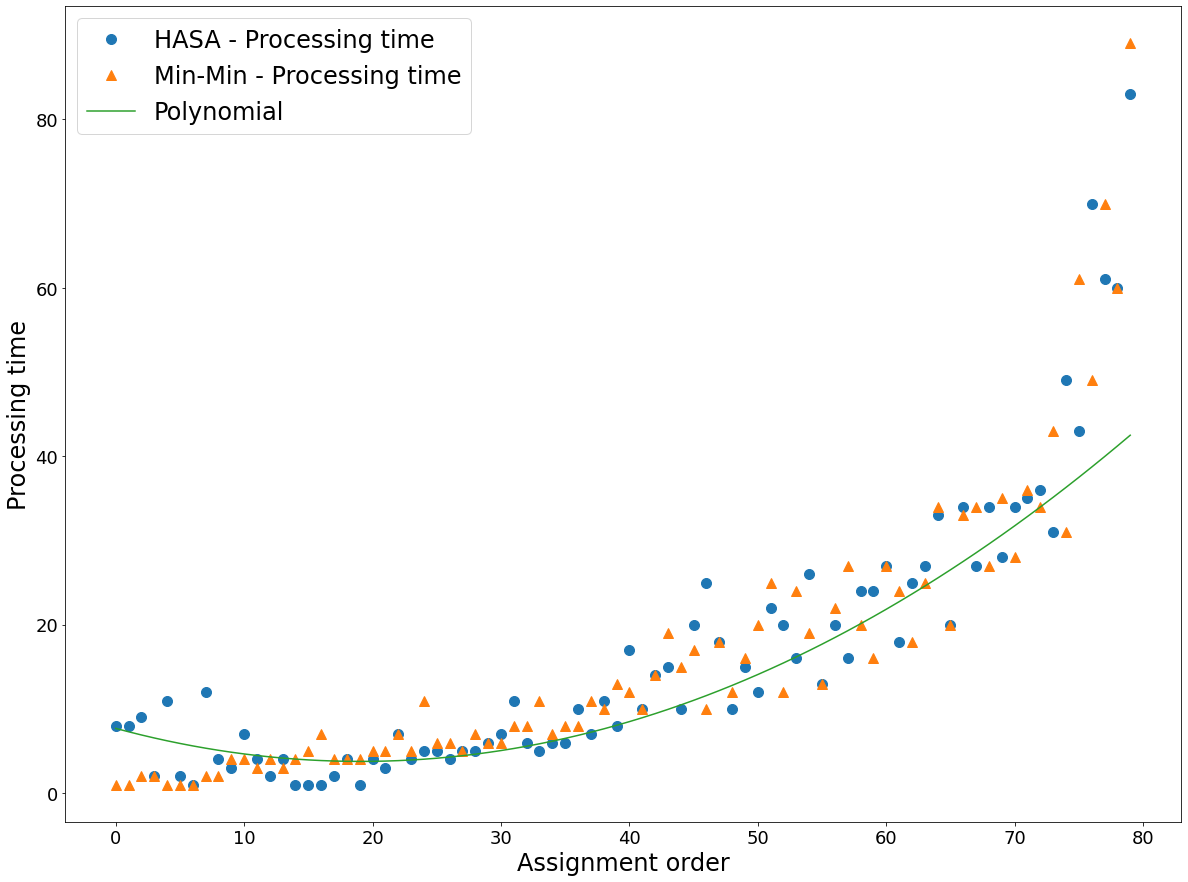

dataset: ./all_data/8x50-1.csv
Min-Min makespan: 115
process: [1, 1, 1, 2, 2, 1, 1, 4, 4, 4, 3, 4, 4, 6, 4, 3, 6, 5, 6, 8, 6, 8, 6, 9, 8, 7, 9, 12, 11, 10, 11, 12, 11, 11, 14, 11, 13, 17, 22, 16, 18, 25, 16, 31, 18, 25, 20, 26, 33, 59]

HASA makespan: 115
process: [6, 6, 6, 6, 7, 1, 2, 8, 1, 9, 1, 1, 4, 11, 1, 4, 2, 4, 3, 3, 4, 4, 11, 12, 5, 7, 8, 6, 10, 8, 12, 9, 11, 11, 11, 22, 14, 13, 17, 18, 31, 16, 18, 18, 25, 20, 25, 26, 49, 59]

Poly makespan: 115
process: [6, 5, 5, 4, 4, 4, 3, 2, 1, 2, 1, 6, 1, 1, 3, 4, 6, 4, 4, 6, 8, 6, 9, 8, 8, 7, 12, 11, 10, 11, 9, 12, 11, 14, 11, 11, 13, 17, 22, 18, 20, 18, 16, 31, 18, 25, 25, 26, 33, 59]





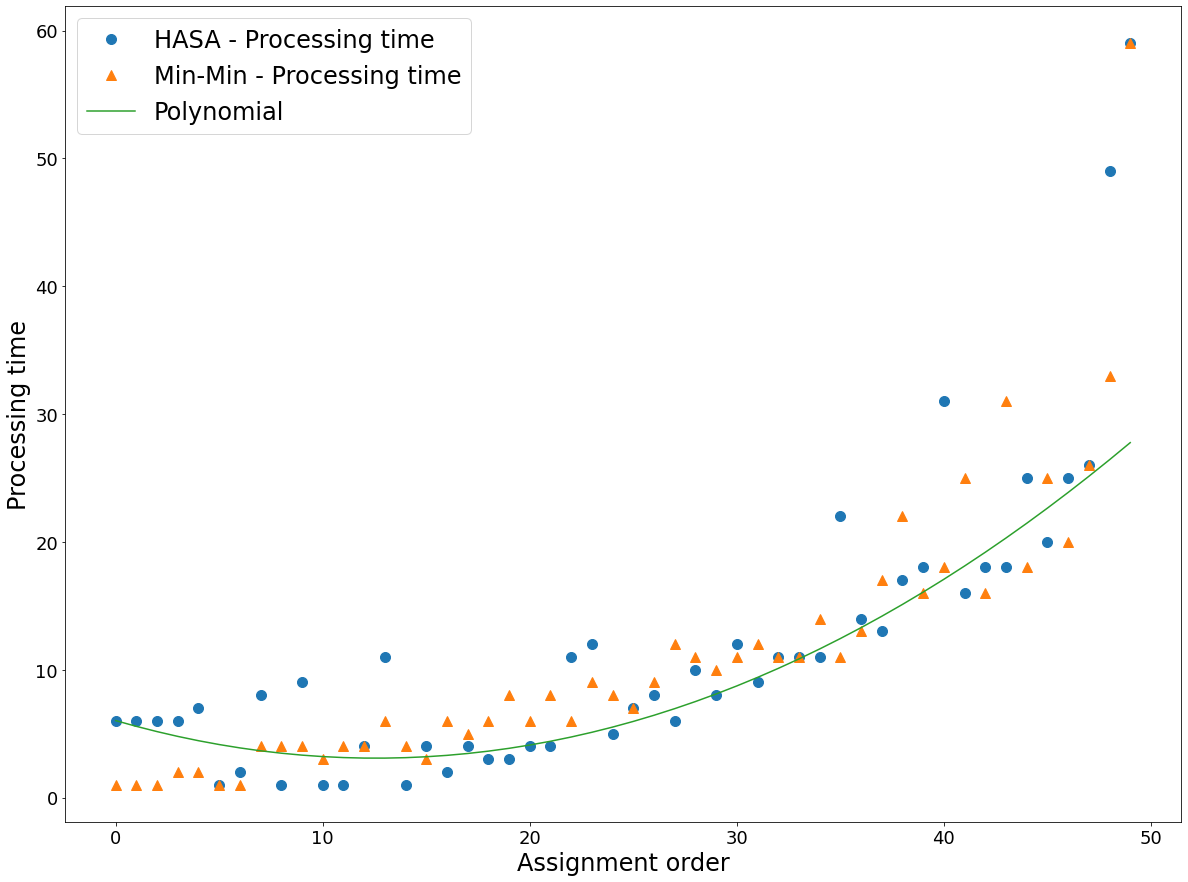

dataset: ./all_data/8x50-2.csv
Min-Min makespan: 96
process: [1, 1, 1, 2, 1, 1, 3, 3, 4, 5, 3, 4, 3, 3, 4, 4, 4, 5, 5, 5, 8, 7, 7, 7, 5, 5, 10, 8, 9, 6, 8, 13, 12, 12, 11, 11, 11, 13, 17, 15, 12, 16, 17, 24, 18, 29, 20, 45, 37, 60]

HASA makespan: 96
process: [5, 5, 5, 1, 1, 7, 7, 7, 1, 1, 8, 1, 10, 3, 5, 3, 4, 4, 3, 2, 3, 4, 4, 5, 3, 5, 4, 8, 9, 6, 8, 13, 12, 12, 11, 11, 11, 13, 17, 15, 12, 16, 17, 24, 18, 29, 20, 45, 37, 60]

Poly makespan: 96
process: [7, 6, 5, 5, 4, 4, 4, 3, 1, 2, 1, 1, 1, 1, 4, 3, 3, 5, 3, 8, 4, 7, 3, 5, 5, 8, 10, 9, 6, 8, 5, 11, 13, 12, 11, 11, 12, 13, 17, 15, 12, 22, 17, 18, 29, 20, 24, 37, 45, 60]





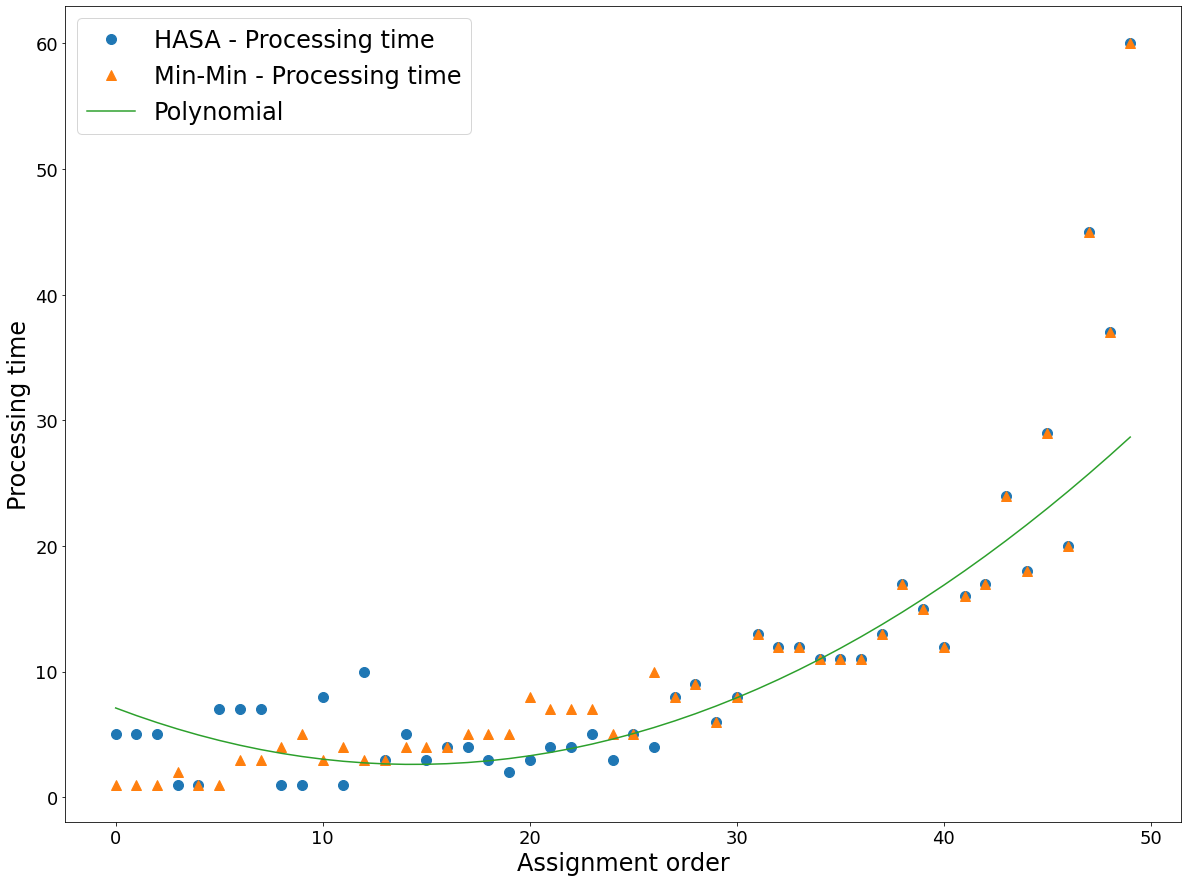

dataset: ./all_data/8x50-3.csv
Min-Min makespan: 107
process: [1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 4, 2, 2, 5, 6, 3, 4, 5, 5, 7, 6, 6, 11, 8, 9, 7, 7, 13, 7, 9, 9, 13, 9, 13, 18, 27, 16, 19, 15, 27, 25, 28, 19, 29, 32, 27, 19, 51, 60]

HASA makespan: 110
process: [5, 6, 6, 7, 8, 1, 6, 2, 9, 1, 1, 4, 1, 10, 1, 6, 2, 2, 3, 2, 1, 4, 7, 11, 4, 2, 7, 5, 9, 7, 13, 11, 9, 13, 18, 16, 13, 25, 27, 15, 27, 28, 19, 19, 32, 27, 29, 19, 51, 26]

Poly makespan: 110
process: [5, 4, 5, 3, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 6, 2, 4, 5, 5, 3, 7, 6, 6, 9, 8, 11, 7, 9, 7, 13, 9, 9, 13, 13, 18, 27, 16, 25, 15, 19, 27, 28, 19, 29, 27, 32, 19, 51, 60]





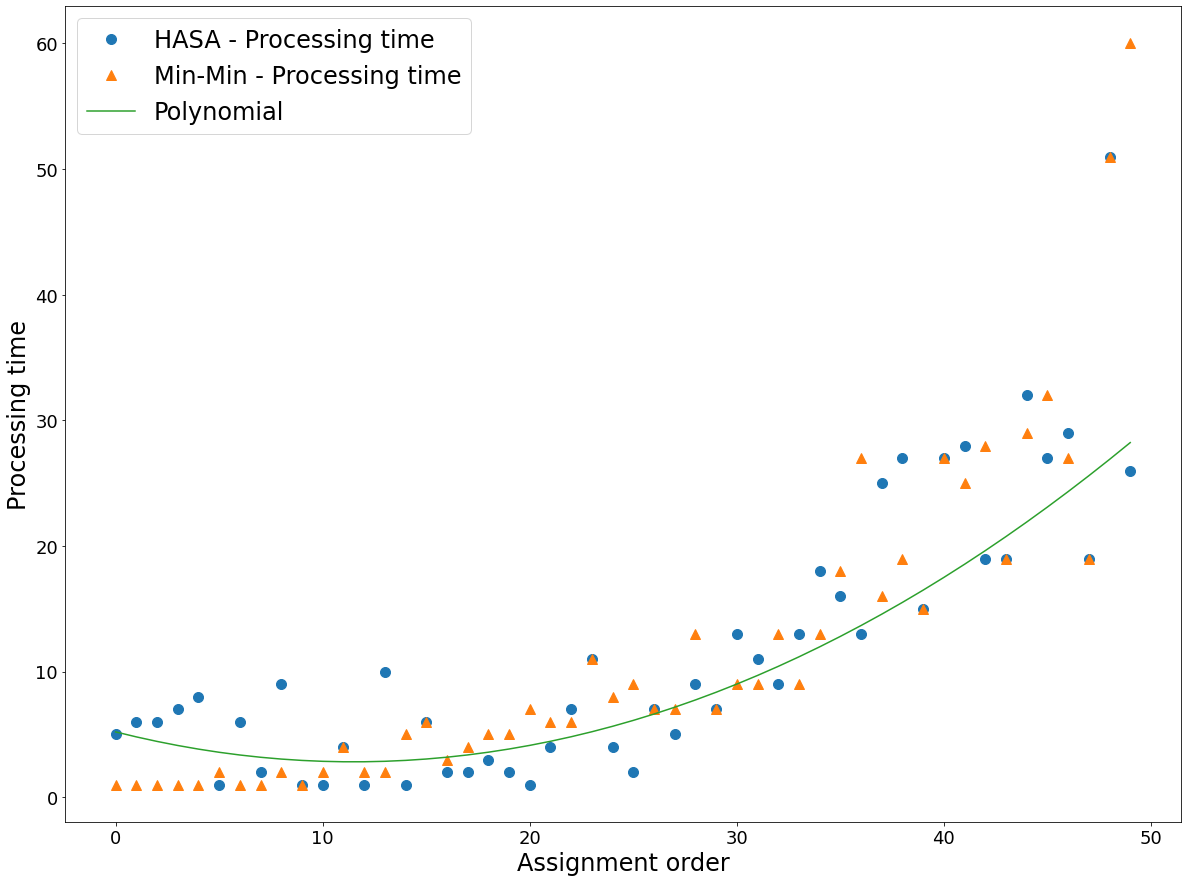

dataset: ./all_data/8x50-4.csv
Min-Min makespan: 78
process: [1, 1, 1, 1, 2, 1, 2, 3, 3, 3, 5, 6, 3, 8, 5, 6, 4, 5, 9, 5, 5, 6, 5, 7, 10, 12, 9, 9, 8, 10, 9, 15, 13, 12, 10, 11, 18, 26, 23, 14, 14, 16, 20, 17, 30, 22, 30, 28, 19, 29]

HASA makespan: 78
process: [5, 6, 6, 6, 1, 7, 7, 3, 8, 9, 2, 1, 3, 5, 1, 1, 3, 6, 2, 1, 5, 4, 5, 10, 9, 12, 9, 8, 10, 9, 9, 15, 13, 10, 12, 11, 18, 26, 14, 16, 23, 14, 20, 17, 30, 30, 22, 19, 28, 29]

Poly makespan: 78
process: [4, 3, 3, 1, 1, 2, 5, 1, 1, 1, 2, 6, 3, 8, 3, 5, 6, 5, 9, 5, 5, 6, 5, 7, 10, 12, 9, 9, 8, 10, 9, 15, 13, 12, 10, 11, 18, 26, 23, 14, 14, 16, 20, 17, 30, 22, 30, 28, 19, 29]





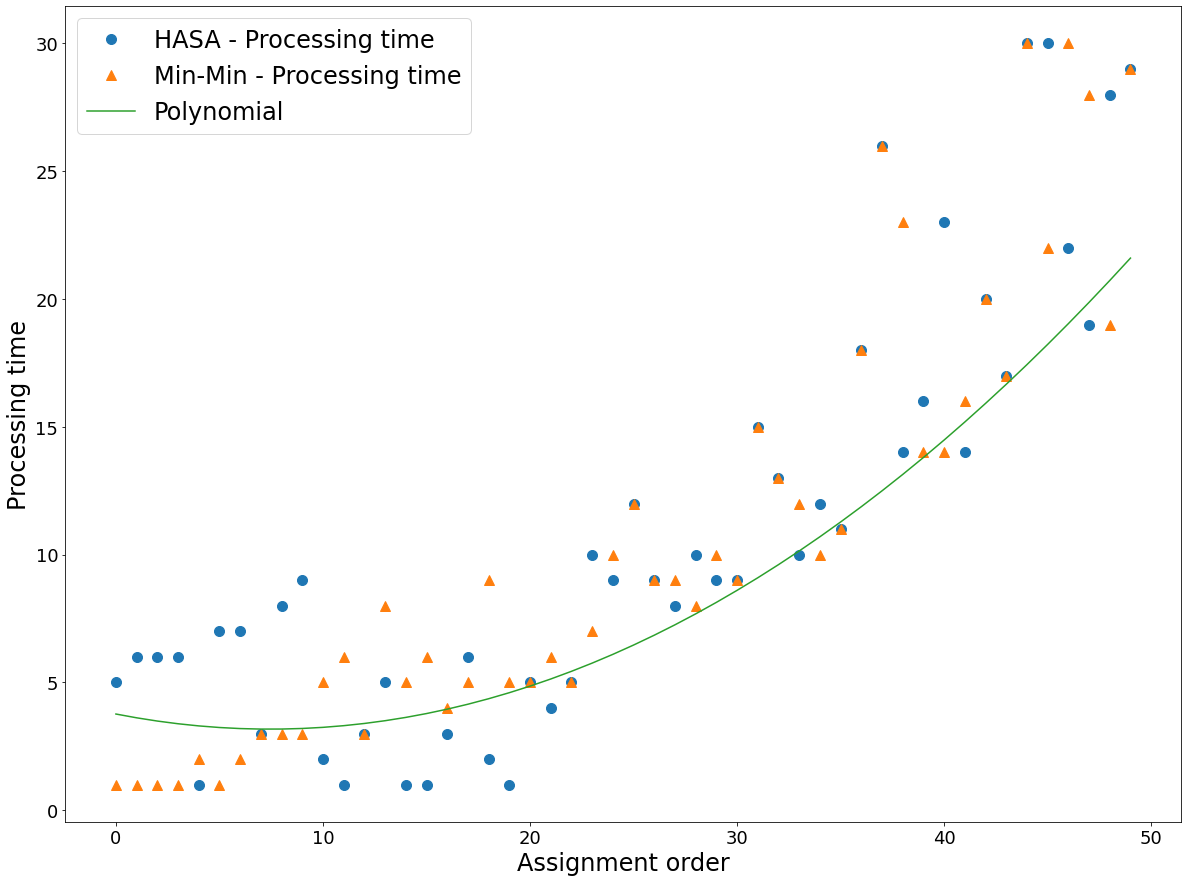

dataset: ./all_data/8x50-5.csv
Min-Min makespan: 97
process: [1, 1, 1, 1, 1, 3, 3, 3, 2, 2, 5, 5, 5, 3, 3, 4, 5, 4, 5, 6, 6, 5, 6, 11, 4, 8, 7, 8, 6, 9, 13, 9, 13, 8, 17, 11, 11, 9, 14, 21, 18, 19, 17, 12, 18, 22, 19, 18, 23, 31]

HASA makespan: 97
process: [4, 5, 5, 1, 6, 1, 6, 1, 3, 1, 8, 1, 2, 2, 11, 3, 5, 6, 3, 4, 15, 4, 5, 8, 7, 4, 6, 9, 11, 11, 5, 9, 8, 11, 13, 13, 9, 17, 18, 14, 21, 18, 17, 12, 19, 17, 18, 22, 23, 31]

Poly makespan: 97
process: [3, 3, 3, 3, 2, 1, 1, 1, 1, 5, 5, 1, 5, 3, 2, 4, 5, 4, 5, 6, 6, 5, 6, 11, 4, 8, 7, 8, 6, 9, 13, 9, 13, 8, 17, 11, 11, 9, 14, 21, 18, 19, 17, 12, 18, 22, 19, 18, 23, 31]





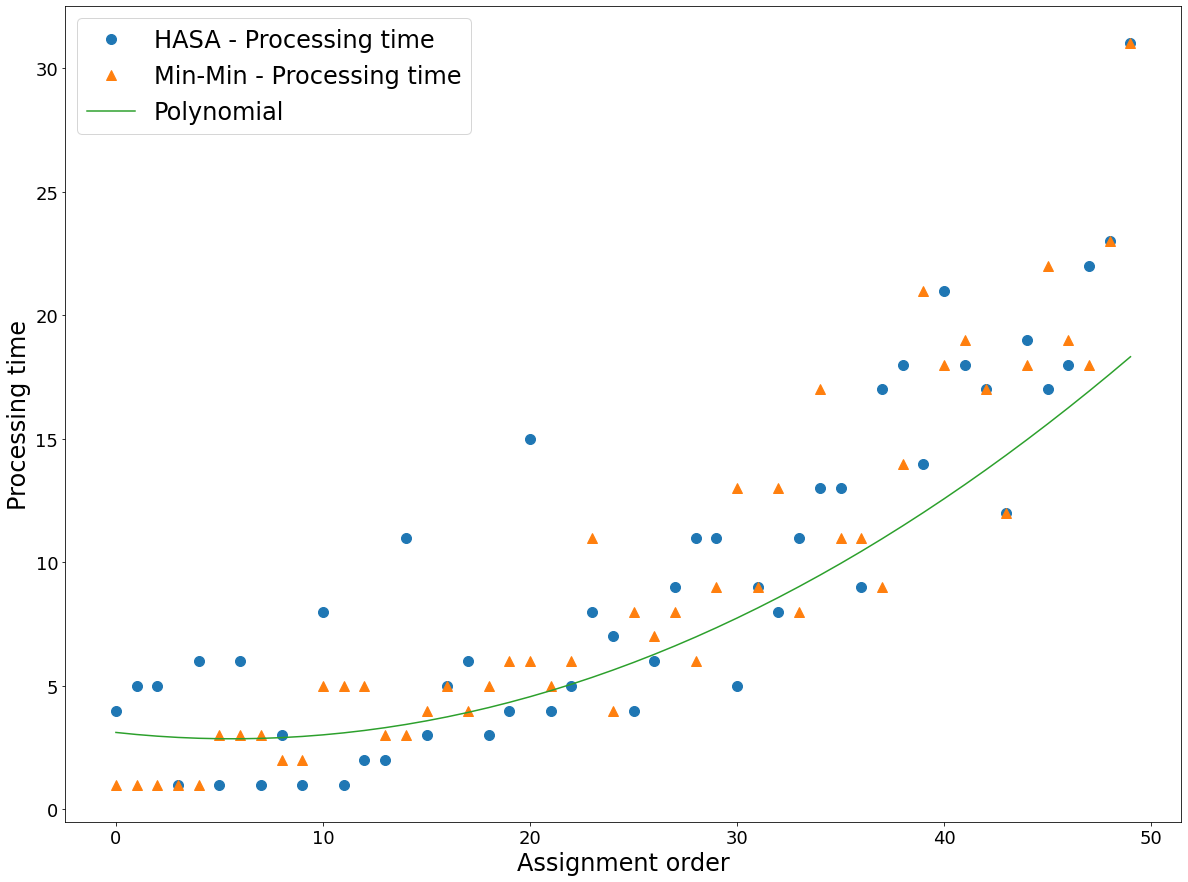

In [52]:
# import all datasets.
path = './all_data'
filename_list = glob.glob(path + "/*.csv")

if __name__ == '__main__':
    polynomial_job_shop_main(filename_list)